# Make figures for TSNBOT at Col de Porte

In [1]:
# Env: sc2_v0
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xskillscore as xs
import calendar
import os

In [2]:
site = 'cdp'
site_longname = 'Col de Porte, France'
y_start = 2002
y_end = 2014

# labels = ['peat_30min_ext', 'peat']
labels = [
    # 'DEF',
    # 'BUG_CORRECT',
    # 'BUG_CORRECT_TSNBT_OP1',
    # 'BUG_CORRECT_TSNBT_OP1_EZERO',
    # 'PHYS_ALL_SUBLI_CORRECT',
    # 'PHYS_ALL_SUBLI_v2',
    # 'PHYS_ALL_SUBLI_CORRECT_COMPAC',
    # 'PHYS_ALL_SUBLI_v2_COMPAC_v1',
    # 'PHYS_ALL_SUBLI_v2_COMPAC_v1_calonne', # Best without TVC (COMPACT_2.5)
    'PHYS_ALL_SUBLI_v2_COMPAC_2.5_LIM_3.5_calonne', # best with TVC
    'PHYS_ALL_SUBLI_v2_COMPAC_2.5_LIM_3.5_calonne_test', # best with TVC
]

root_path = '/home/lalandmi/eccc/classic-develop/outputFiles/SnowMIP/'+site+'/'
paths = [root_path+'run_'+label for label in labels]

# ds_yr_list = [xr.open_mfdataset(path+'/*_annually.nc').squeeze().load() for path in paths]
# ds_mo_list = [xr.open_mfdataset(path+'/*_monthly.nc').squeeze().load() for path in paths]
ds_d_list = [xr.open_mfdataset(path+'/*_daily.nc').squeeze().load() for path in paths]
# ds_hh_list = [xr.open_mfdataset(path+'/*_halfhourly.nc').squeeze().load() for path in paths]

In [3]:
path = "/home/lalandmi/eccc/classic-develop/inputFiles/SnowMIP/"+site
rsfile = xr.open_dataset(path+'/rsfile_spinup-final_Ref.nc')

In [4]:
def assign_center_depth(ds, rsfile):
    layer_c = []
    for i in range(len(rsfile.DELZ)):
        if i == 0:
            layer_c.append(rsfile.DELZ.cumsum().values[i]/2)
        else:
            layer_c.append(rsfile.DELZ.cumsum().values[i-1] + rsfile.DELZ.values[i]/2)
    with xr.set_options(keep_attrs=True):
        ds = ds.assign_coords(layer=ds.layer*0+layer_c)
    return ds

In [5]:
for i in range(len(labels)):
    # ds_yr_list[i] = assign_center_depth(ds_yr_list[i], rsfile)
    # ds_mo_list[i] = assign_center_depth(ds_mo_list[i], rsfile)
    ds_d_list[i] = assign_center_depth(ds_d_list[i], rsfile)
    # ds_hh_list[i] = assign_center_depth(ds_hh_list[i], rsfile)

Text(0.5, 0.98, 'Col de Porte, France')

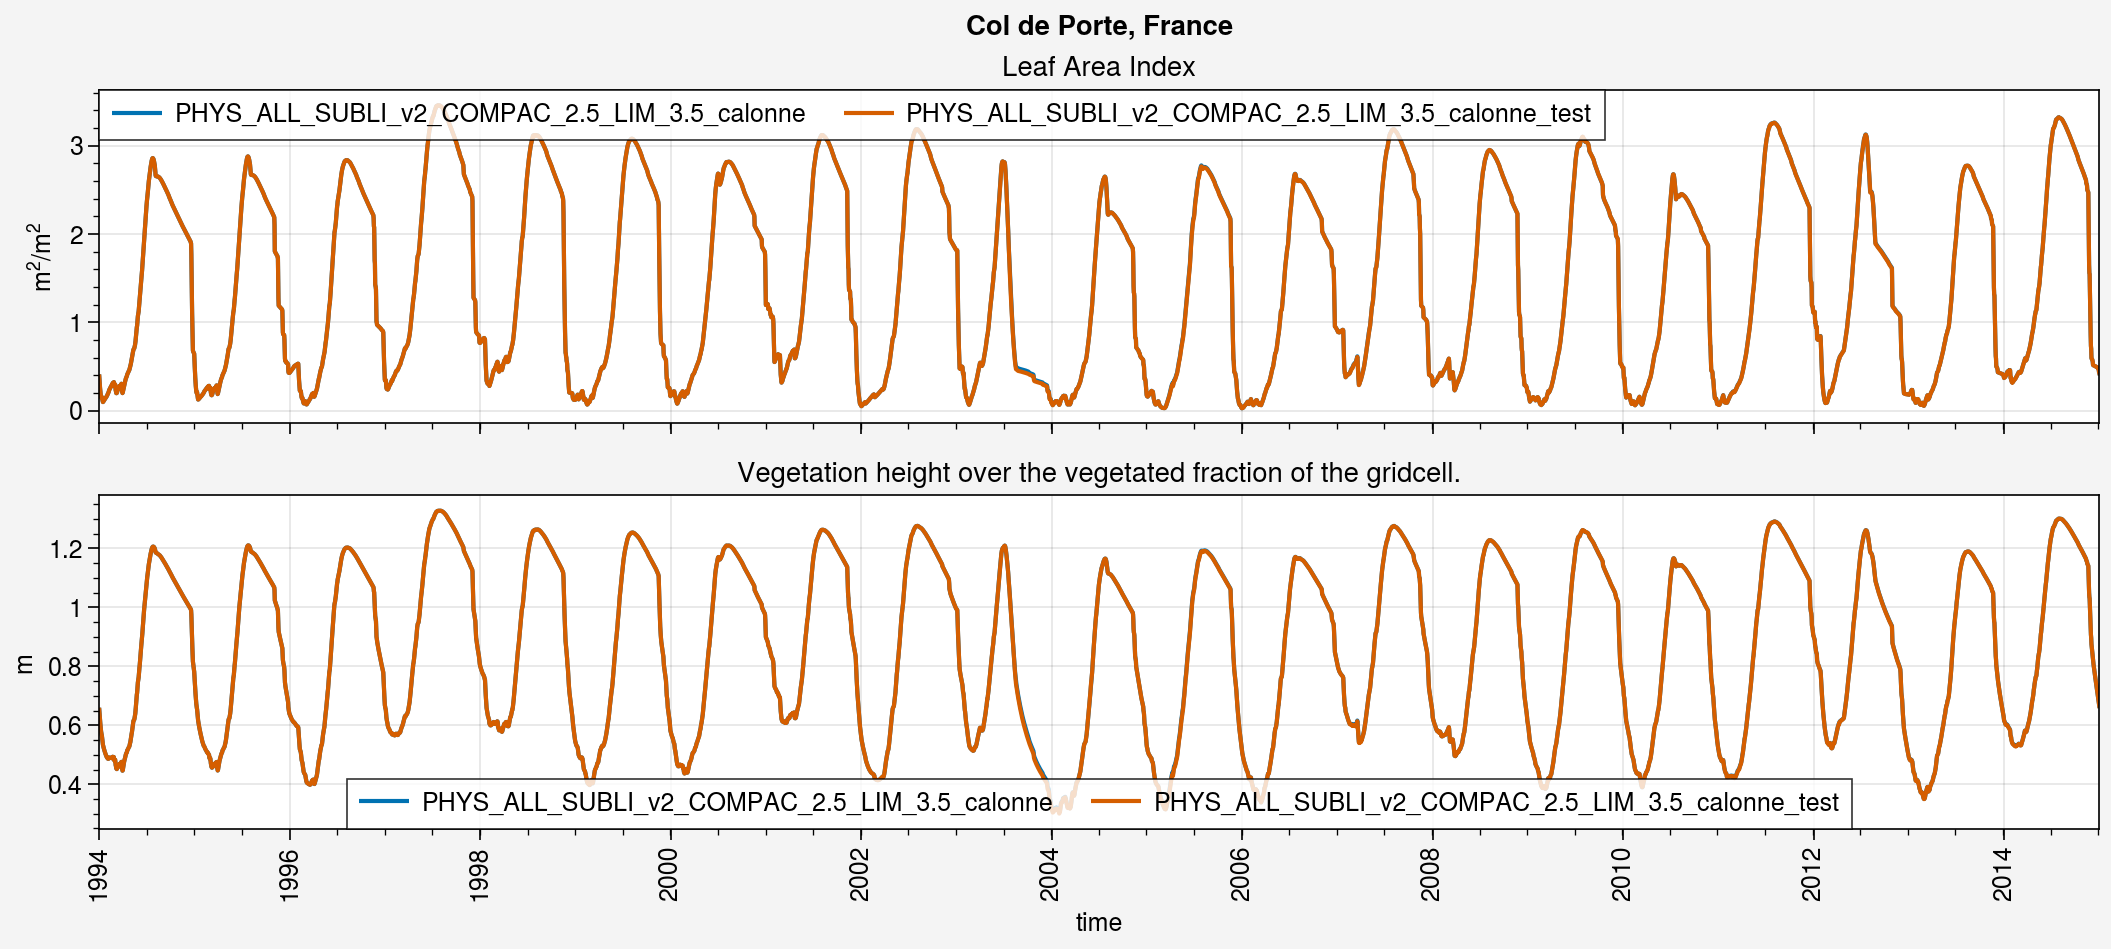

In [6]:
%matplotlib inline
fig, axs = pplt.subplots(ncols=1, nrows=2, refaspect=6, refwidth=10, sharey=0)

for ds_d, label in zip(ds_d_list, labels):
    axs[0].plot(ds_d.lai, label=label)
    axs[1].plot(ds_d.vegHeight, label=label)

axs[0].format(ylabel=ds_d_list[0].lai.units, title=ds_d_list[0].lai.long_name)
axs[1].format(ylabel=ds_d_list[0].vegHeight.units, title=ds_d_list[0].vegHeight.long_name)

for ax in axs:
    ax.legend()

fig.suptitle(site_longname)

Text(0.5, 0.98, 'Col de Porte, France (2002-2014)')

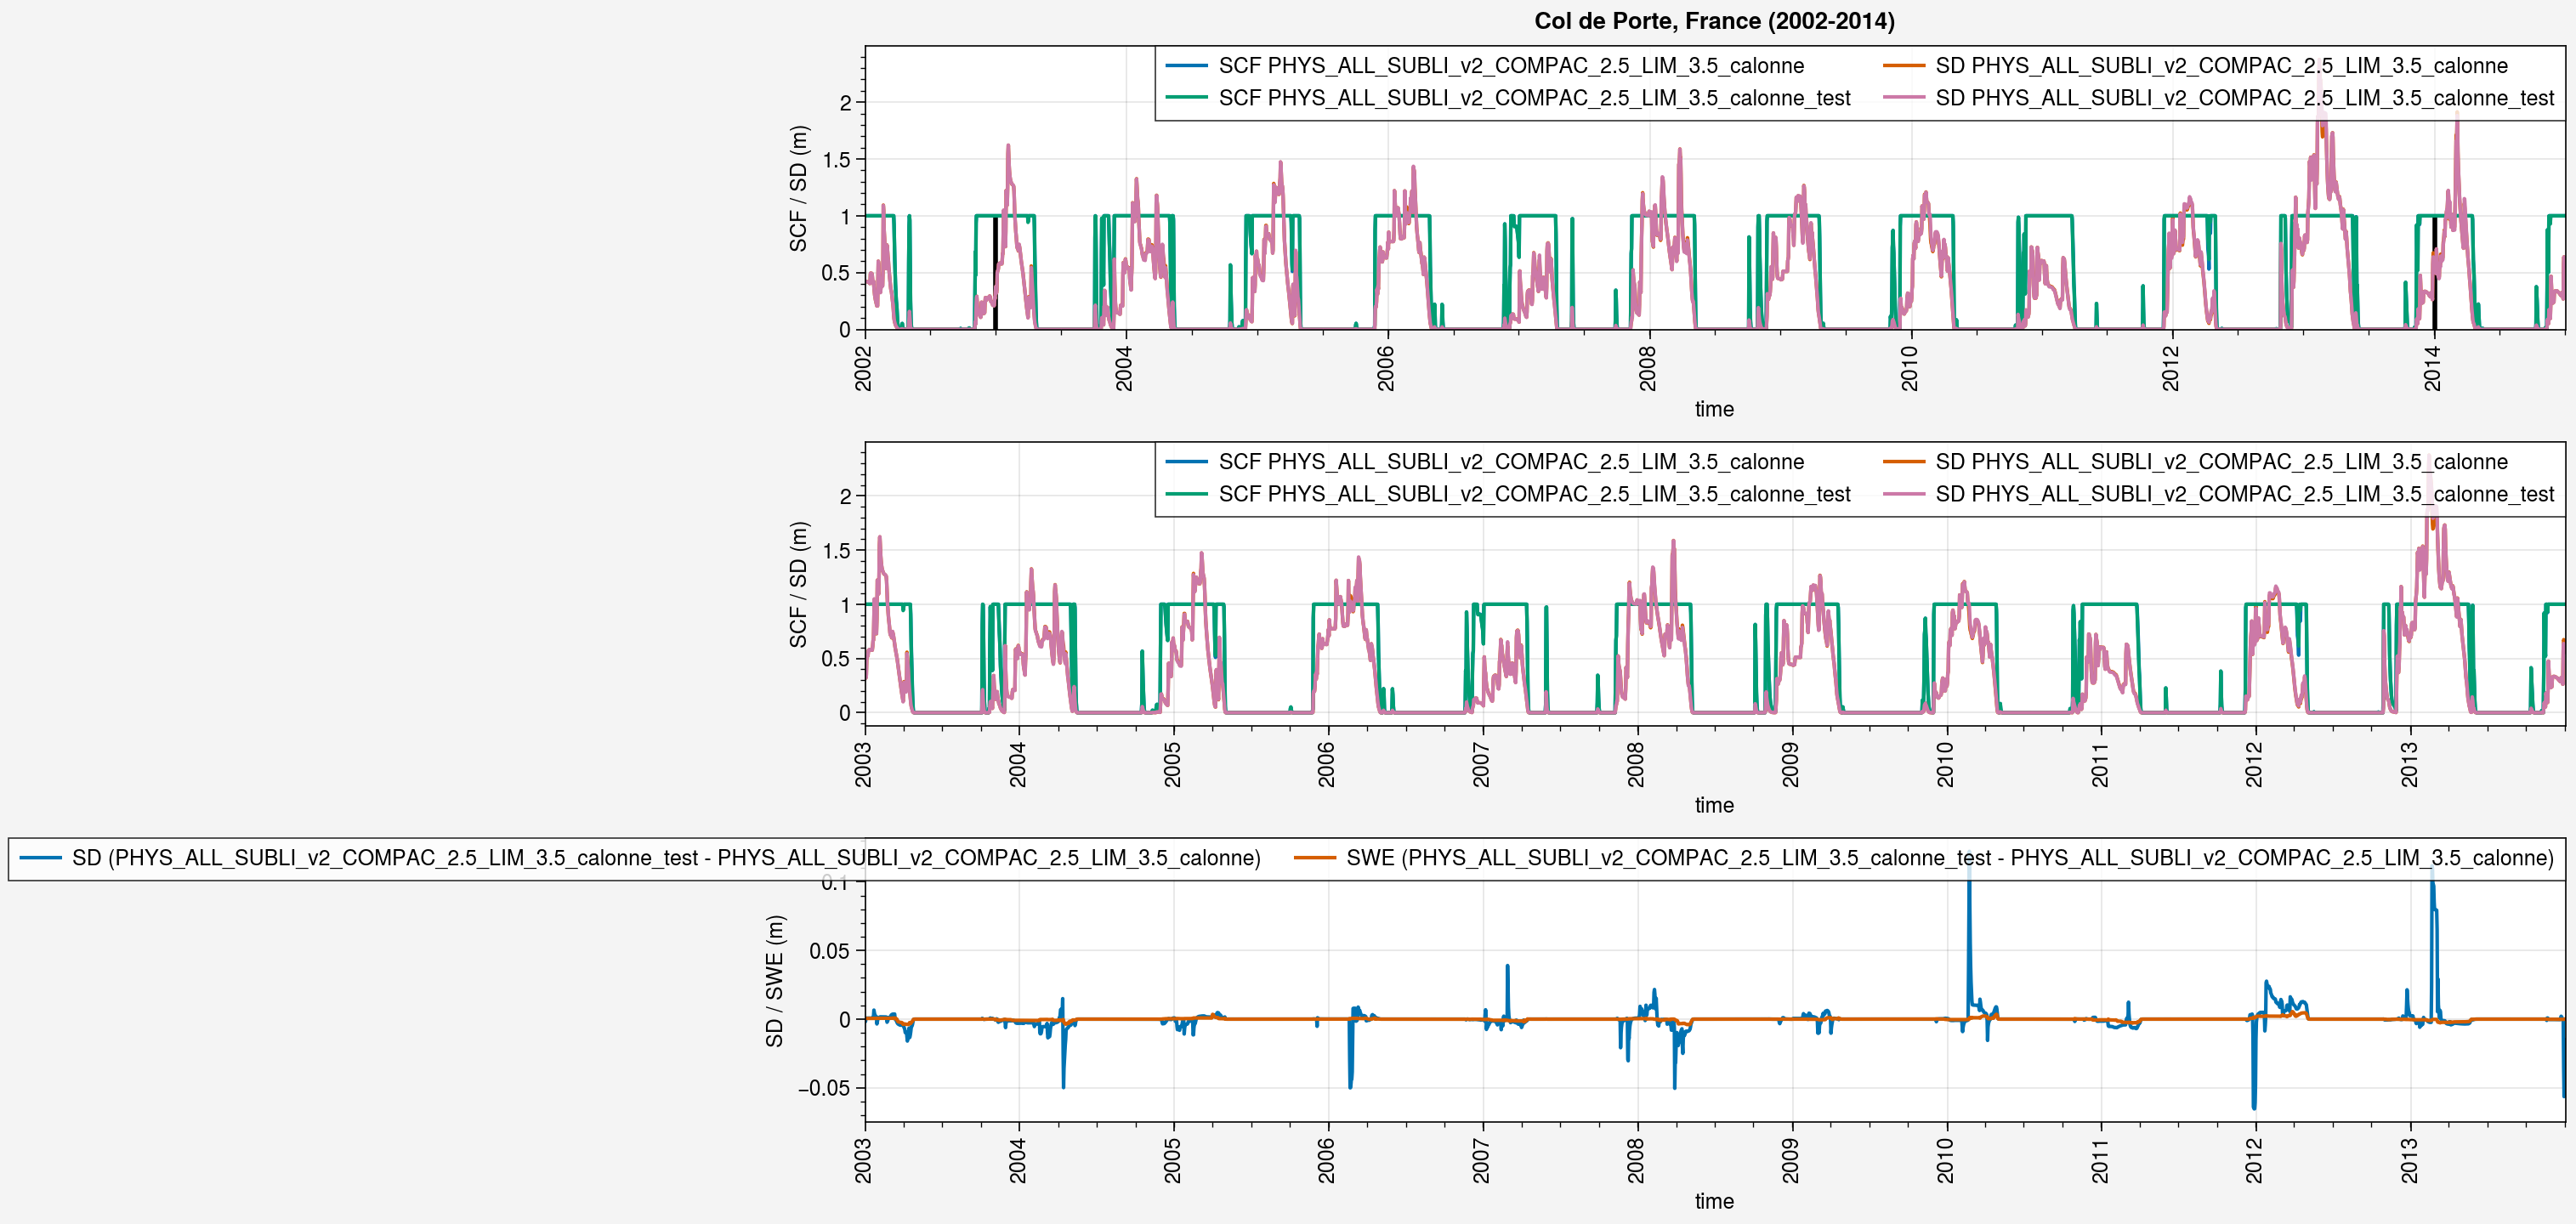

In [7]:
if len(labels) > 1:
    nrows = 3
else: 
    nrows = 2
    
fig, axs = pplt.subplots(ncols=1, nrows=nrows, refaspect=6, refwidth=10, share=0)

##################
### All period ###
##################
start = str(y_start)
end = str(y_end)

for ds_d, label in zip(ds_d_list, labels):
    axs[0].plot(ds_d.snc.sel(time=slice(start,end)), label='SCF '+label)
    axs[0].plot(ds_d.snd.sel(time=slice(start,end)), label='SD '+label)

axs[0].legend(ncols=2, loc='ur')
axs[0].format(
    ylabel='SCF / SD (m)'
)


############
### Zoom ###
############
start = str(y_start+1)
end = str(y_end-1)

for ds_d, label in zip(ds_d_list, labels):
    axs[1].plot(ds_d.snc.sel(time=slice(start,end)), label='SCF '+label)
    axs[1].plot(ds_d.snd.sel(time=slice(start,end)), label='SD '+label)

axs[0].vlines(ds_d_list[0].sel(time=slice(start,end)).time[0], ds_d_list[0].snc.min(), ds_d_list[0].snc.max(), color='k', lw=2)
axs[0].vlines(ds_d_list[0].sel(time=slice(start,end)).time[-1], ds_d_list[0].snc.min(), ds_d_list[0].snc.max(), color='k', lw=2)

axs[1].legend(ncols=2, loc='ur')
axs[1].format(
    ylabel='SCF / SD (m)'
)

if nrows == 3:
    #####################
    ### SWE / SD diff ###
    #####################
    axs[2].plot((ds_d_list[1]-ds_d_list[0]).snd.sel(time=slice(start,end)), label='SD ('+labels[1]+' - '+labels[0]+')')
    axs[2].plot(((ds_d_list[1]-ds_d_list[0]).snw*1e-3).sel(time=slice(start,end)), label='SWE ('+labels[1]+' - '+labels[0]+')')
    
    axs[2].legend(ncols=2)
    axs[2].format(
        ylabel='SD / SWE (m)'
    )

fig.suptitle(site_longname+' ('+str(y_start)+'-'+str(y_end)+')')


## Compare with obs

In [8]:
path_obs = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all'

ds_h_obs = xr.open_dataset(path_obs+'/obs_insitu_'+site+'_1994_'+str(y_end)+'.nc').load()
ds_d_obs = ds_h_obs.resample(time='D').mean().load()
ds_h_obs

<xarray.Dataset> Size: 8MB
Dimensions:   (time: 175320, sdepth: 3)
Coordinates:
  * time      (time) datetime64[ns] 1MB 1994-10-01T01:00:00 ... 2014-10-01
  * sdepth    (sdepth) float32 12B 0.1 0.2 0.5
Data variables:
    albs      (time) float32 701kB nan nan nan nan nan ... nan nan nan nan nan
    snd_auto  (time) float32 701kB nan nan nan nan nan ... nan nan nan nan nan
    snd_man   (time) float32 701kB nan nan nan nan nan ... nan nan nan nan nan
    snw_auto  (time) float32 701kB nan nan nan nan nan ... nan nan nan nan nan
    snw_man   (time) float32 701kB nan nan nan nan nan ... nan nan nan nan nan
    ts        (time) float32 701kB 11.12 9.668 8.029 ... 7.532 7.532 8.029
    tsl       (time, sdepth) float32 2MB 11.95 12.28 12.23 ... 12.95 12.83 12.8

### SD

In [9]:
tot_year = y_end - y_start + 1
gap = 2
years = pplt.arange(y_start, y_end)
years

array([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014])

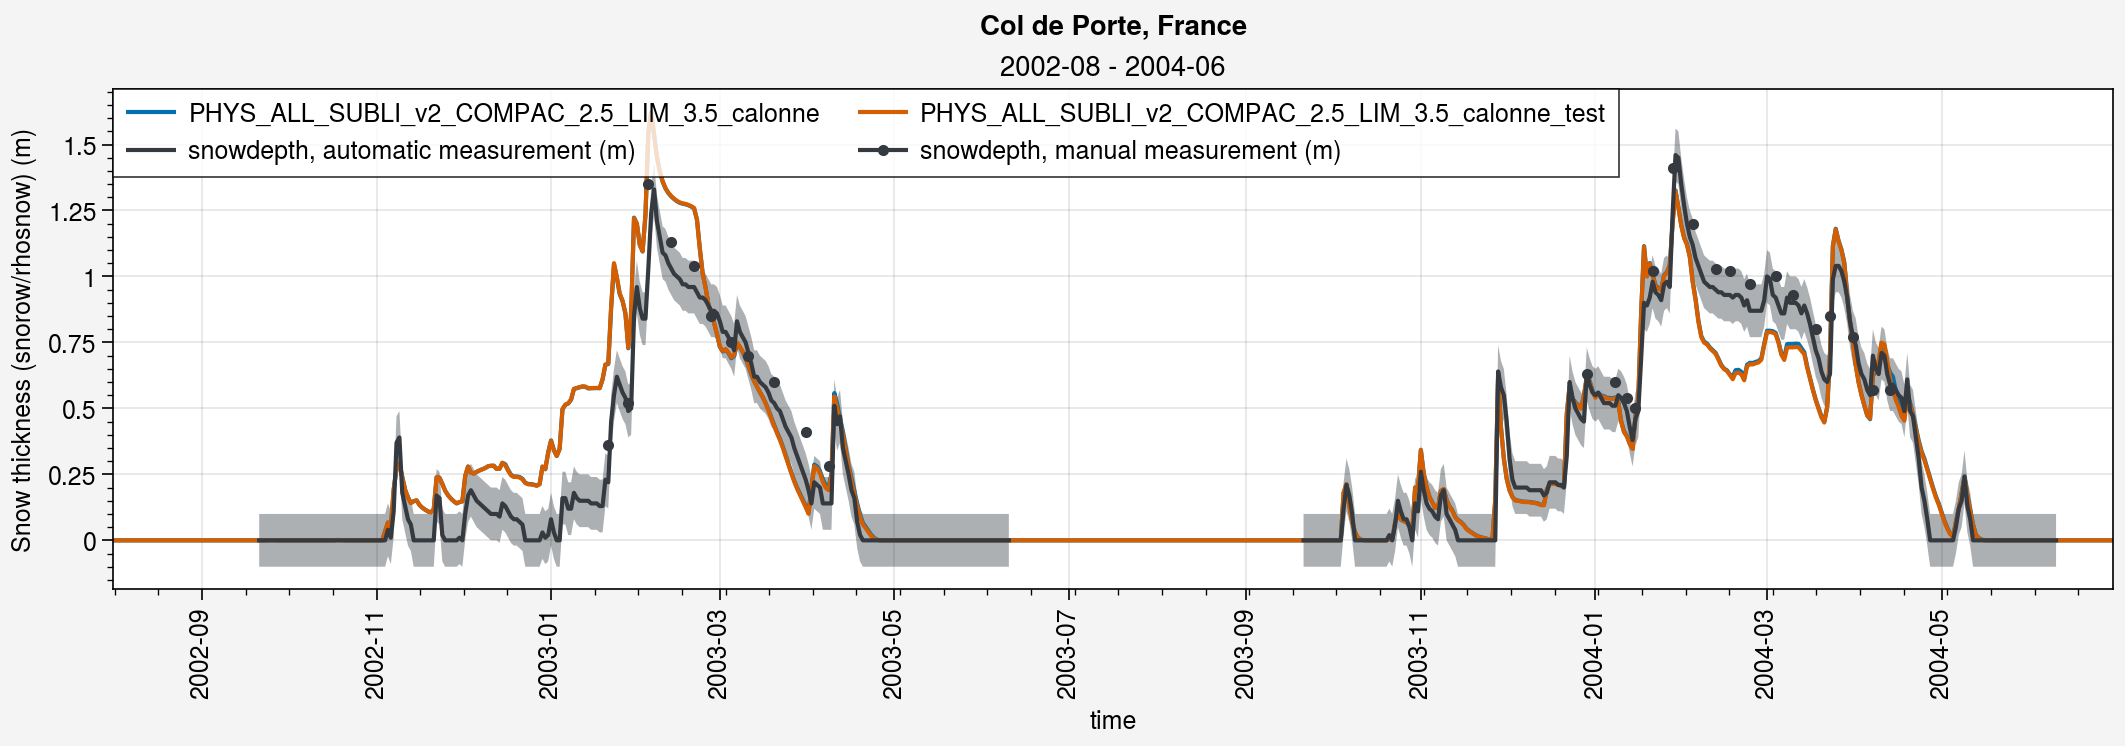

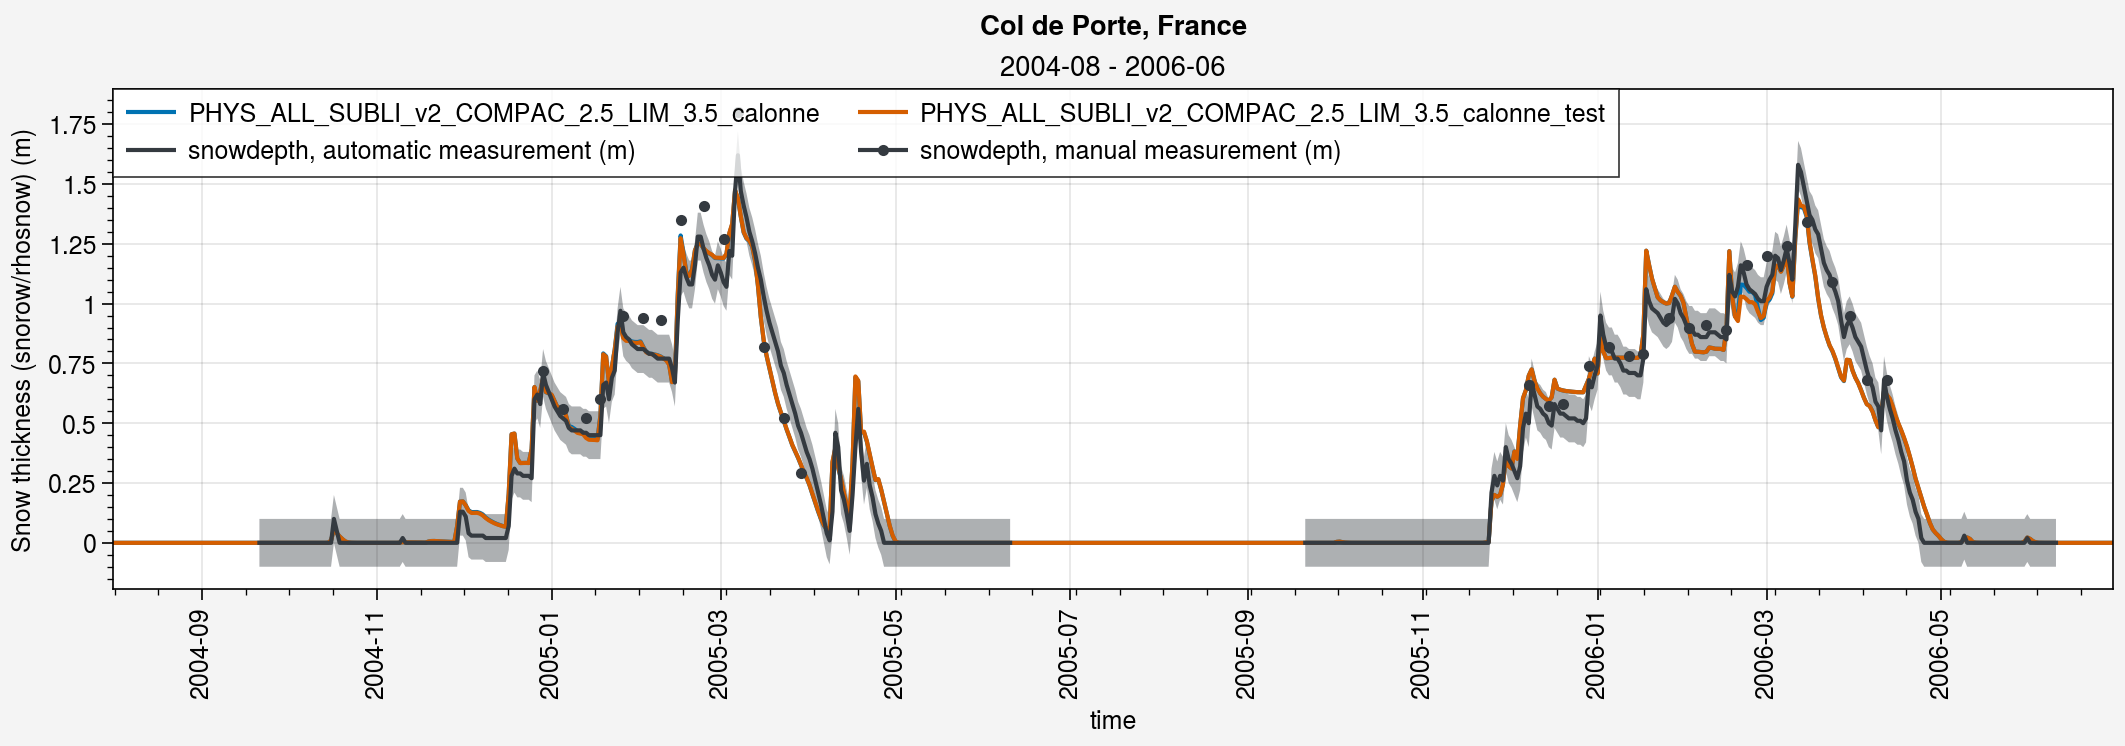

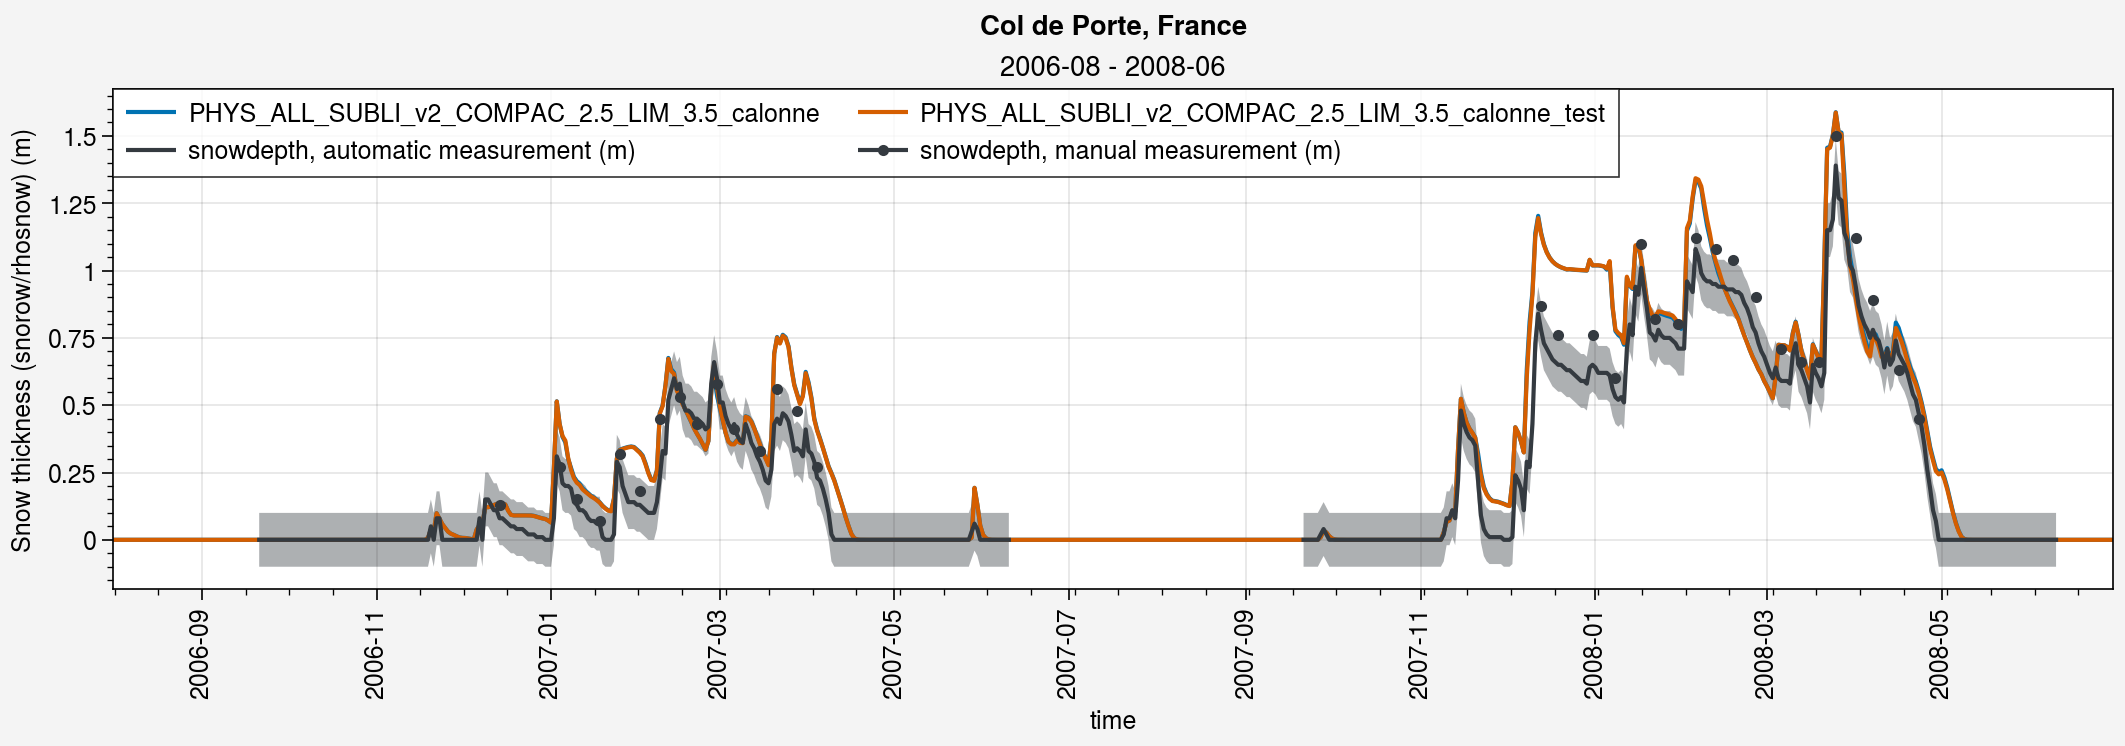

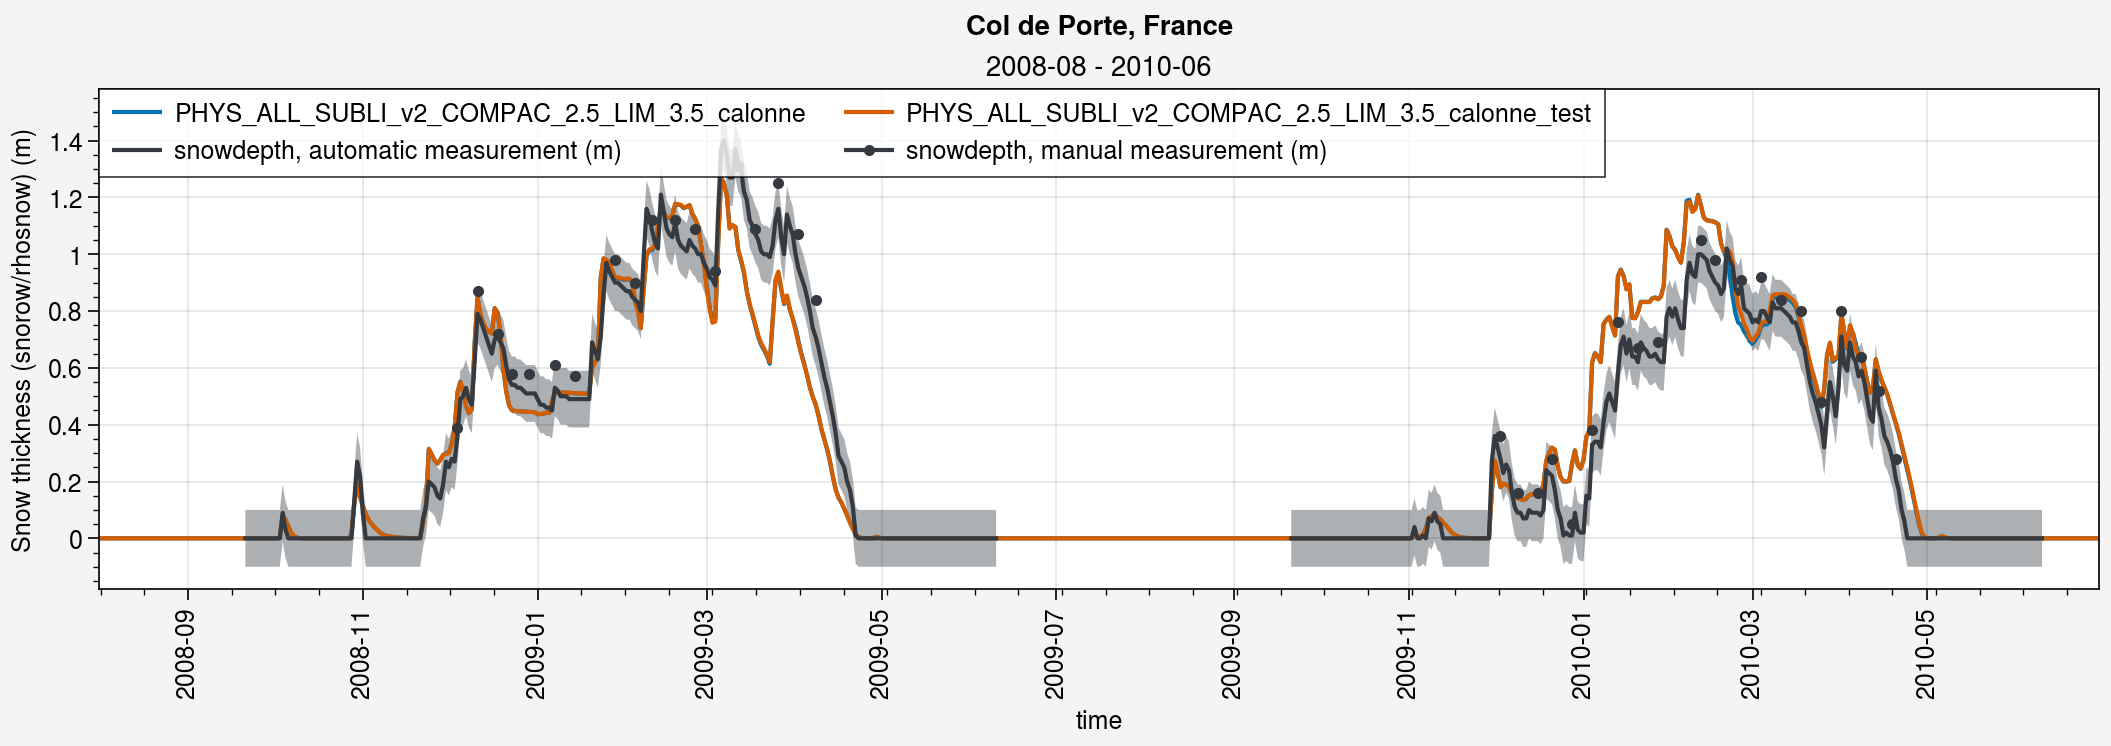

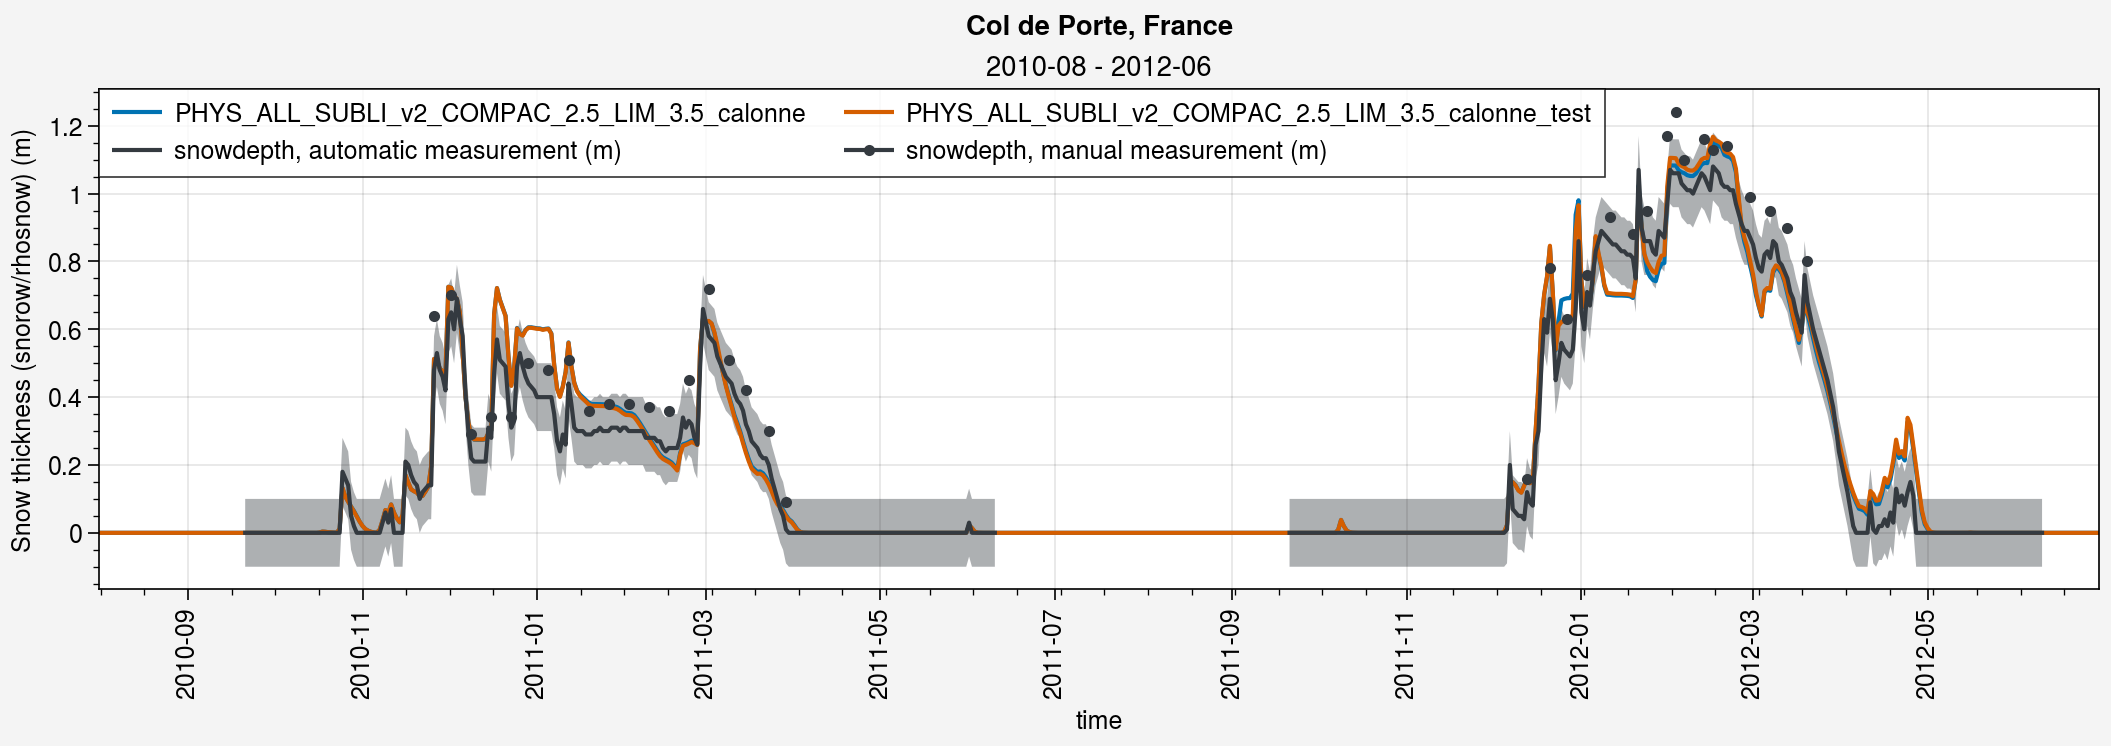

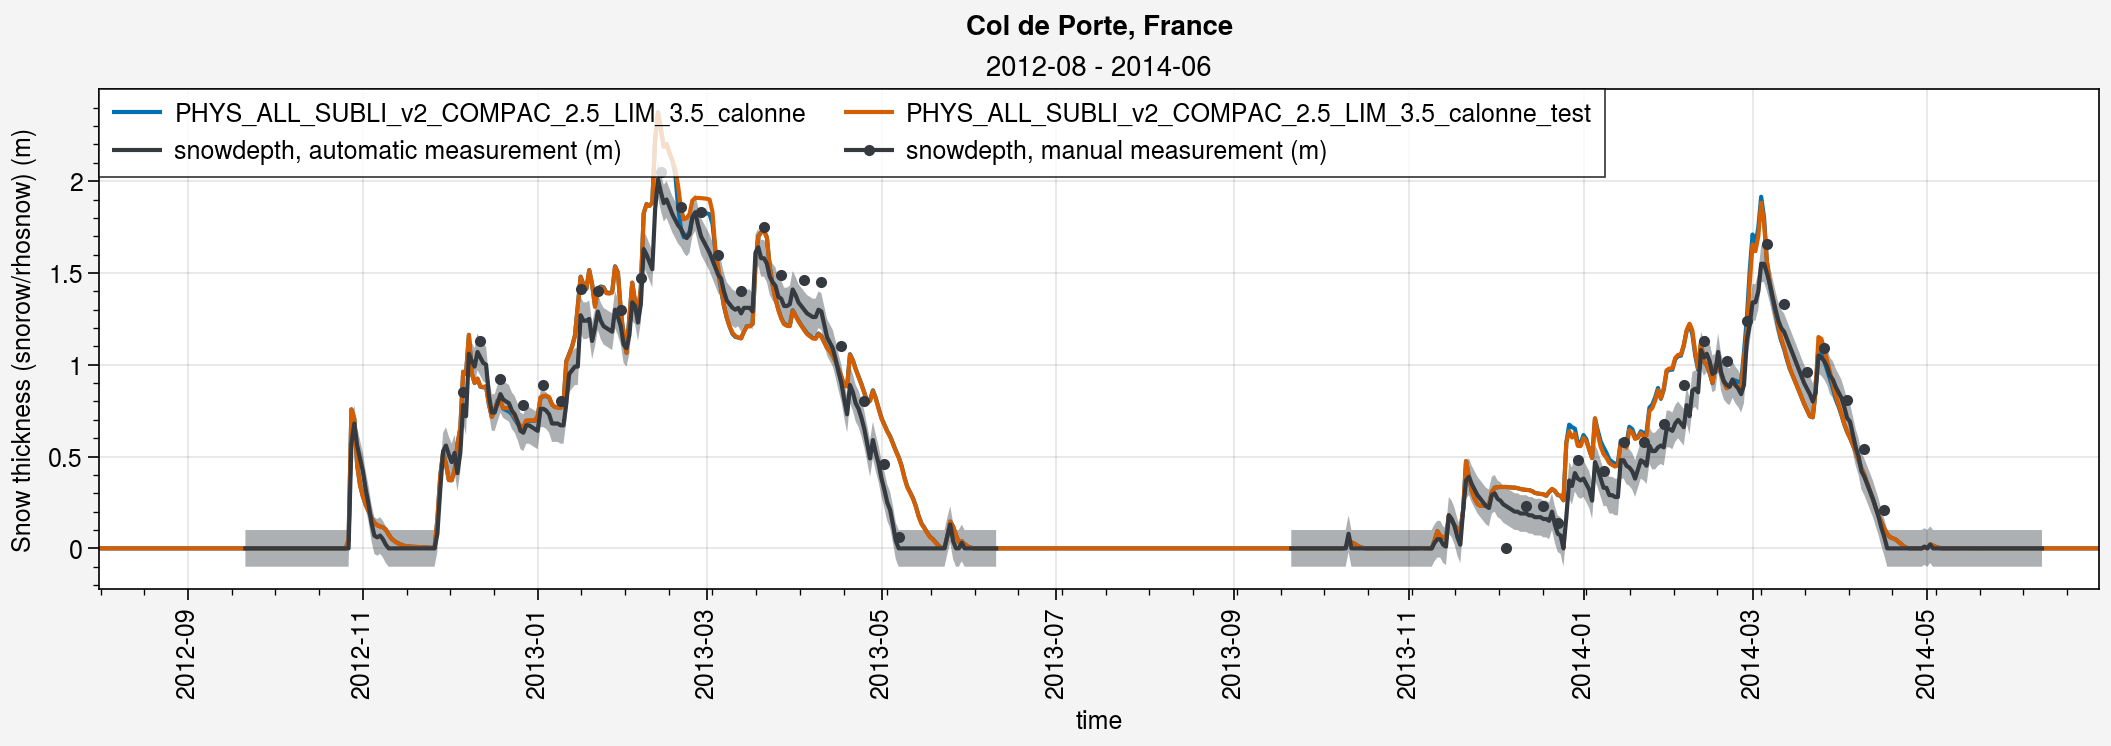

In [10]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-06')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-06')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.snd.sel(time=period), label=label)
    
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
        np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
    axs[0].plot(ds_d_obs.snd_auto.sel(time=period), shadedata=shadedata, color=color_obs)
    axs[0].plot(ds_d_obs.snd_man.sel(time=period), marker='.', color=color_obs)    

    # Veg
    # axs[0].plot(ds_d_list[0].vegHeight.sel(time=period), label='vegHeight', color='green', ls='-', lw=0.5, alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop)
    
    fig.suptitle(site_longname)


### SWE

In [11]:
tot_year = y_end - y_start + 1
gap = 6
years = pplt.arange(y_start, y_end)
years

array([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014])

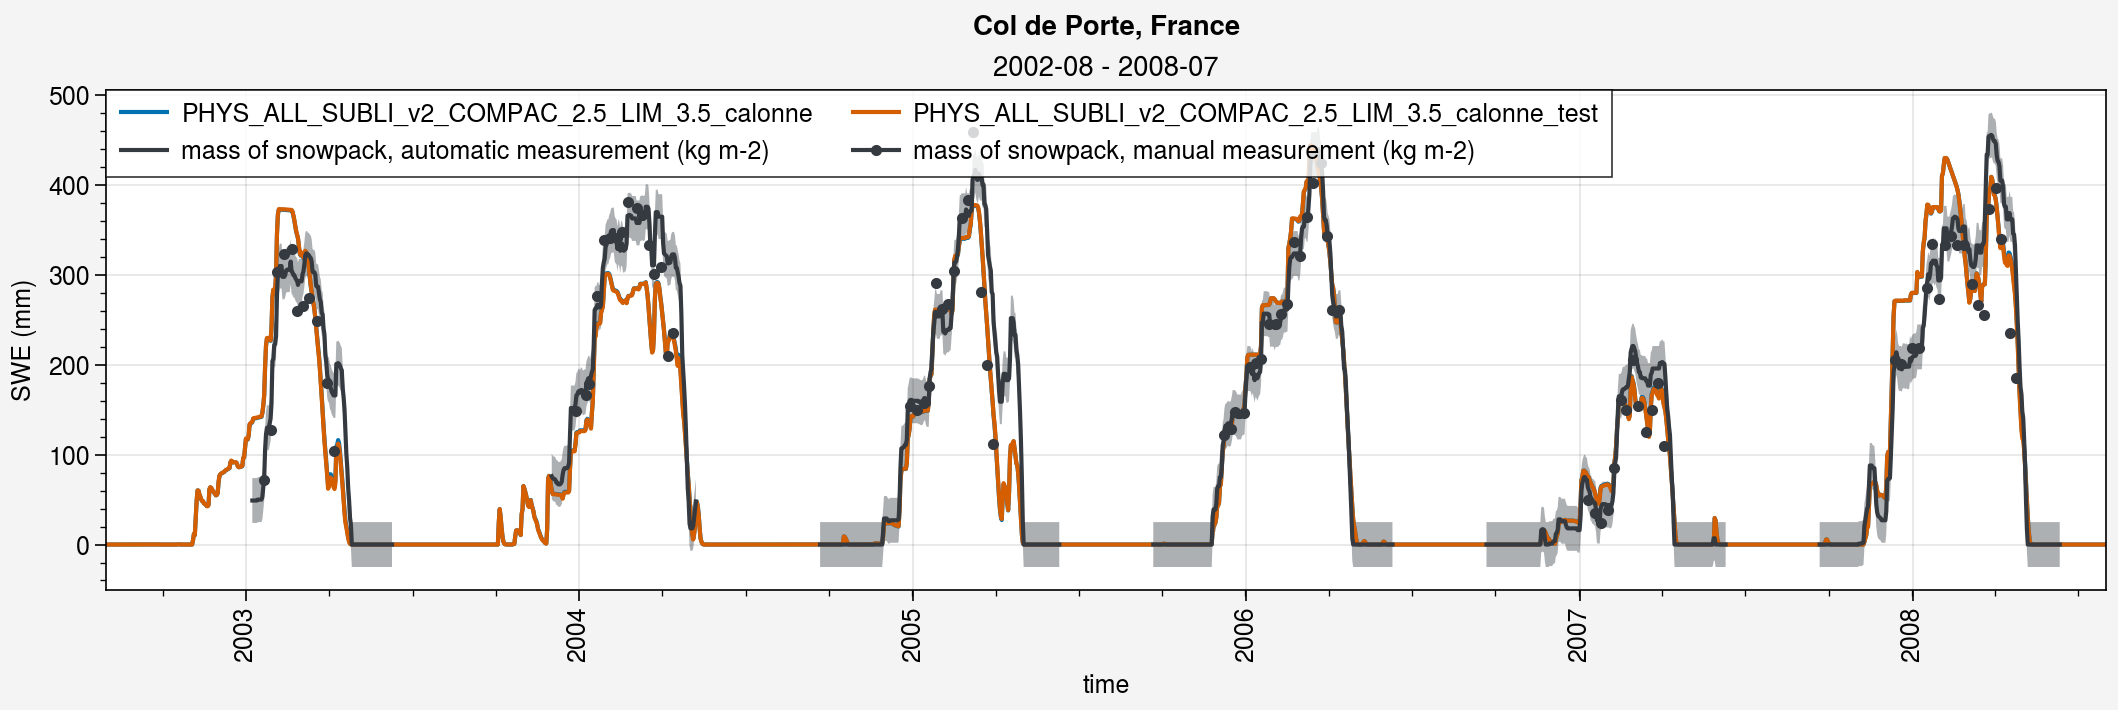

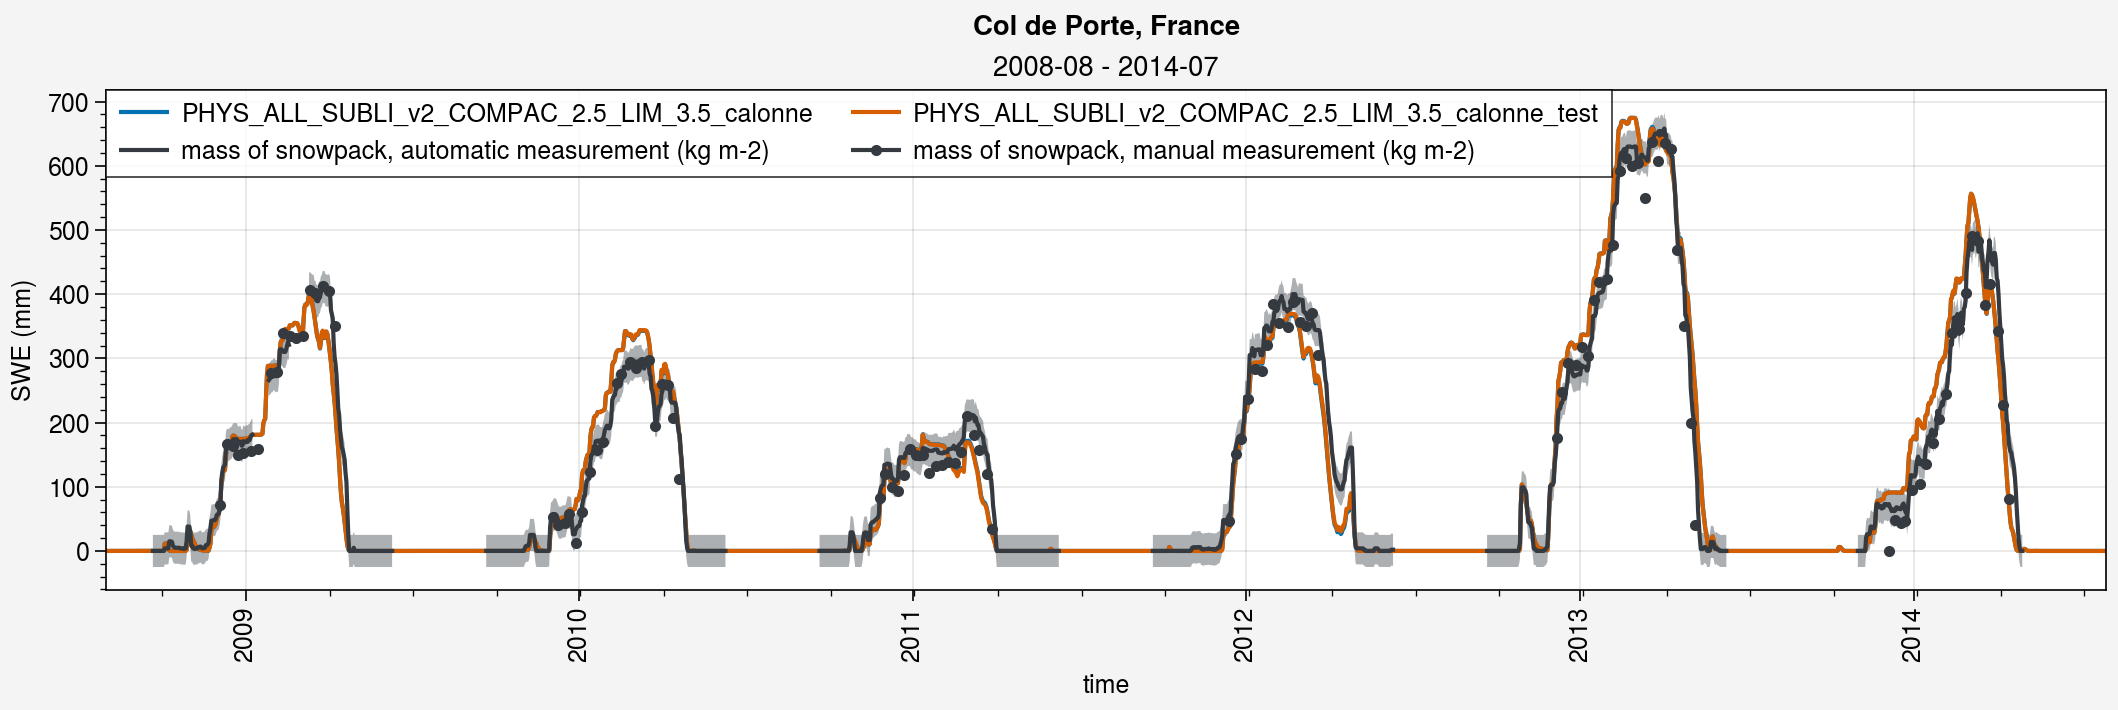

In [12]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.snw.sel(time=period), label=label)
    
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_obs.snw_auto.sel(time=period).values+25, axis=0),
        np.expand_dims(ds_d_obs.snw_auto.sel(time=period).values-25, axis=0),), axis=0)
    axs[0].plot(ds_d_obs.snw_auto.sel(time=period), shadedata=shadedata, color=color_obs)
    axs[0].plot(ds_d_obs.snw_man.sel(time=period), marker='.', color=color_obs)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='SWE (mm)')
    
    fig.suptitle(site_longname)


### Albedo

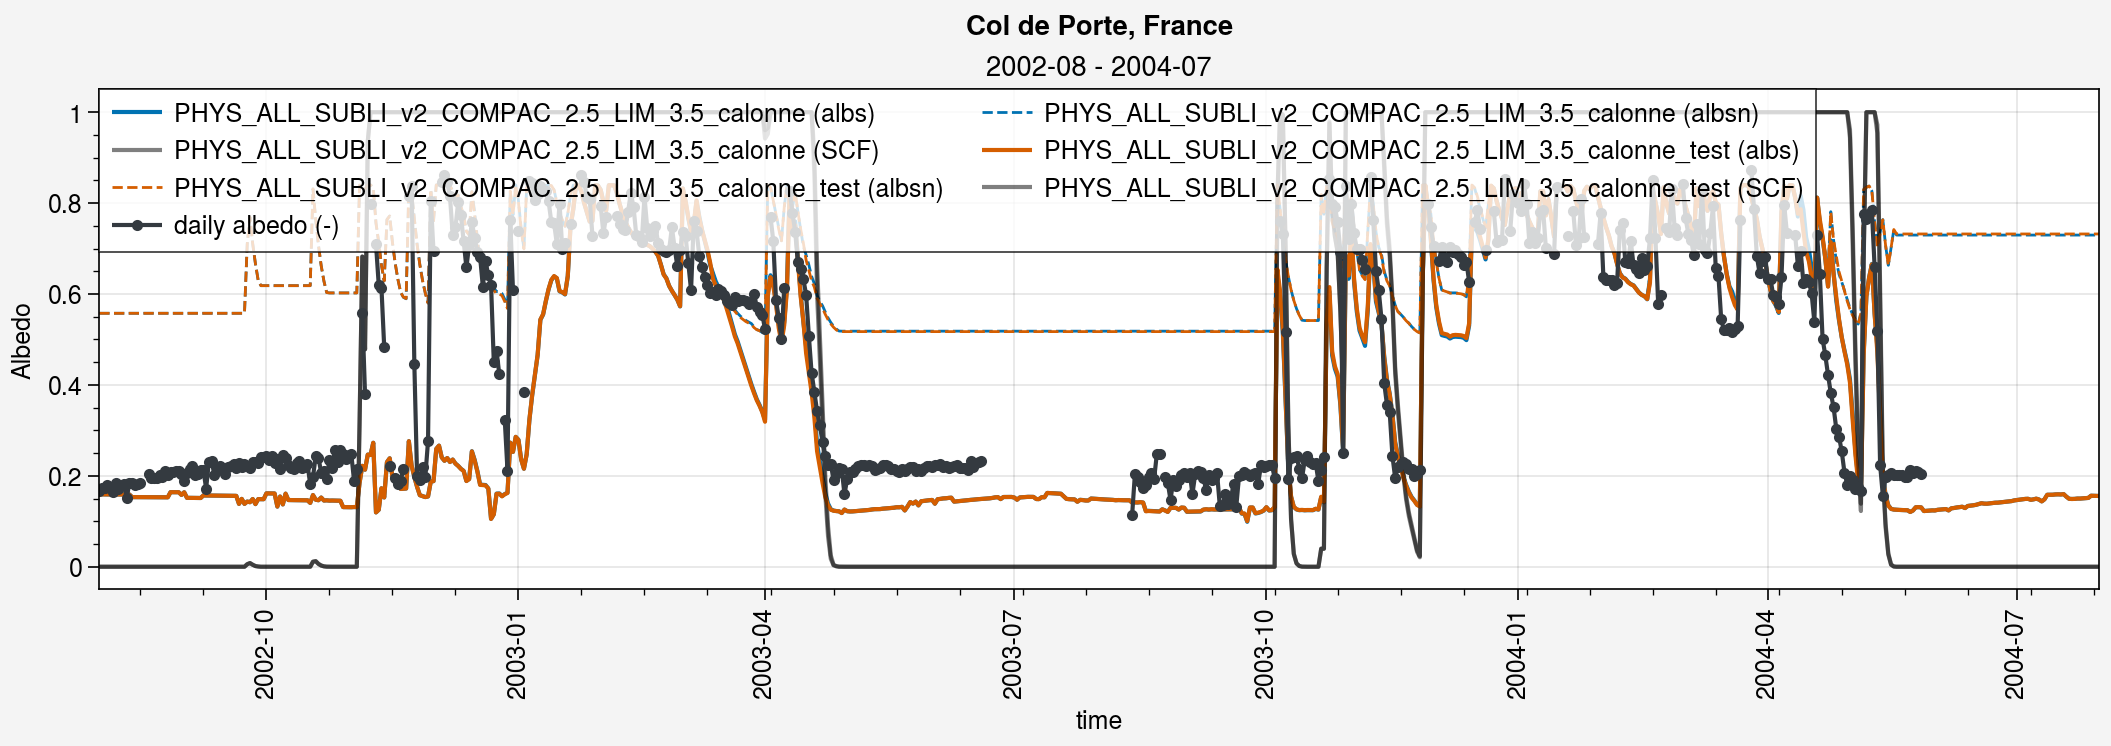

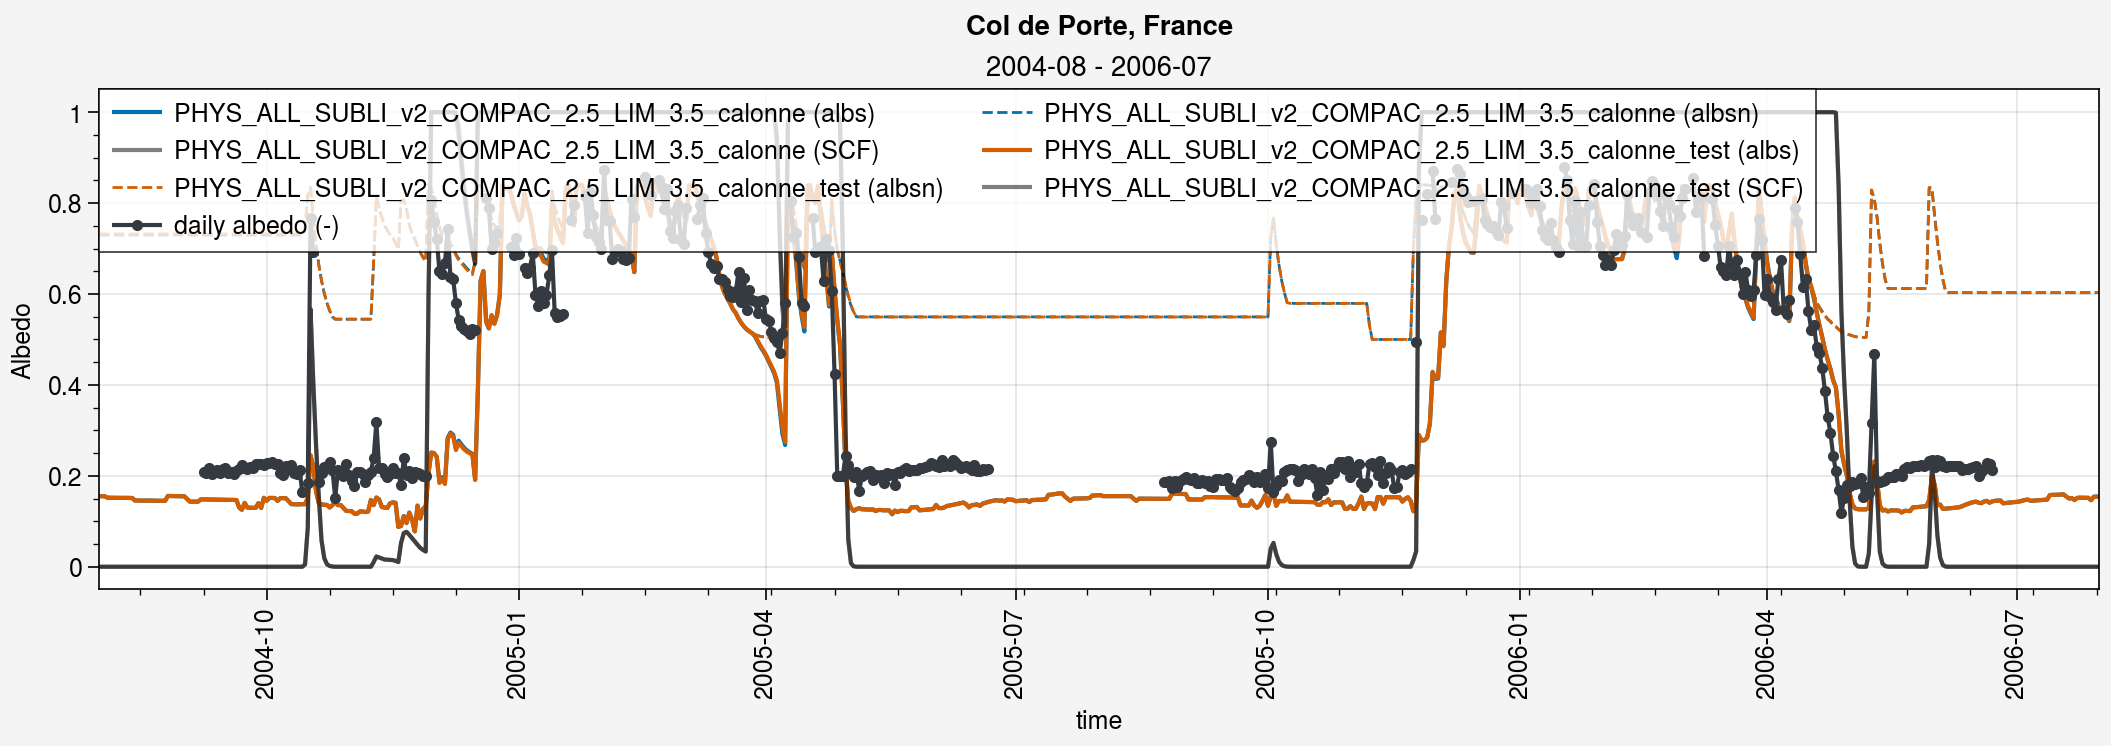

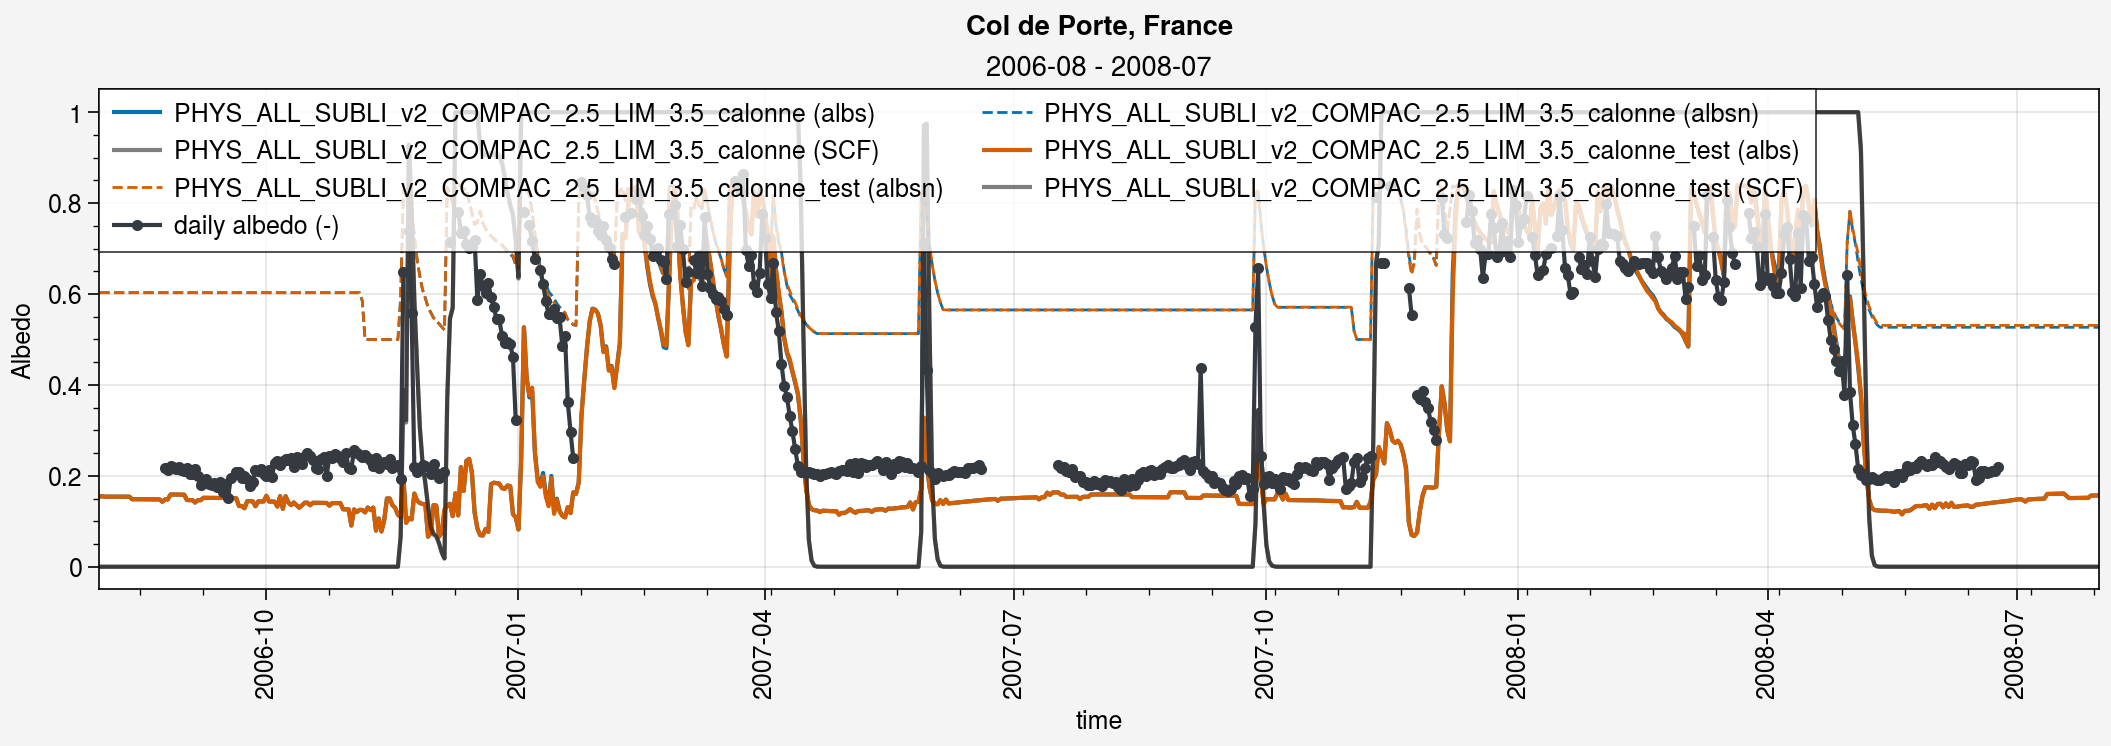

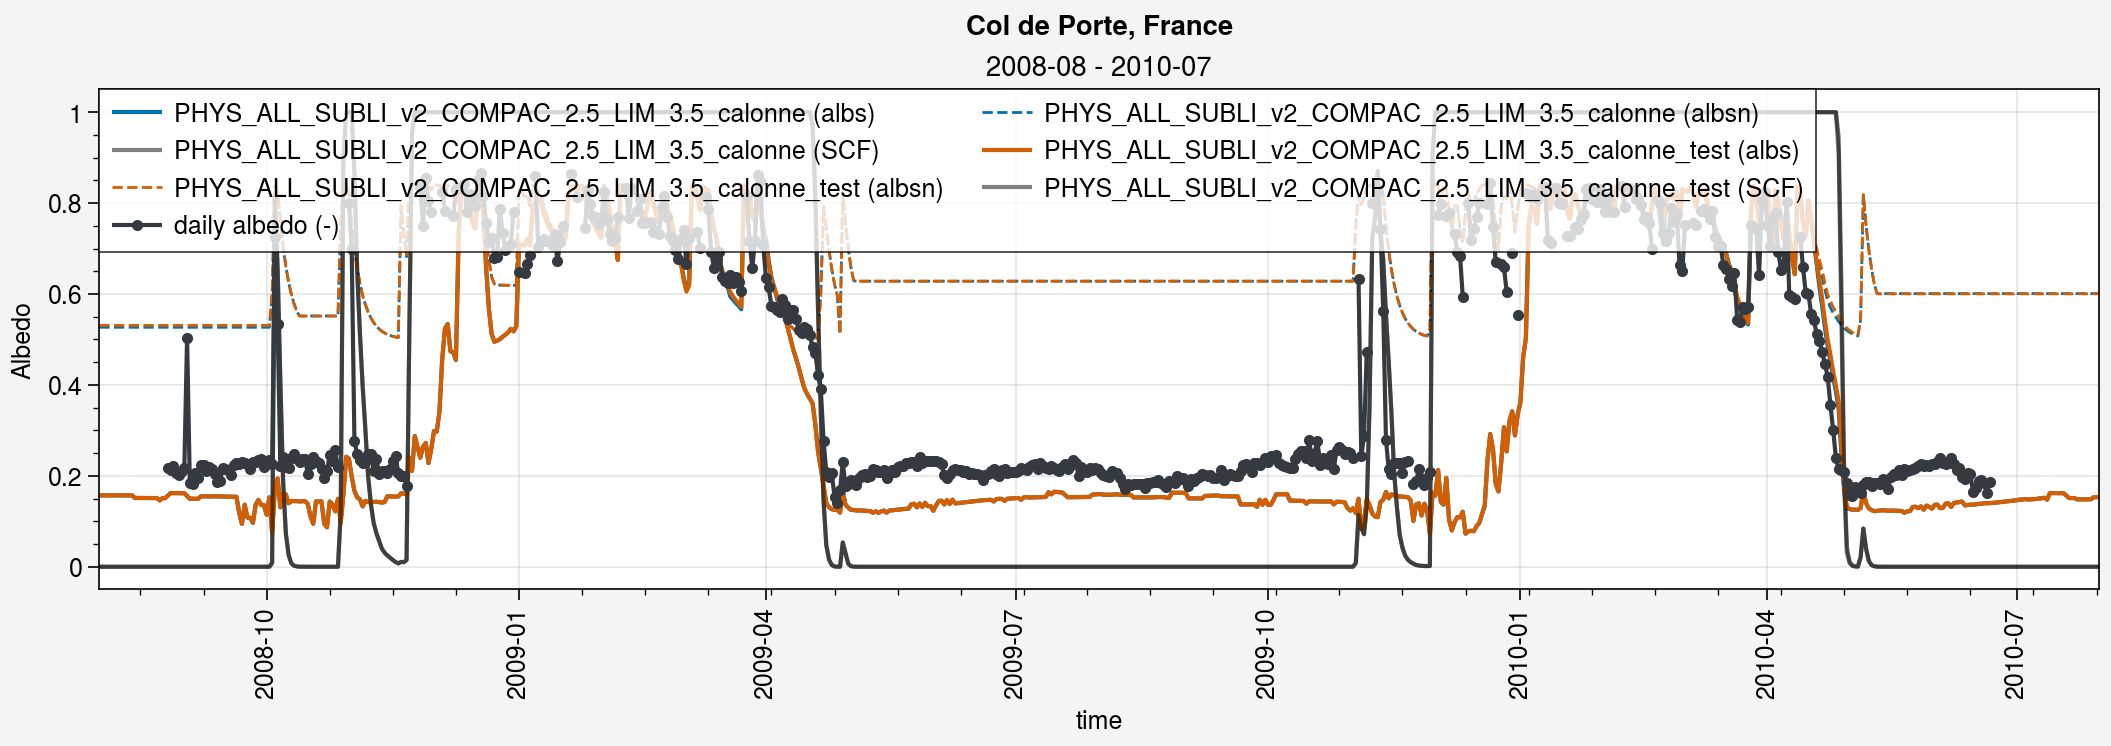

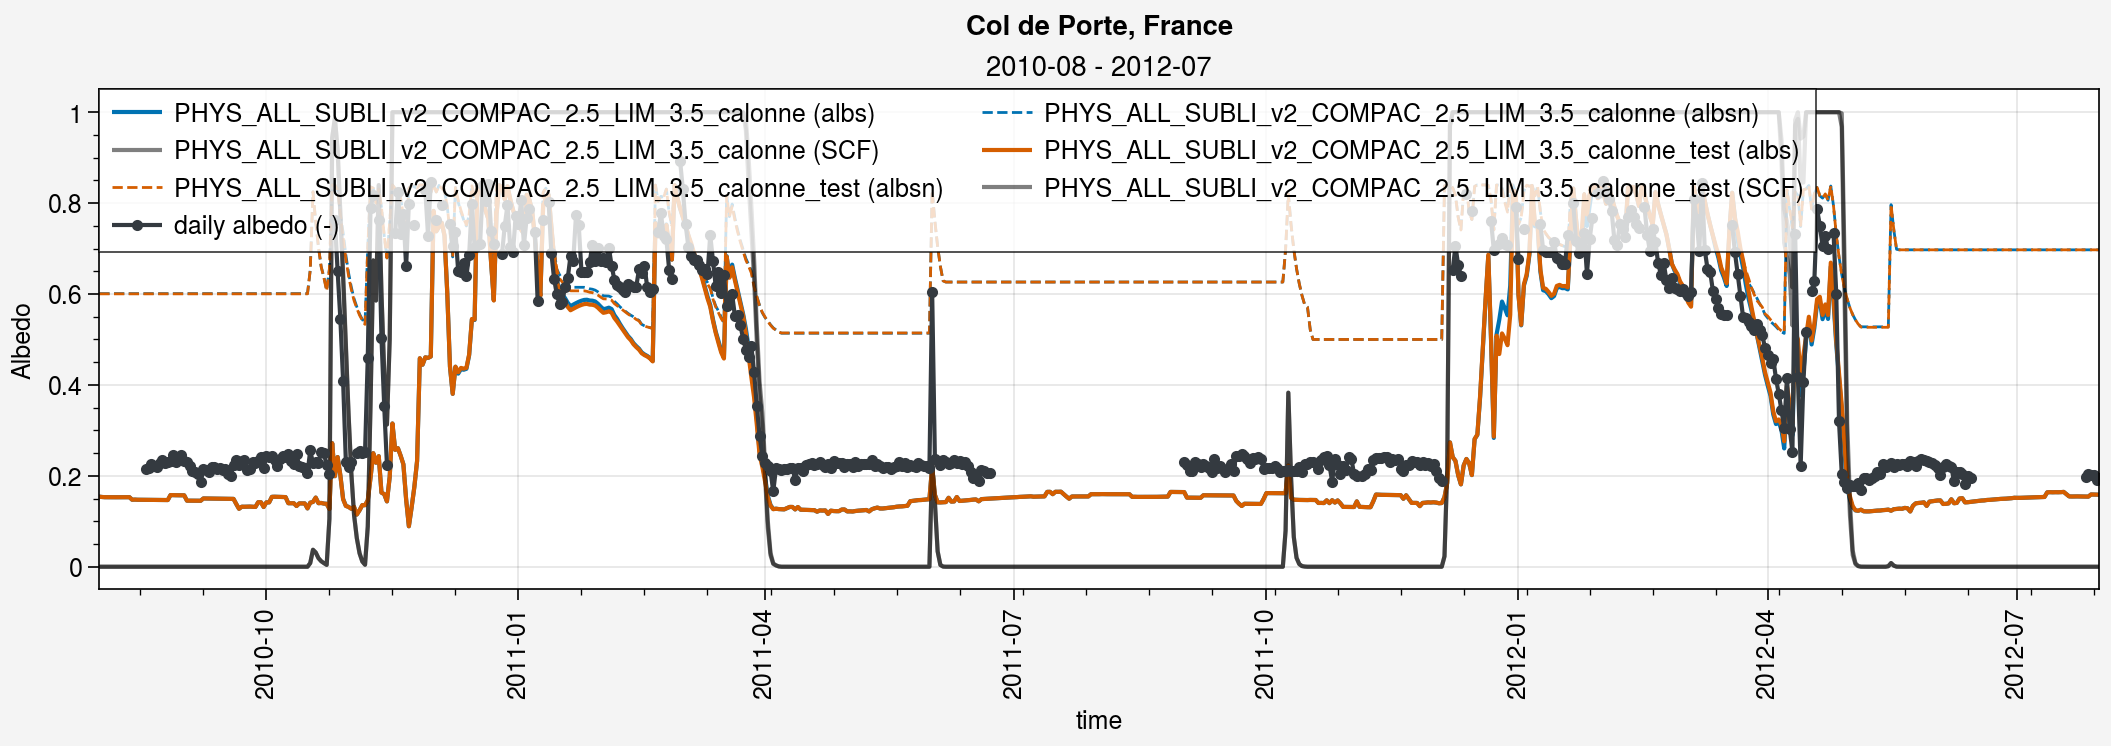

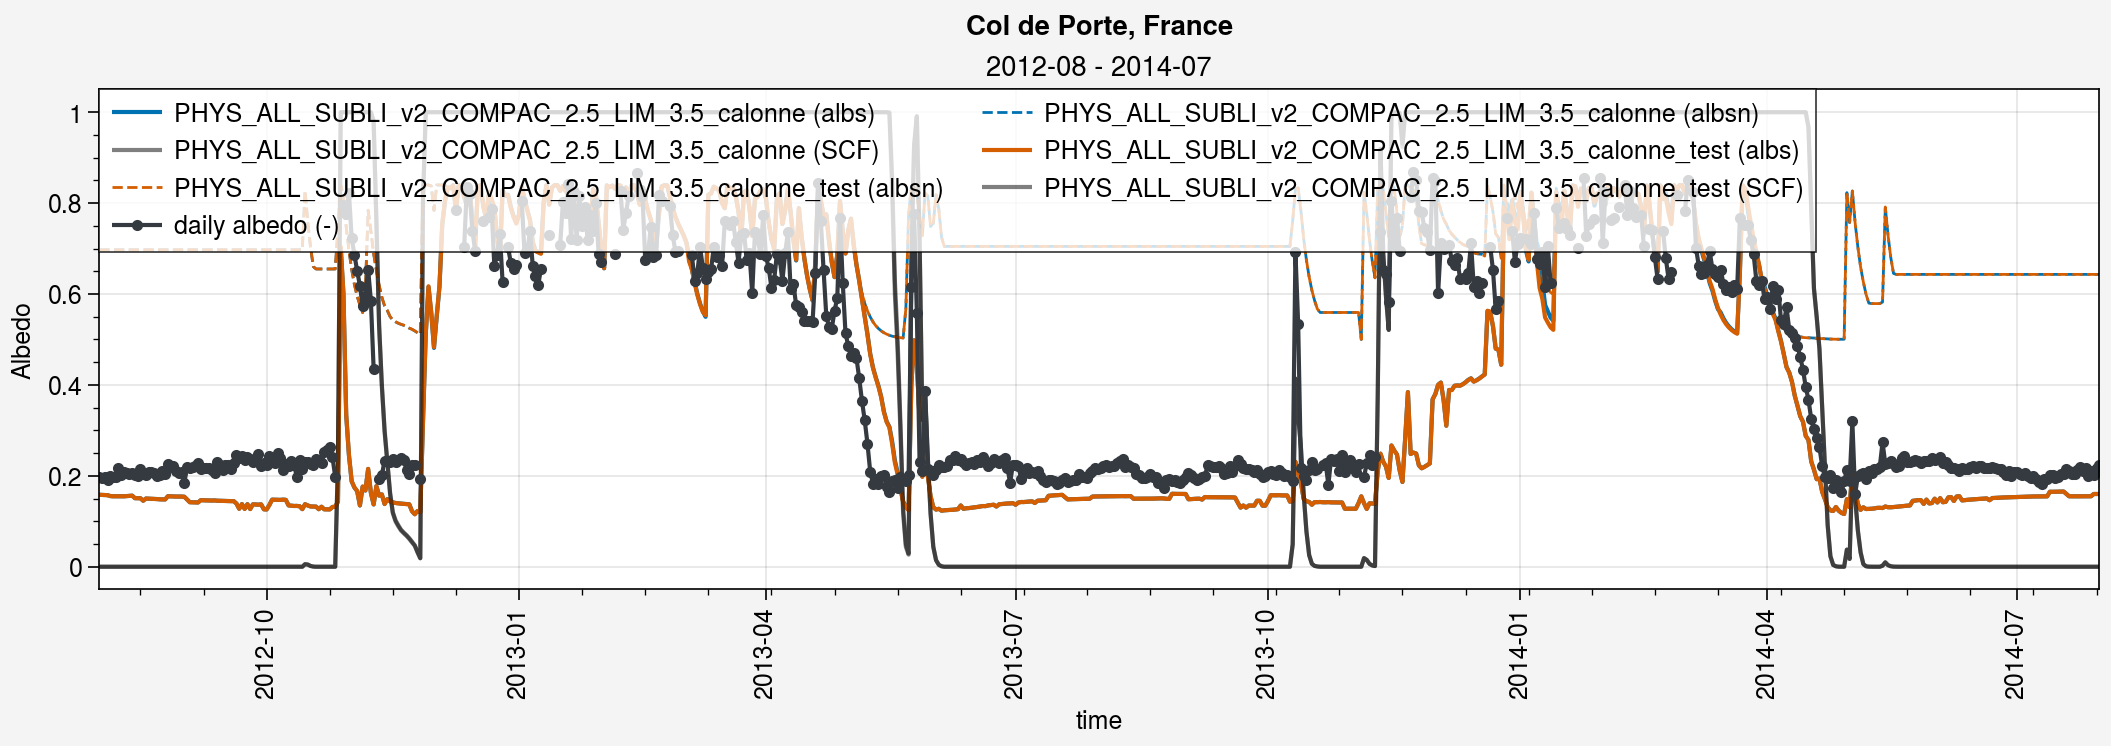

In [13]:
%matplotlib inline
gap = 2
color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    k = 0
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.albs.sel(time=period), label=label+' (albs)', color='C'+str(k))
        axs[0].plot(ds_d.albsn.sel(time=period), label=label+' (albsn)', color='C'+str(k), ls='--', lw=1)
        axs[0].plot(ds_d.snc.sel(time=period), label=label+' (SCF)', color='k', alpha=0.5)
        
        k+=1
    
    # Obs
    axs[0].plot(ds_d_obs.albs.sel(time=period), marker='.', color=color_obs)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Albedo')
    
    fig.suptitle(site_longname)


### Surface Temperature

Domine et al. ([2019](https://onlinelibrary.wiley.com/doi/abs/10.1029/2018MS001445)): "**Averaged over a period of several days the surface temperatures are essentially the same**. The amplitude variations are greater in the Alpine snowpack (Figure 8b) because the insulating layer at the top does not allow damping the air temperature variations by heat exchanges with the snowpack. This effect is more important in April and May, when daily temperature variations reach 20 °C, sometimes more. The absolute temperature differences reaches 4.7 °C on 8 February, when the temperature suddenly increases by 15 °C in 5 hr, and the surface temperature of the Alpine snowpack increases more rapidly."

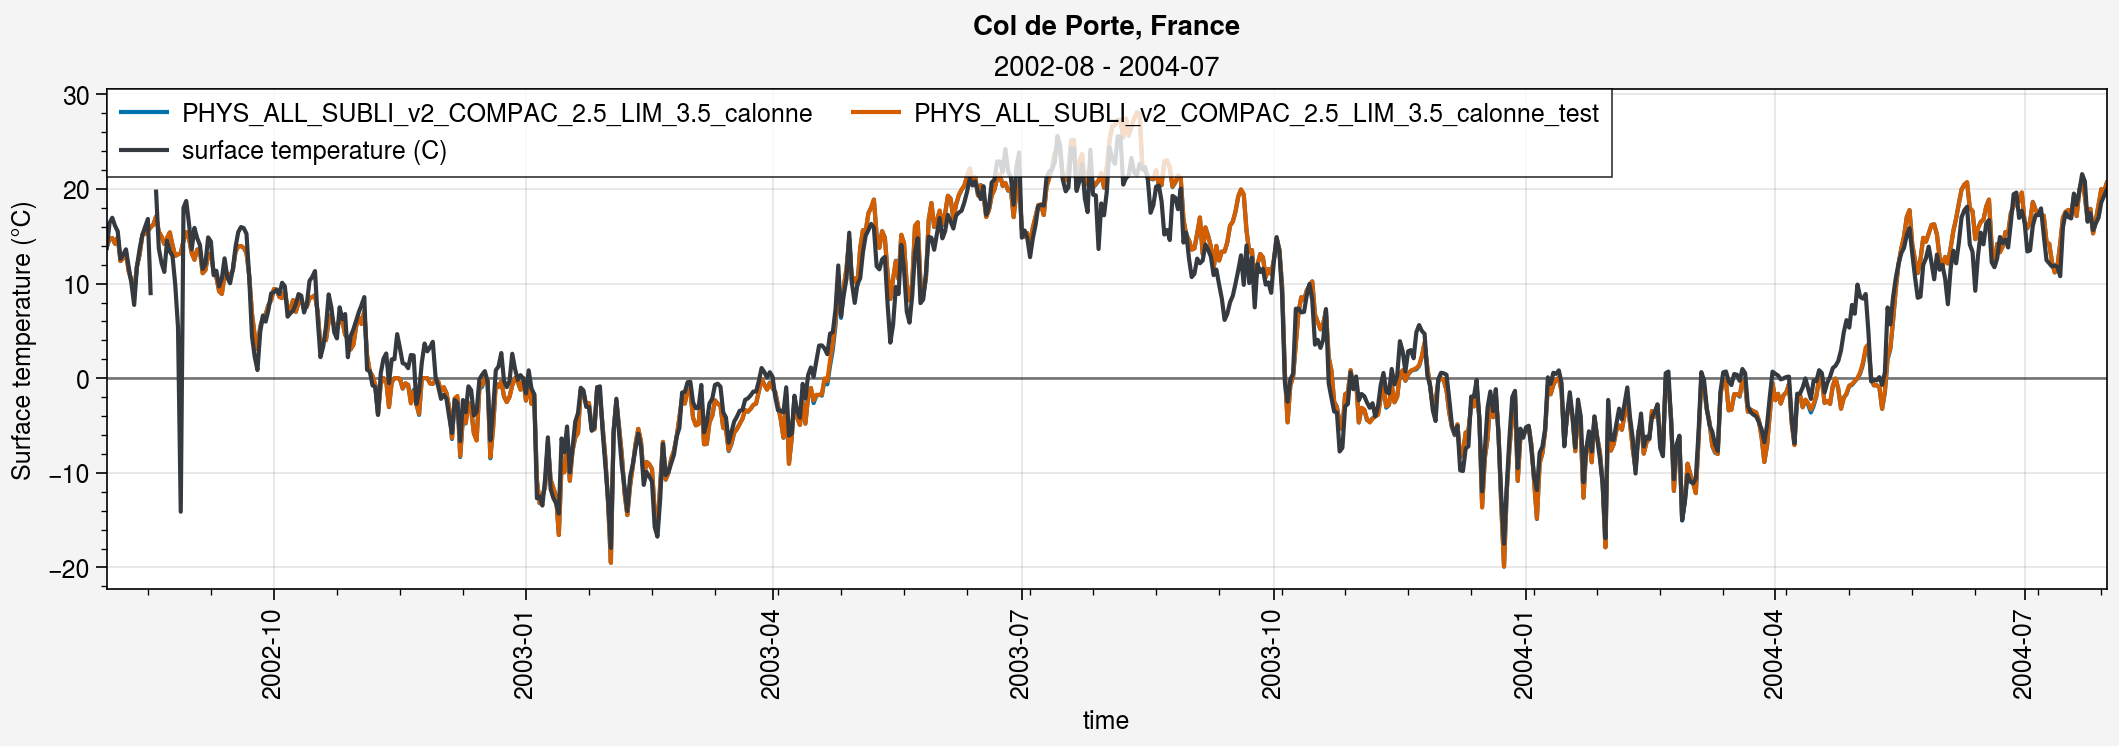

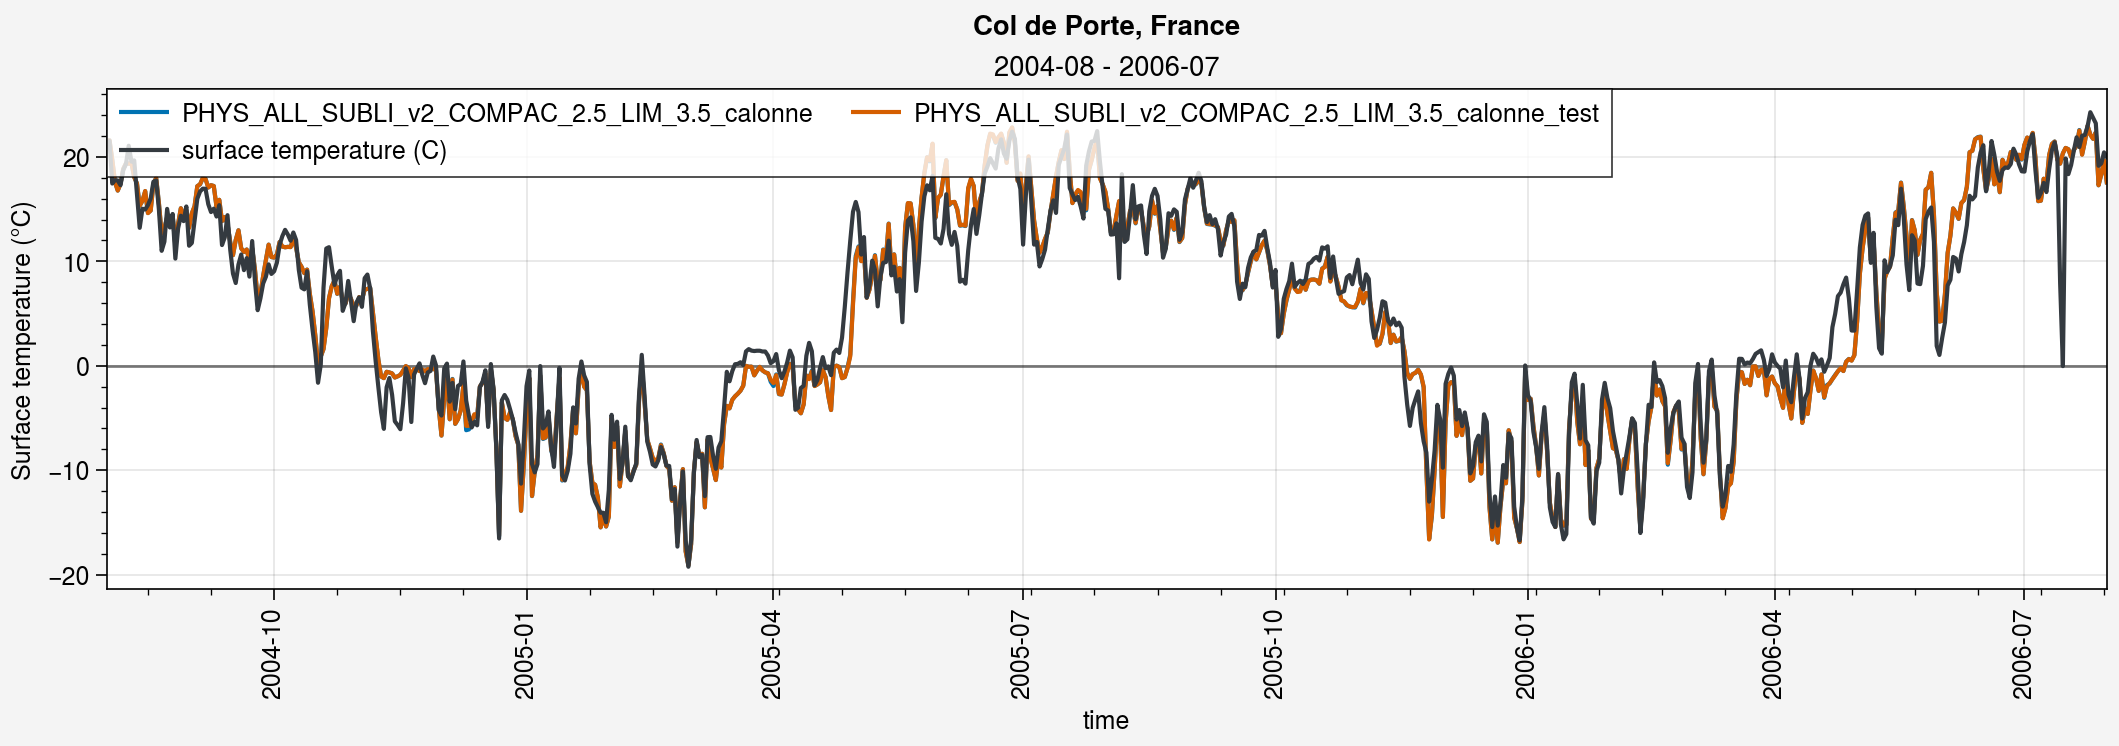

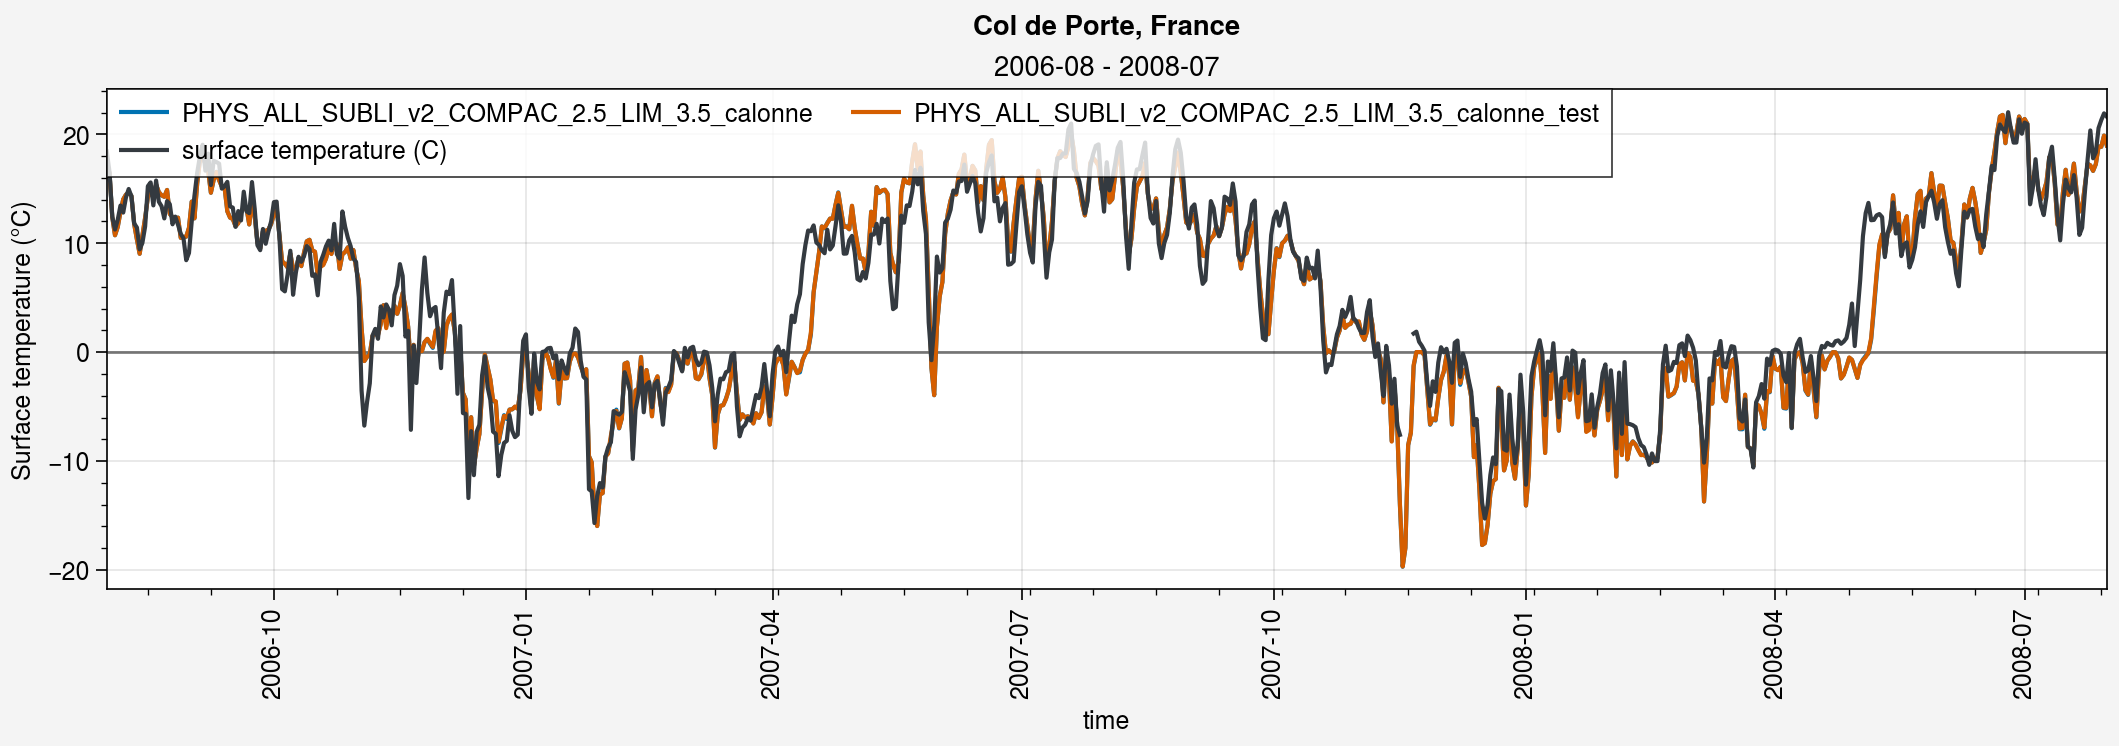

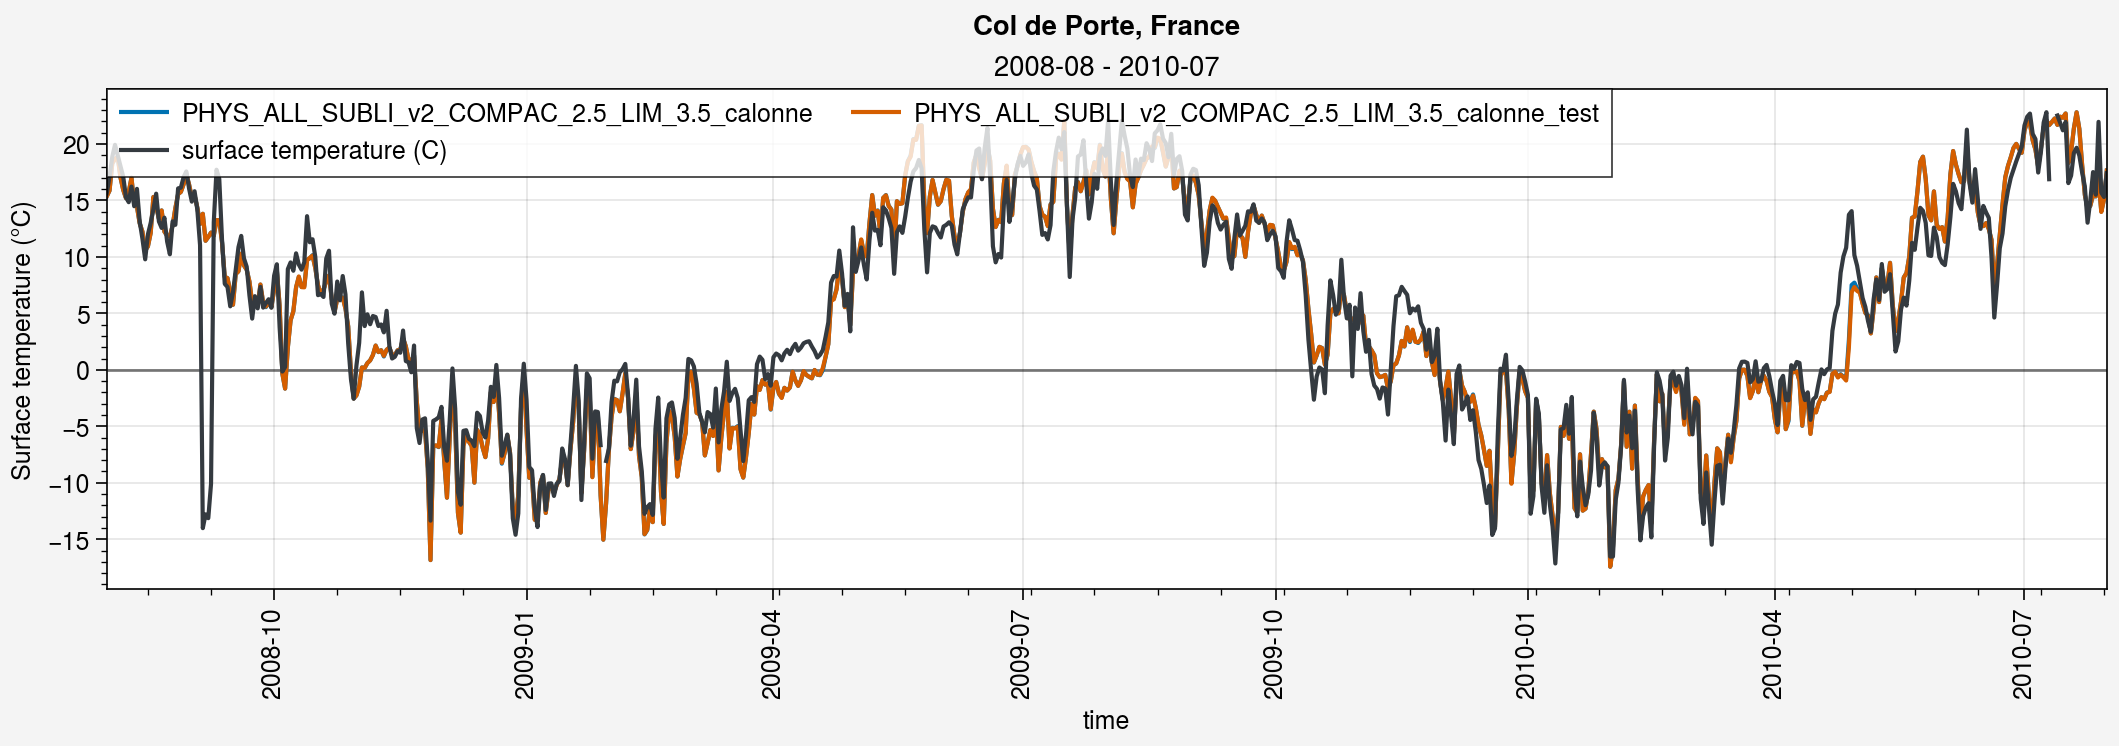

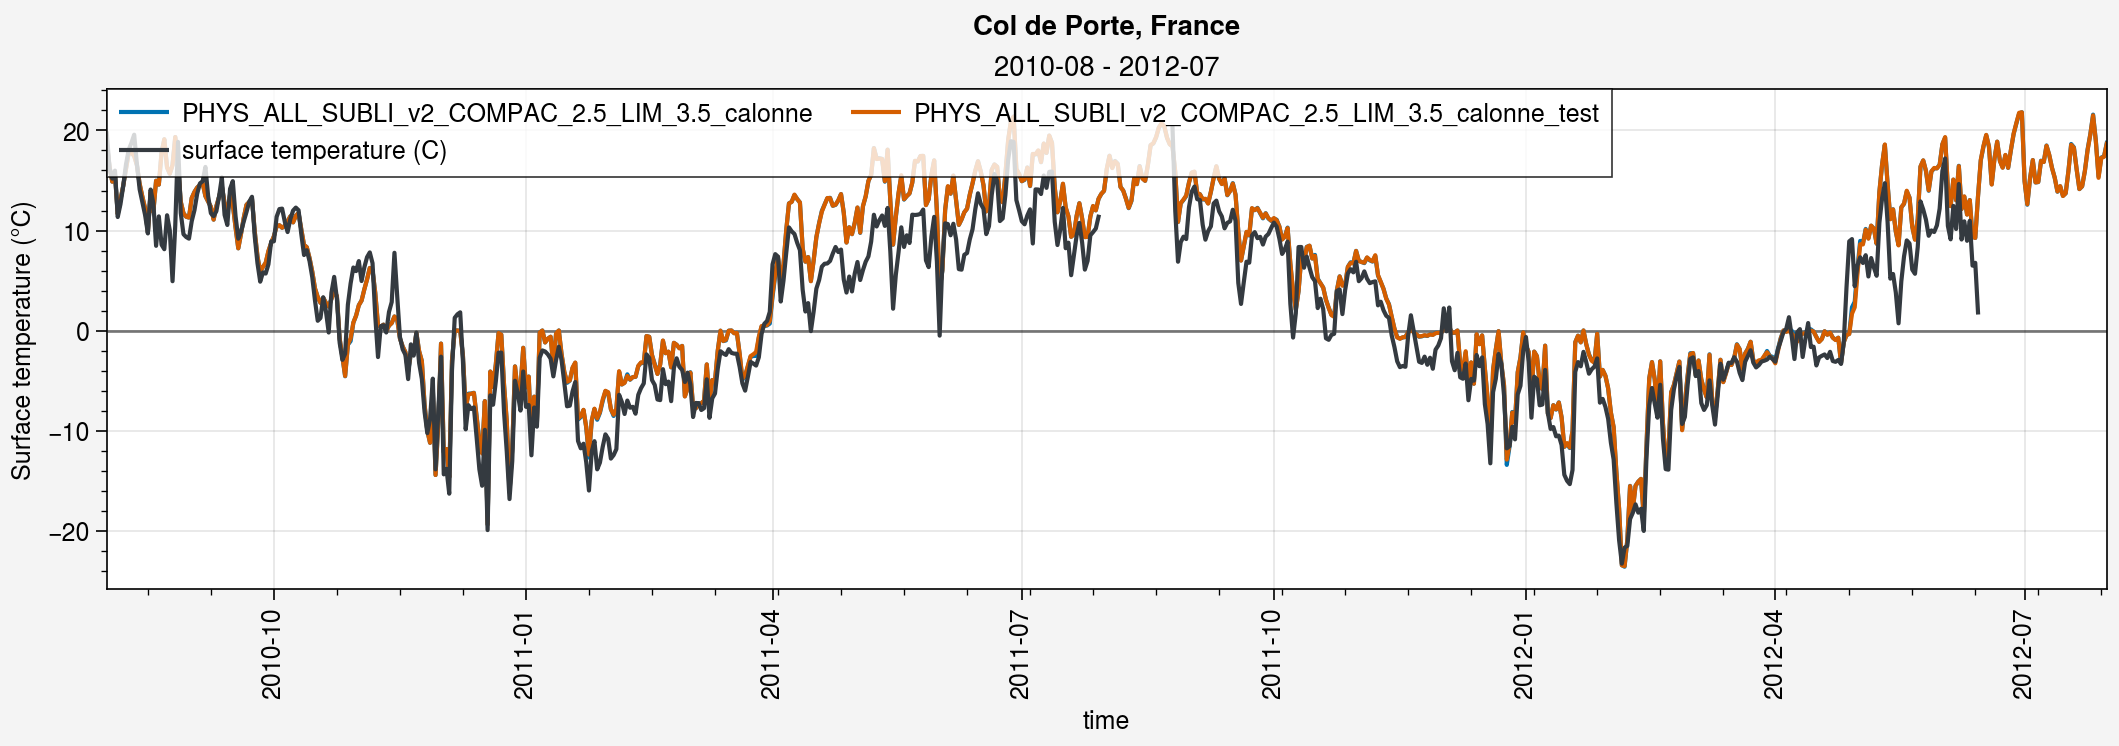

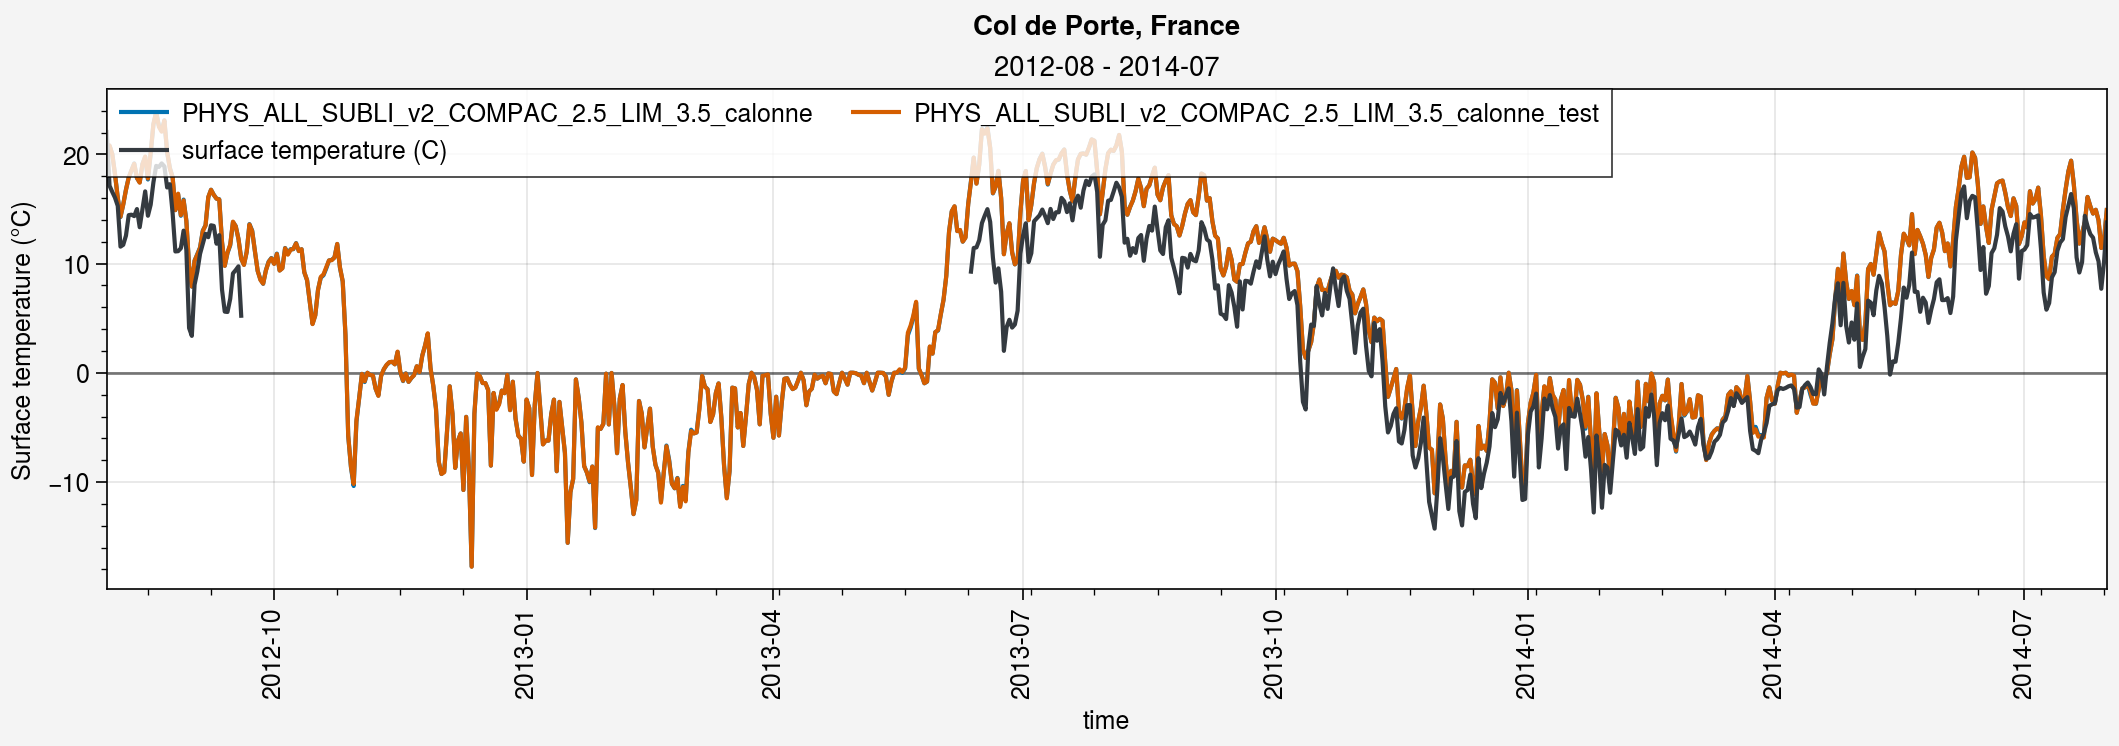

In [14]:
%matplotlib inline
gap = 2
color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.ts.sel(time=period)-273.15, label=label)
    
    # Obs
    axs[0].plot(ds_d_obs.ts.sel(time=period), color=color_obs)
    axs[0].hlines(0, ds_d.ts.sel(time=period).time[0], ds_d.ts.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Surface temperature (°C)')
    
    fig.suptitle(site_longname)


### Soil Temperature

<a list of 3 Line2D objects>

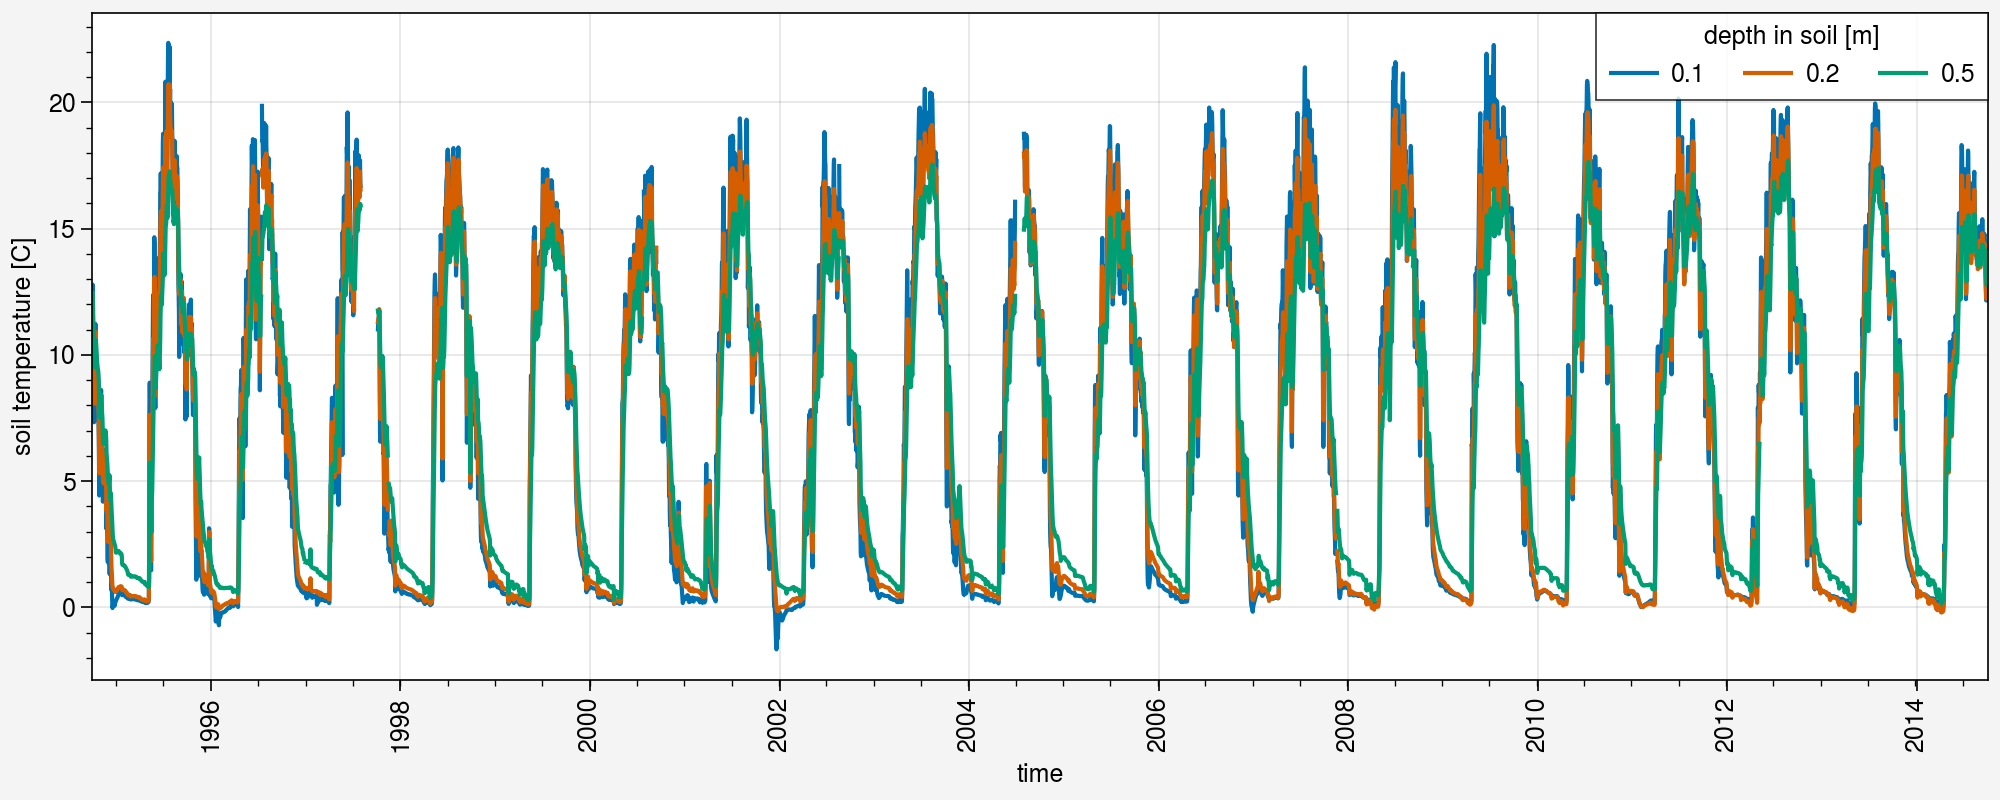

In [15]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10,4))
ds_d_obs.tsl.plot(hue='sdepth')

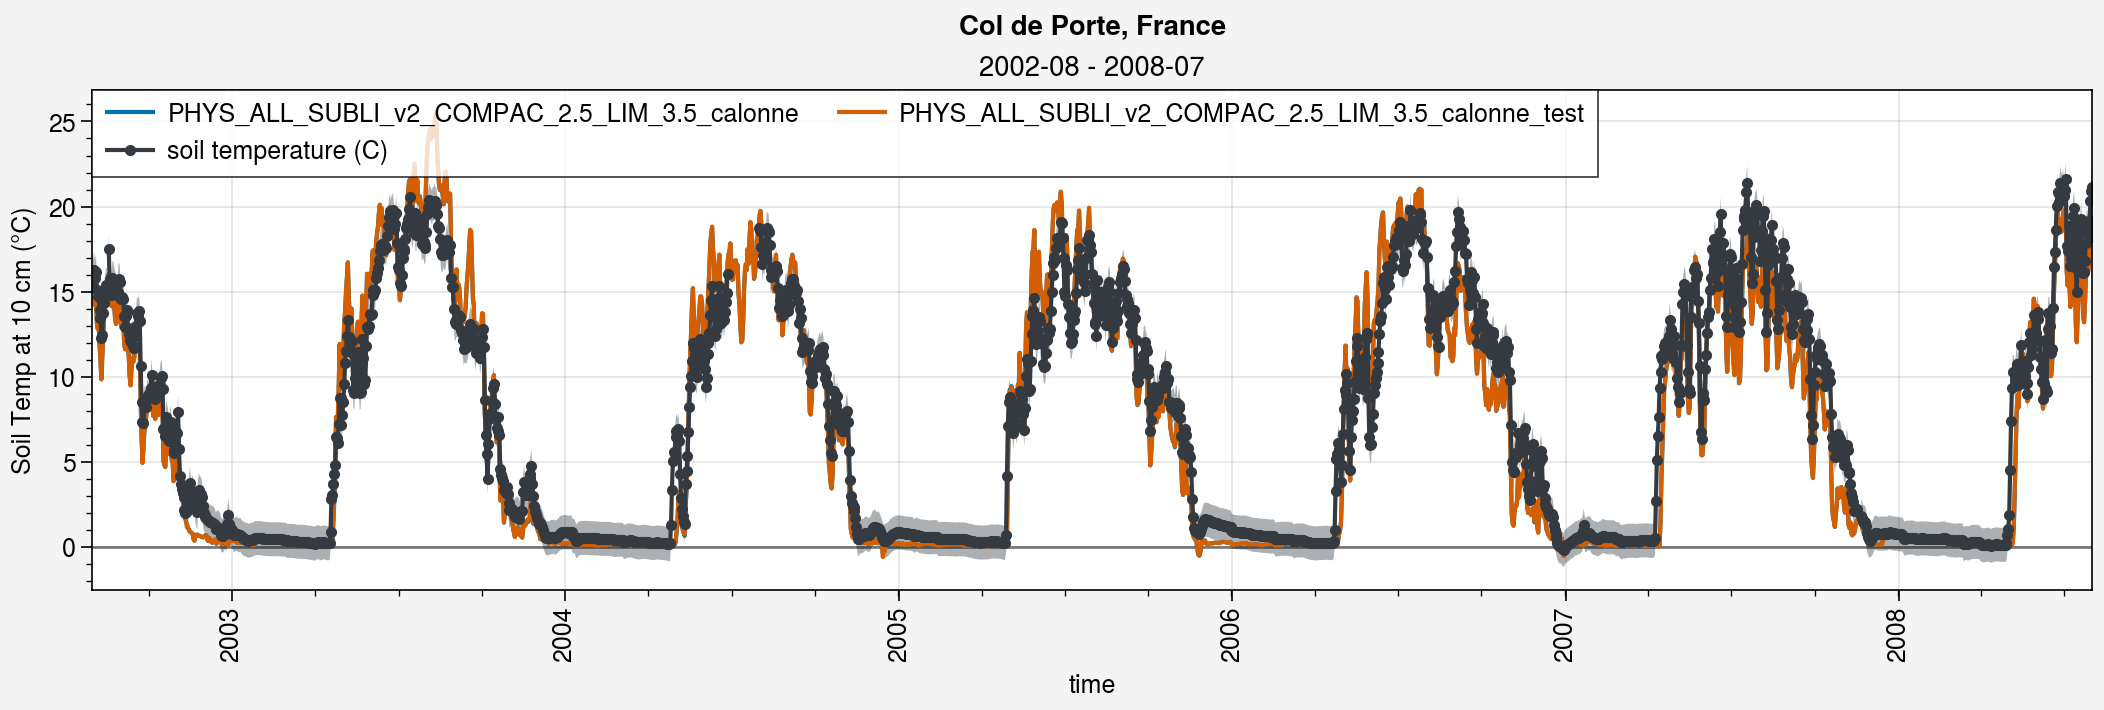

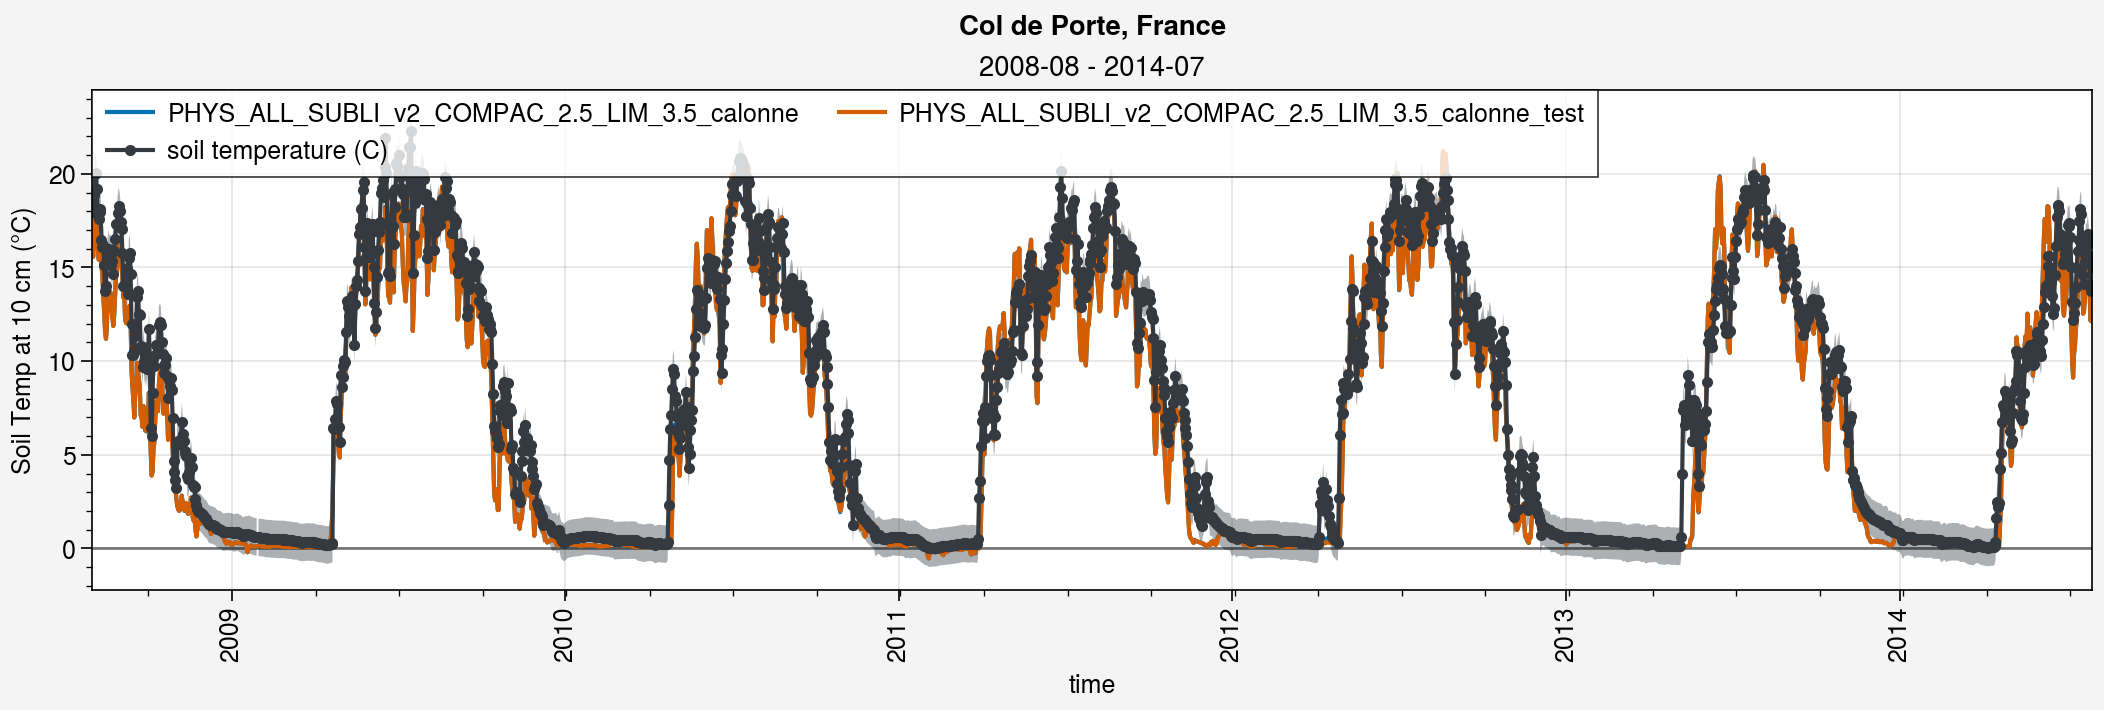

In [16]:
%matplotlib inline
gap = 6
color_obs = 'gray8'
sdepth = 0.1
sdepth_label = str(int(sdepth*100))

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        # axs[0].plot(((ds_d.tsl.sel(time=period, layer=1)+ds_d.tsl.sel(time=period, layer=2))/2)-273.15, label=label)
        # axs[0].plot(((ds_d.tsl.sel(time=period).isel(layer=0)+ds_d.tsl.sel(time=period).isel(layer=1))/2)-273.15, label=label)
        axs[0].plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1)-273.15, label=label)
        # axs[0].plot(ds_d.tsl.sel(time=period).sel(layer=sdepth)-273.15, label=label)
        
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)+1, axis=0),
        np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)-1, axis=0),), axis=0)
    axs[0].plot(ds_d_obs.tsl.sel(time=period, sdepth=sdepth), shadedata=shadedata, marker='.', color=color_obs)
    
    axs[0].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Soil Temp at '+sdepth_label+' cm (°C)')
    
    fig.suptitle(site_longname)


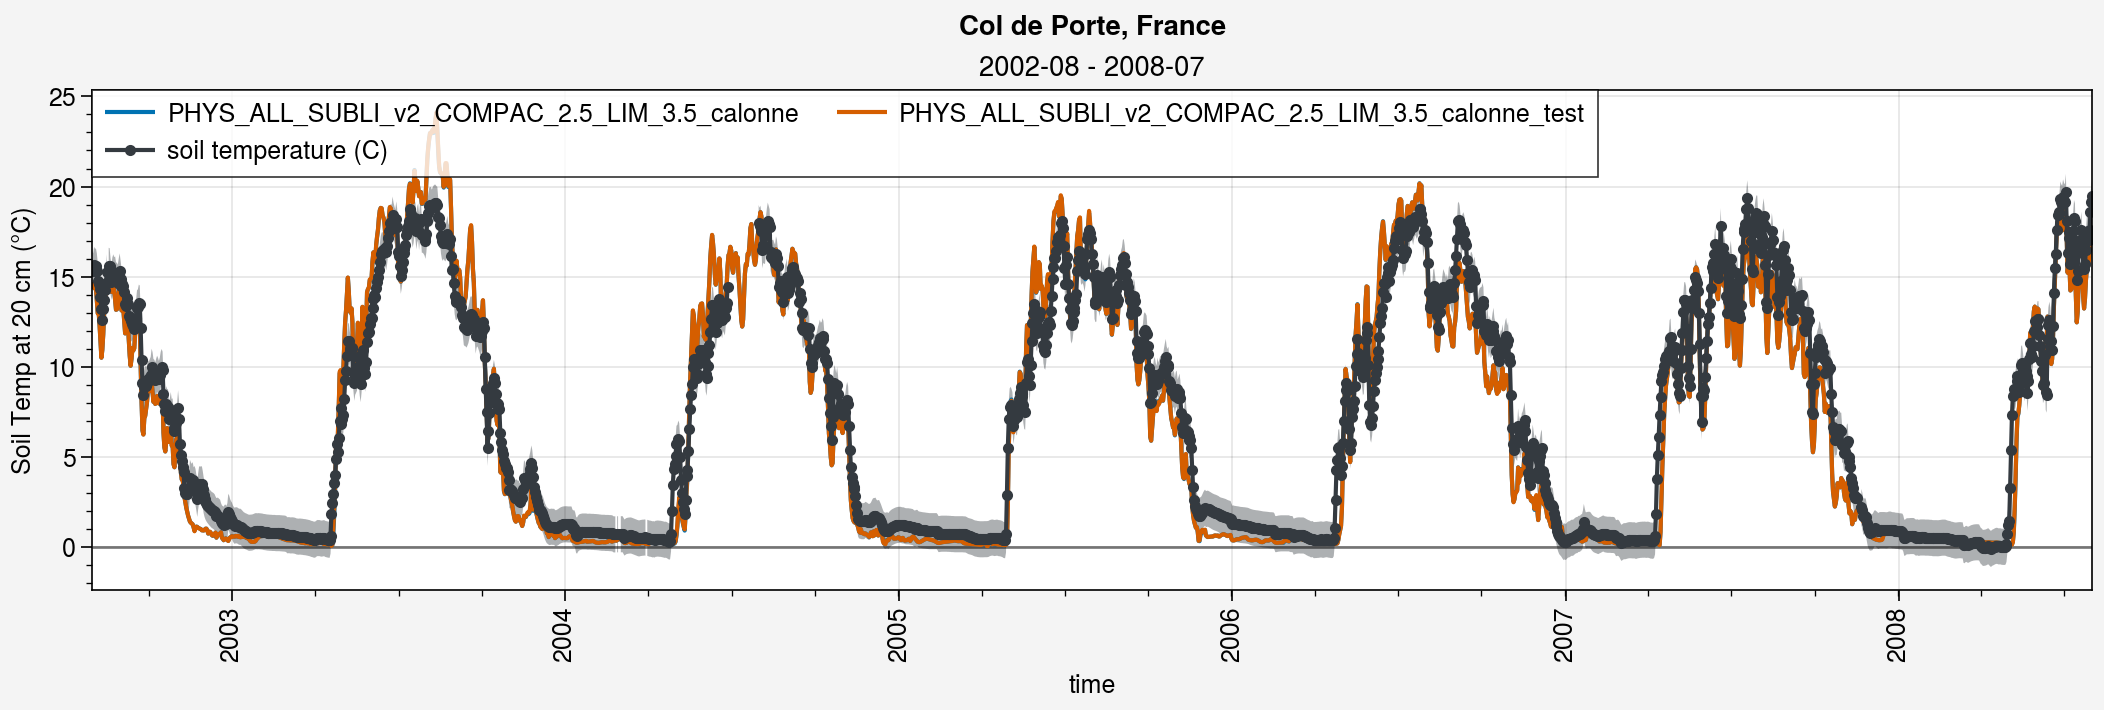

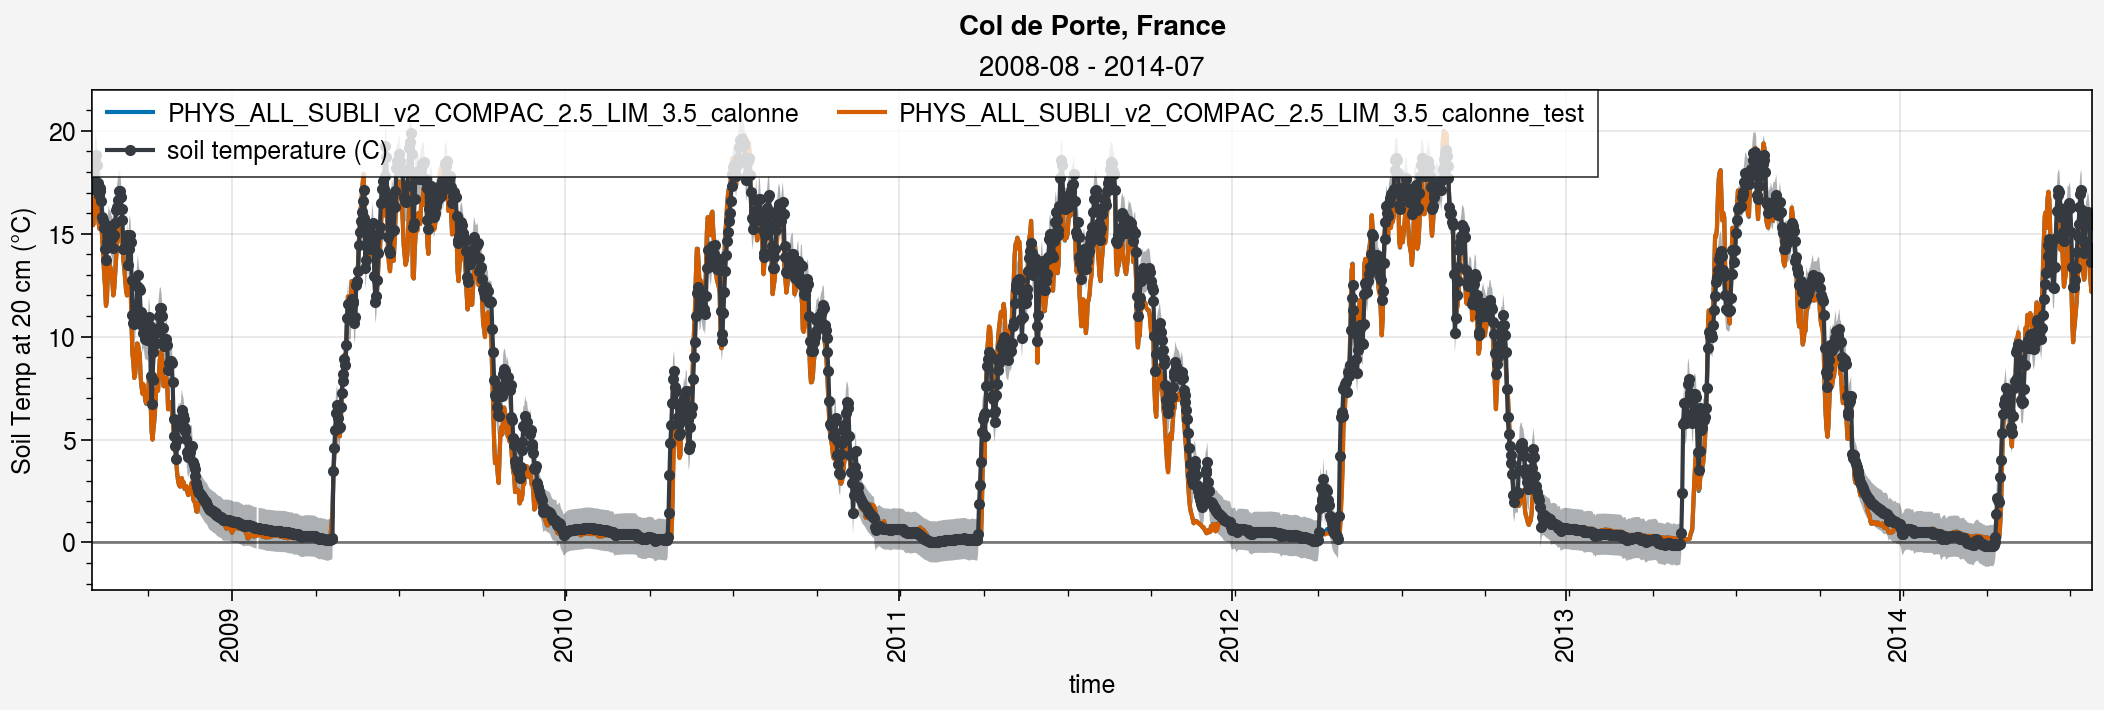

In [17]:
%matplotlib inline
gap = 6
color_obs = 'gray8'
sdepth = 0.2
sdepth_label = str(int(sdepth*100))

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        # axs[0].plot(((ds_d.tsl.sel(time=period, layer=1)+ds_d.tsl.sel(time=period, layer=2))/2)-273.15, label=label)
        # axs[0].plot(((ds_d.tsl.sel(time=period).isel(layer=0)+ds_d.tsl.sel(time=period).isel(layer=1))/2)-273.15, label=label)
        axs[0].plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=sdepth)-273.15, label=label)
        # axs[0].plot(ds_d.tsl.sel(time=period).sel(layer=sdepth, method='nearest')-273.15, label=label)
        
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)+1, axis=0),
        np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)-1, axis=0),), axis=0)
    axs[0].plot(ds_d_obs.tsl.sel(time=period, sdepth=sdepth), shadedata=shadedata, marker='.', color=color_obs)
    
    axs[0].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Soil Temp at '+sdepth_label+' cm (°C)')
    
    fig.suptitle(site_longname)


### Snow temperature

In [18]:
from snowpyt import pit_class as pc

Theoric snow temperature within CLASSIC: https://cccma.gitlab.io/classic/snowHeatCond_8f90.html#details

In [19]:
import os

def sorted_directory_listing_with_os_listdir(directory):
    items = os.listdir(directory)
    sorted_items = sorted(items)
    return sorted_items

In [20]:
path_lejeune2019 = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/CRYOBSCLIM_CDP'
mypath = path_lejeune2019+'/CRYOBSCLIM.CDP.2018.SnowProfile/SnowProfile/'
files = sorted_directory_listing_with_os_listdir(mypath)

In [21]:
tsn_obs_profile_list = []
depth_obs_profile_list = []
tsn_obs = []
dens_obs_profile_list = []
depth_dens_obs_profile_list = []
dens_obs = []
date_obs = []
for file in files:
    p = pc.Snowpit()
    p.caaml_file = path_lejeune2019+'/CRYOBSCLIM.CDP.2018.SnowProfile/SnowProfile/'+file
    p.import_caamlv6(print2term=False)
    # Temperature
    try:
        tsn_obs.append(np.trapz(p.temperature_profile.temp, x=-p.temperature_profile.depth)/(p.temperature_profile.depth[0]-p.temperature_profile.depth[-1]))
        tsn_obs_profile_list.append(list(p.temperature_profile.temp))
        depth_obs_profile_list.append(list(p.temperature_profile.depth))
    except AttributeError:
        tsn_obs.append(np.nan)
        tsn_obs_profile_list.append([np.nan])
        depth_obs_profile_list.append([np.nan])
                       
    # Density
    try:
        dens_obs.append(np.trapz(p.density_profile.density, x=-p.density_profile.depth)/(p.density_profile.depth[0]-p.density_profile.depth[-1]))
        dens_obs_profile_list.append(list(p.density_profile.density))
        depth_dens_obs_profile_list.append(list(p.density_profile.depth))
    except AttributeError:
        dens_obs.append(np.nan)
        dens_obs_profile_list.appen# ds_hh.tsn.plot()d([np.nan])
        depth_dens_obs_profile_list.append([np.nan])

    date_obs.append(p.metadata.date)
    # p.plot(plot_order=['density', 'temperature', 'stratigraphy', 'hardness'])

/tmp/ipykernel_136265/918251135.py:24: RuntimeWarning: invalid value encountered in scalar divide
  dens_obs.append(np.trapz(p.density_profile.density, x=-p.density_profile.depth)/(p.density_profile.depth[0]-p.density_profile.depth[-1]))
/tmp/ipykernel_136265/918251135.py:24: RuntimeWarning: invalid value encountered in scalar divide
  dens_obs.append(np.trapz(p.density_profile.density, x=-p.density_profile.depth)/(p.density_profile.depth[0]-p.density_profile.depth[-1]))
/tmp/ipykernel_136265/918251135.py:24: RuntimeWarning: invalid value encountered in scalar divide
  dens_obs.append(np.trapz(p.density_profile.density, x=-p.density_profile.depth)/(p.density_profile.depth[0]-p.density_profile.depth[-1]))


AttributeError: 'list' object has no attribute 'appen'

In [ ]:
d = {'tsn': tsn_obs}
# df_tsn = pd.DataFrame(data=d, index=pd.to_datetime(date_obs).tz_convert('Europe/Paris').tz_localize(None))
df_tsn = pd.DataFrame(data=d, index=pd.to_datetime(date_obs).tz_localize(None) + pd.Timedelta(hours=2)) # to avoid the day light savings adjustment
df_tsn = df_tsn.dropna()
ds_tsn_loc = df_tsn.to_xarray()
ds_tsn_loc = ds_tsn_loc.rename({'index': 'time'})
ds_tsn_loc = ds_tsn_loc.reindex({'time': pd.date_range(ds_tsn_loc.tsn.time[0].values, ds_tsn_loc.tsn.time[-1].values, freq='H')})

In [ ]:
d = {'tsn': tsn_obs}
df_tsn = pd.DataFrame(data=d, index=pd.to_datetime(date_obs).tz_localize(None))
df_tsn = df_tsn.dropna()
ds_tsn = df_tsn.to_xarray()
ds_tsn = ds_tsn.rename({'index': 'time'})
ds_tsn = ds_tsn.reindex({'time': pd.date_range(ds_tsn.tsn.time[0].values, ds_tsn.tsn.time[-1].values, freq='H')})

In [ ]:
ds_tsn_loc_d = ds_tsn_loc.tsn.resample(time='d').mean()
ds_tsn_d = ds_tsn.tsn.resample(time='d').mean()

In [ ]:
%matplotlib inline
plt.figure(figsize=(12,5))
# ds_hh.tsn.plot()
ds_tsn_loc.tsn.plot(marker='.')
ds_tsn_loc.tsn.resample(time='d').mean().plot(marker='x')
ds_tsn.tsn.plot(marker='.')
ds_d_list[0].tsn.plot()


#### Compute TSNBOT_TH for all timesteps
T(z) = 1/2az² + bz + c

z axis towards the bottom

In [ ]:
# depth_obs_profile_list

In [ ]:
bottom_depth_list = [depth_obs_profile[-1] for depth_obs_profile in depth_obs_profile_list]
bottom_depth_list

In [ ]:
bottom_depth_list.count()

In [ ]:
np.count_nonzero(bottom_depth_list)

In [ ]:
len(bottom_depth_list)

In [ ]:
100 - 19/406*100

In [ ]:
d = {'tsnbot': [tsn_obs_profile[-1] for tsn_obs_profile in tsn_obs_profile_list]}
# df_tsn = pd.DataFrame(data=d, index=pd.to_datetime(date_obs).tz_convert('Europe/Paris').tz_localize(None))
df_tsnbot = pd.DataFrame(data=d, index=pd.to_datetime(date_obs).tz_localize(None) + pd.Timedelta(hours=2)) # to avoid the day light savings adjustment
df_tsnbot = df_tsnbot.dropna()
ds_tsnbot_loc = df_tsnbot.to_xarray()
ds_tsnbot_loc = ds_tsnbot_loc.rename({'index': 'time'})
ds_tsnbot_loc = ds_tsnbot_loc.reindex({'time': pd.date_range(ds_tsnbot_loc.tsnbot.time[0].values, ds_tsnbot_loc.tsnbot.time[-1].values, freq='H')})

In [ ]:
d = {'tsnbot': [tsn_obs_profile[-1] for tsn_obs_profile in tsn_obs_profile_list]}
df_tsnbot = pd.DataFrame(data=d, index=pd.to_datetime(date_obs).tz_localize(None))
df_tsnbot = df_tsnbot.dropna()
ds_tsnbot = df_tsnbot.to_xarray()
ds_tsnbot = ds_tsnbot.rename({'index': 'time'})
ds_tsnbot = ds_tsnbot.reindex({'time': pd.date_range(ds_tsnbot.tsnbot.time[0].values, ds_tsnbot.tsnbot.time[-1].values, freq='H')})

In [ ]:
ds_tsnbot_loc_d = ds_tsnbot_loc.tsnbot.resample(time='d').mean()
ds_tsnbot_d = ds_tsnbot.tsnbot.resample(time='d').mean()

In [ ]:
%matplotlib inline
plt.figure(figsize=(12,5))
# ds_hh.tsn.plot()
ds_tsnbot_loc.tsnbot.plot(marker='.')
ds_tsnbot_loc_d.plot(marker='x')
ds_tsnbot.tsnbot.plot(marker='.')
ds_d_list[0].tsnbot.plot()


In [ ]:
TSNBOT_obs_day = ds_tsnbot_d

In [ ]:
# ds_h_eval_lejeune2019 = xr.open_dataset(path_lejeune2019+'/CRYOBSCLIM.CDP.2018.HourlySnow.nc')
# ds_d_eval_lejeune2019 = xr.open_dataset(path_lejeune2019+'/CRYOBSCLIM.CDP.2018.MetSnowDaily.nc')
# ds_h_eval_lejeune2019

## All 

In [ ]:
labels

In [ ]:

column_indexes = [['Obs'] + labels]

row_indexes = [['snd_auto', 'snwdens', 'ts', 'tsn', 'tsnbot', 'tsl_10', 'tsl_20', 'tsl_50'], ['ME', 'RMSE', 'NRMSE']]
rows = pd.MultiIndex.from_product(row_indexes)

df_metrics = pd.DataFrame(index=rows, columns=column_indexes)
df_metrics.loc[:, ('Obs', slice(None))] = 0
df_metrics

In [ ]:
# ds_d_obs = ds_d_obs.drop_vars('snwdens')
# ds_d_obs

In [ ]:
%matplotlib inline
fig, axs = pplt.subplots(figsize=(10, 4))
(ds_d_obs.snw_auto/ds_d_obs.snd_auto).where((ds_d_obs.snw_auto/ds_d_obs.snd_auto) < 917).where((ds_d_obs.snw_auto/ds_d_obs.snd_auto) > 0).plot()
(ds_d_obs.snw_man/ds_d_obs.snd_man).plot(marker='.')
# ds_d_obs.snwdens_auto.plot(marker='x')

In [ ]:
ds_d_obs = ds_d_obs.assign({
    'snwdens_auto': ('time', 
                     (ds_d_obs.snw_auto/ds_d_obs.snd_auto).where(
                         (ds_d_obs.snw_auto/ds_d_obs.snd_auto) < 917).where(
                         (ds_d_obs.snw_auto/ds_d_obs.snd_auto) > 0).values)})
ds_d_obs = ds_d_obs.assign({'snwdens_man': ('time', (ds_d_obs.snw_man/ds_d_obs.snd_man).values)})
ds_d_obs

In [ ]:
# https://essd.copernicus.org/articles/11/71/2019/
a = 0.1/ds_d_obs.snd_auto # 10 cm error
b = 25/ds_d_obs.snw_auto # 25 kg/m2

unc_snwdens_auto = ds_d_obs.snwdens_auto * xr.apply_ufunc(np.sqrt, a**2 + b**2)

In [ ]:
unc_snwdens_auto.mean() 

In [ ]:
unc_snwdens_auto.median() 

In [ ]:
%matplotlib inline
fig, axs = pplt.subplots()

ax = axs[0]
ax.scatter(df_metrics.loc[('snd_auto'), df_metrics.columns.get_level_values(0) != 'Obs'], marker='x')
ax.scatter(df_metrics.loc[('snd_auto', 'Obs')], color=color_obs)
ax.vlines([0, 1], 0, 1)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)
ax.format(xlim=(-0.8, 1.8), ylim=(-1,1))

In [ ]:
unc_snwdens_auto.mean()

In [ ]:
unc_snwdens_auto.median()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%matplotlib inline
color_obs = 'gray8'
period = slice('2002-08', '2014-06-25')

mask_sd = ds_d_obs.snd_auto.sel(time=period) >= 0.1

# fig, axs = pplt.subplots(nrows=3, ncols=2, refaspect=3.5, sharey=0, figsize=(9,6))
# fig, axs = pplt.subplots(nrows=5, ncols=2, refaspect=3.5, refwidth=6, sharey=0)
# fig, axs = pplt.subplots(nrows=8, ncols=2, refaspect=6, refwidth=8, sharey=0, wratios=(1, 0.12))
fig, axs = pplt.subplots(nrows=8, ncols=2, refaspect=6, sharey=0, wratios=(1, 0.12), figsize=(12,18))

k = 0
##################
### Snow Depth ###
##################
ax = axs[k]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.snd.sel(time=period), label=label, lw=1)
    df_metrics.loc[('snd_auto', 'RMSE'), label] = (xs.rmse(ds_d.snd.sel(time=period).where(mask_sd), 
                                                        ds_d_obs.snd_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snd_auto', 'ME'), label] = (xs.me(ds_d.snd.sel(time=period).where(mask_sd), 
                                                      ds_d_obs.snd_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snd_auto', 'NRMSE'), label] = df_metrics.loc[('snd_auto', 'RMSE'), label]/ \
                                                    ds_d_obs.snd_auto.sel(time=period).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
ax.plot(ds_d_obs.snd_auto.sel(time=period), shadedata=shadedata, color=color_obs, label='Obs (auto)', lw=1)
ax.plot(ds_d_obs.snd_man.sel(time=period), color=color_obs, label='Obs (man)', lw=1, marker='.')
ax.format(ylabel='Snow Depth [m]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('snd_auto'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('snd_auto', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.1, 0.1, lw=1, color=color_obs)
ax.format(xlim=(-0.8, 1.8), title='SD > 10 cm')
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)


 

k += 1
##################
### Snow dens ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.snwdens.sel(time=period), label=label, lw=1)
    df_metrics.loc[('snwdens', 'RMSE'), label] = (xs.rmse(ds_d.snwdens.sel(time=period).where(mask_sd), 
                                                        ds_d_obs.snwdens_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snwdens', 'ME'), label] = (xs.me(ds_d.snwdens.sel(time=period).where(mask_sd), 
                                                      ds_d_obs.snwdens_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snwdens', 'NRMSE'), label] = df_metrics.loc[('snwdens', 'RMSE'), label]/ \
                                                    ds_d_obs.snwdens_auto.sel(time=period).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.snwdens_auto.sel(time=period).values+unc_snwdens_auto.median().values, axis=0),
    np.expand_dims(ds_d_obs.snwdens_auto.sel(time=period).values-unc_snwdens_auto.median().values, axis=0),), axis=0)
ax.plot(ds_d_obs.snwdens_auto.sel(time=period), shadedata=shadedata, color=color_obs)
ax.plot(ds_d_obs.snwdens_man.sel(time=period), color=color_obs, marker='.')
ax.format(ylabel='Snow Density [kg m$^{-3}$]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('snwdens'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('snwdens', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -unc_snwdens_auto.median(), unc_snwdens_auto.median(), lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### T surf ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.ts.sel(time=period)-273.15, label=label, lw=1)
    df_metrics.loc[('ts', 'RMSE'), label] = (xs.rmse(ds_d.ts.sel(time=period).where(mask_sd)-273.15, 
                                                        ds_d_obs.ts.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('ts', 'ME'), label] = (xs.me(ds_d.ts.sel(time=period).where(mask_sd)-273.15, 
                                                      ds_d_obs.ts.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('ts', 'NRMSE'), label] = df_metrics.loc[('ts', 'RMSE'), label]/ \
                                                    ds_d_obs.ts.sel(time=period).where(mask_sd).std().values
    
# Obs
ax.plot(ds_d_obs.ts.sel(time=period), color=color_obs, lw=1)
ax.format(ylabel='Surface temperature [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('ts'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('ts', 'Obs')][:-1], color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### T snow ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsn.sel(time=period), label=label, lw=1)
    df_metrics.loc[('tsn', 'RMSE'), label] = (xs.rmse(ds_d.tsn.sel(time=period).where(mask_sd), 
                                                        ds_tsn_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsn', 'ME'), label] = (xs.me(ds_d.tsn.sel(time=period).where(mask_sd), 
                                                      ds_tsn_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsn', 'NRMSE'), label] = df_metrics.loc[('tsn', 'RMSE'), label]/ \
                                                    ds_tsn_d.sel(time=period).where(mask_sd).std().values
    
# Obs
ax.plot(ds_tsn_d.sel(time=period), color=color_obs, lw=1, marker='.')
ax.format(ylabel='Snow temperature [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsn'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsn', 'Obs')][:-1], color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### TSNBOT ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsnbot.sel(time=period).where(ds_d.snd.sel(time=period) > 0.1).where(mask_sd), label=label, lw=1)
    df_metrics.loc[('tsnbot', 'RMSE'), label] = (xs.rmse(ds_d.tsnbot.sel(time=period).where(mask_sd), 
                                                        ds_tsnbot_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsnbot', 'ME'), label] = (xs.me(ds_d.tsnbot.sel(time=period).where(mask_sd), 
                                                      ds_tsnbot_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsnbot', 'NRMSE'), label] = df_metrics.loc[('tsnbot', 'RMSE'), label]/ \
                                                    ds_tsnbot_d.sel(time=period).where(mask_sd).std().values
    
# Obs
ax.plot(ds_tsnbot_d.sel(time=period), color=color_obs, lw=1, marker='.') 
ax.format(ylabel='Bottom snow temp [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsnbot'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsnbot', 'Obs')][:-1], color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### T soil ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1)-273.15, label=label, lw=1)
    df_metrics.loc[('tsl_10', 'RMSE'), label] = (xs.rmse(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1).where(mask_sd)-273.15, 
                                                        ds_d_obs.tsl.sel(time=period, sdepth=0.1).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_10', 'ME'), label] = (xs.me(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1).where(mask_sd)-273.15, 
                                                      ds_d_obs.tsl.sel(time=period, sdepth=0.1).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_10', 'NRMSE'), label] = df_metrics.loc[('tsl_10', 'RMSE'), label]/ \
                                                    ds_d_obs.tsl.sel(time=period, sdepth=0.1).where(mask_sd).std().values


# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.1)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.1)-1, axis=0),), axis=0)
ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.1), shadedata=shadedata, color=color_obs, label='Obs (10 cm)', lw=1)
ax.format(ylabel='Soil Temp at 10 cm [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsl_10'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsl_10', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.4, 0.4, lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)




k += 1
ax = axs[k]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.2)-273.15, label=label, lw=1)
    df_metrics.loc[('tsl_20', 'RMSE'), label] = (xs.rmse(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.2).where(mask_sd)-273.15, 
                                                        ds_d_obs.tsl.sel(time=period, sdepth=0.2).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_20', 'ME'), label] = (xs.me(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.2).where(mask_sd)-273.15, 
                                                      ds_d_obs.tsl.sel(time=period, sdepth=0.2).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_20', 'NRMSE'), label] = df_metrics.loc[('tsl_20', 'RMSE'), label]/ \
                                                    ds_d_obs.tsl.sel(time=period, sdepth=0.2).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.2)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.2)-1, axis=0),), axis=0)
ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.2), shadedata=shadedata, color=color_obs, label='Obs (20 cm)', lw=1)
ax.format(ylabel='Soil Temp at 20 cm [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsl_20'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsl_20', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.4, 0.4, lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
ax = axs[k]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.5)-273.15, label=label, lw=1)
    df_metrics.loc[('tsl_50', 'RMSE'), label] = (xs.rmse(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.5).where(mask_sd)-273.15, 
                                                        ds_d_obs.tsl.sel(time=period, sdepth=0.5).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_50', 'ME'), label] = (xs.me(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.5).where(mask_sd)-273.15, 
                                                      ds_d_obs.tsl.sel(time=period, sdepth=0.5).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_50', 'NRMSE'), label] = df_metrics.loc[('tsl_50', 'RMSE'), label]/ \
                                                    ds_d_obs.tsl.sel(time=period, sdepth=0.5).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.5)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.5)-1, axis=0),), axis=0)
ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.5), shadedata=shadedata, color=color_obs, label='Obs (50 cm)', lw=1)
ax.format(ylabel='Soil Temp at 50 cm [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsl_50'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsl_50', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.4, 0.4, lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)


# # Simus
# for ds_d, label in zip(ds_d_list, labels):
#     ax.plot(ds_d.tsl.sel(time=period, layer=0.05)-273.15, label=label+' (layer 1)')
    
# # Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.05)+1, axis=0),
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.05)-1, axis=0),), axis=0)
# ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.05), shadedata=shadedata, color=color_obs, label='Obs (5 cm)')
# # ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=[0.02, 0.05, 0.1]).integrate('sdepth')/(0.1-0.02), color='red')

# ax.hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c=color_obs, lw=1, alpha=0.5)
# ax.format(ylabel='Soil Temp at 5 cm [°C]')
# ax.legend()

# k += 1
# ax = axs[k]
# # Simus
# for ds_d, label in zip(ds_d_list, labels):
#     ax.plot(ds_d.tsl.sel(time=period).sel(layer=0.15, method='nearest')-273.15, label=label+' (layer 2)')

# # Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.15)+1, axis=0),
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.15)-1, axis=0),), axis=0)
# ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.15), shadedata=shadedata, color=color_obs, label='Obs (15 cm)')
# # ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=[0.1, 0.15, 0.21]).integrate('sdepth')/(0.21-0.1), color='red')


# ax.hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c=color_obs, lw=1, alpha=0.5)
# ax.format(ylabel='Soil Temp at 15 cm [°C]')
# ax.legend()



fig.suptitle(site_longname + ' ('+period.start+' - '+period.stop+')')
fig.format(abc='(a)', abcloc='ul')
axs[0].legend(ncols=3, loc='t')


# fig.save('img/'+site+'_TCZE_REF_TSNB_ALL_2002-2014.pdf')

In [ ]:
%matplotlib inline
color_obs = 'gray8'
period = slice('2005-10', '2006-05')

mask_sd = ds_d_obs.snd_auto.sel(time=period) >= 0.1

# fig, axs = pplt.subplots(nrows=3, ncols=2, refaspect=3.5, sharey=0, figsize=(9,6))
# fig, axs = pplt.subplots(nrows=5, ncols=2, refaspect=3.5, refwidth=6, sharey=0)
fig, axs = pplt.subplots(nrows=8, ncols=2, refaspect=6, refwidth=8, sharey=0, wratios=(1, 0.12))
k = 0
##################
### Snow Depth ###
##################
ax = axs[k]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.snd.sel(time=period), label=label, lw=1)
    df_metrics.loc[('snd_auto', 'RMSE'), label] = (xs.rmse(ds_d.snd.sel(time=period).where(mask_sd), 
                                                        ds_d_obs.snd_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snd_auto', 'ME'), label] = (xs.me(ds_d.snd.sel(time=period).where(mask_sd), 
                                                      ds_d_obs.snd_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snd_auto', 'NRMSE'), label] = df_metrics.loc[('snd_auto', 'RMSE'), label]/ \
                                                    ds_d_obs.snd_auto.sel(time=period).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
ax.plot(ds_d_obs.snd_auto.sel(time=period), shadedata=shadedata, color=color_obs, label='Obs (auto)', lw=1)
ax.plot(ds_d_obs.snd_man.sel(time=period), color=color_obs, label='Obs (man)', lw=1, marker='.')

ax.format(ylabel='Snow Depth [m]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('snd_auto'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('snd_auto', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.1, 0.1, lw=1, color=color_obs)
ax.format(xlim=(-0.8, 1.8), title='SD > 10 cm')
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)


 

k += 1
##################
### Snow dens ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.snwdens.sel(time=period), label=label, lw=1)
    # Get the snow density 15 days before the measurement ones because early snowmelt in the model leading to 
    # too high densities... (arbitrary, but more representative in my opinion)
    df_metrics.loc[('snwdens', 'RMSE'), label] = (xs.rmse(ds_d.snwdens.sel(time=period).where(mask_sd), 
                                                        ds_d_obs.snwdens_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snwdens', 'ME'), label] = (xs.me(ds_d.snwdens.sel(time=period).where(mask_sd), 
                                                      ds_d_obs.snwdens_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snwdens', 'NRMSE'), label] = df_metrics.loc[('snwdens', 'RMSE'), label]/ \
                                                    ds_d_obs.snwdens_auto.sel(time=period).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.snwdens_auto.sel(time=period).values+unc_snwdens_auto.median().values, axis=0),
    np.expand_dims(ds_d_obs.snwdens_auto.sel(time=period).values-unc_snwdens_auto.median().values, axis=0),), axis=0)
ax.plot(ds_d_obs.snwdens_auto.sel(time=period), shadedata=shadedata, color=color_obs)
ax.plot(ds_d_obs.snwdens_man.sel(time=period), color=color_obs, marker='.')
ax.format(ylabel='Snow Density [kg m$^{-3}$]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('snwdens'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('snwdens', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -unc_snwdens_auto.median(), unc_snwdens_auto.median(), lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### T surf ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.ts.sel(time=period)-273.15, label=label, lw=1)
    df_metrics.loc[('ts', 'RMSE'), label] = (xs.rmse(ds_d.ts.sel(time=period).where(mask_sd)-273.15, 
                                                        ds_d_obs.ts.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('ts', 'ME'), label] = (xs.me(ds_d.ts.sel(time=period).where(mask_sd)-273.15, 
                                                      ds_d_obs.ts.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('ts', 'NRMSE'), label] = df_metrics.loc[('ts', 'RMSE'), label]/ \
                                                    ds_d_obs.ts.sel(time=period).where(mask_sd).std().values
    
# Obs
ax.plot(ds_d_obs.ts.sel(time=period), color=color_obs, lw=1)
ax.format(ylabel='Surface temperature [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('ts'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('ts', 'Obs')][:-1], color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### T snow ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsn.sel(time=period), label=label, lw=1)
    df_metrics.loc[('tsn', 'RMSE'), label] = (xs.rmse(ds_d.tsn.sel(time=period).where(mask_sd), 
                                                        ds_tsn_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsn', 'ME'), label] = (xs.me(ds_d.tsn.sel(time=period).where(mask_sd), 
                                                      ds_tsn_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsn', 'NRMSE'), label] = df_metrics.loc[('tsn', 'RMSE'), label]/ \
                                                    ds_tsn_d.sel(time=period).where(mask_sd).std().values
    
# Obs
ax.plot(ds_tsn_d.sel(time=period), color=color_obs, lw=1, marker='.')
ax.format(ylabel='Snow temperature [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsn'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsn', 'Obs')][:-1], color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### TSNBOT ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsnbot.sel(time=period).where(ds_d.snd.sel(time=period) > 0.1).where(mask_sd), label=label, lw=1)
    df_metrics.loc[('tsnbot', 'RMSE'), label] = (xs.rmse(ds_d.tsnbot.sel(time=period).where(mask_sd), 
                                                        ds_tsnbot_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsnbot', 'ME'), label] = (xs.me(ds_d.tsnbot.sel(time=period).where(mask_sd), 
                                                      ds_tsnbot_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsnbot', 'NRMSE'), label] = df_metrics.loc[('tsnbot', 'RMSE'), label]/ \
                                                    ds_tsnbot_d.sel(time=period).where(mask_sd).std().values
    
# Obs
ax.plot(ds_tsnbot_d.sel(time=period), color=color_obs, lw=1, marker='.') 
ax.format(ylabel='Bottom snow temp [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsnbot'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsnbot', 'Obs')][:-1], color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### T soil ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1)-273.15, label=label, lw=1)
    df_metrics.loc[('tsl_10', 'RMSE'), label] = (xs.rmse(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1).where(mask_sd)-273.15, 
                                                        ds_d_obs.tsl.sel(time=period, sdepth=0.1).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_10', 'ME'), label] = (xs.me(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1).where(mask_sd)-273.15, 
                                                      ds_d_obs.tsl.sel(time=period, sdepth=0.1).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_10', 'NRMSE'), label] = df_metrics.loc[('tsl_10', 'RMSE'), label]/ \
                                                    ds_d_obs.tsl.sel(time=period, sdepth=0.1).where(mask_sd).std().values


# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.1)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.1)-1, axis=0),), axis=0)
ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.1), shadedata=shadedata, color=color_obs, label='Obs (10 cm)', lw=1)
ax.format(ylabel='Soil Temp at 10 cm [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsl_10'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsl_10', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.4, 0.4, lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)




k += 1
ax = axs[k]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.2)-273.15, label=label, lw=1)
    df_metrics.loc[('tsl_20', 'RMSE'), label] = (xs.rmse(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.2).where(mask_sd)-273.15, 
                                                        ds_d_obs.tsl.sel(time=period, sdepth=0.2).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_20', 'ME'), label] = (xs.me(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.2).where(mask_sd)-273.15, 
                                                      ds_d_obs.tsl.sel(time=period, sdepth=0.2).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_20', 'NRMSE'), label] = df_metrics.loc[('tsl_20', 'RMSE'), label]/ \
                                                    ds_d_obs.tsl.sel(time=period, sdepth=0.2).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.2)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.2)-1, axis=0),), axis=0)
ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.2), shadedata=shadedata, color=color_obs, label='Obs (20 cm)', lw=1)
ax.format(ylabel='Soil Temp at 20 cm [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsl_20'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsl_20', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.4, 0.4, lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
ax = axs[k]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.5)-273.15, label=label, lw=1)
    df_metrics.loc[('tsl_50', 'RMSE'), label] = (xs.rmse(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.5).where(mask_sd)-273.15, 
                                                        ds_d_obs.tsl.sel(time=period, sdepth=0.5).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_50', 'ME'), label] = (xs.me(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.5).where(mask_sd)-273.15, 
                                                      ds_d_obs.tsl.sel(time=period, sdepth=0.5).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_50', 'NRMSE'), label] = df_metrics.loc[('tsl_50', 'RMSE'), label]/ \
                                                    ds_d_obs.tsl.sel(time=period, sdepth=0.5).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.5)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.5)-1, axis=0),), axis=0)
ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.5), shadedata=shadedata, color=color_obs, label='Obs (50 cm)', lw=1)
ax.format(ylabel='Soil Temp at 50 cm [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsl_50'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsl_50', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.4, 0.4, lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)


# # Simus
# for ds_d, label in zip(ds_d_list, labels):
#     ax.plot(ds_d.tsl.sel(time=period, layer=0.05)-273.15, label=label+' (layer 1)')
    
# # Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.05)+1, axis=0),
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.05)-1, axis=0),), axis=0)
# ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.05), shadedata=shadedata, color=color_obs, label='Obs (5 cm)')
# # ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=[0.02, 0.05, 0.1]).integrate('sdepth')/(0.1-0.02), color='red')

# ax.hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c=color_obs, lw=1, alpha=0.5)
# ax.format(ylabel='Soil Temp at 5 cm [°C]')
# ax.legend()

# k += 1
# ax = axs[k]
# # Simus
# for ds_d, label in zip(ds_d_list, labels):
#     ax.plot(ds_d.tsl.sel(time=period).sel(layer=0.15, method='nearest')-273.15, label=label+' (layer 2)')

# # Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.15)+1, axis=0),
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.15)-1, axis=0),), axis=0)
# ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.15), shadedata=shadedata, color=color_obs, label='Obs (15 cm)')
# # ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=[0.1, 0.15, 0.21]).integrate('sdepth')/(0.21-0.1), color='red')


# ax.hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c=color_obs, lw=1, alpha=0.5)
# ax.format(ylabel='Soil Temp at 15 cm [°C]')
# ax.legend()



fig.suptitle(site_longname + ' ('+period.start+' - '+period.stop+')')
fig.format(abc='(a)', abcloc='ul')
axs[0].legend(ncols=3, loc='t')


# fig.save('img/'+site+'_TCZE_REF_TSNB_ALL_'+period.start[0:4]+'-'+period.stop[0:4]+'.pdf')

In [ ]:
%matplotlib inline
color_obs = 'gray8'
period = slice('2002-08', '2014-06-25')

mask_sd = ds_d_obs.snd_auto.sel(time=period) >= 0.1

# fig, axs = pplt.subplots(nrows=3, ncols=2, refaspect=3.5, sharey=0, figsize=(9,6))
# fig, axs = pplt.subplots(nrows=5, ncols=2, refaspect=3.5, refwidth=6, sharey=0)
fig, axs = pplt.subplots(nrows=8, ncols=2, refaspect=6, refwidth=8, sharey=0, wratios=(1, 0.12))
k = 0
##################
### Snow Depth ###
##################
ax = axs[k]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.snd.sel(time=period), label=label, lw=1)
    df_metrics.loc[('snd_auto', 'RMSE'), label] = (xs.rmse(ds_d.snd.sel(time=period).where(mask_sd), 
                                                        ds_d_obs.snd_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snd_auto', 'ME'), label] = (xs.me(ds_d.snd.sel(time=period).where(mask_sd), 
                                                      ds_d_obs.snd_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snd_auto', 'NRMSE'), label] = df_metrics.loc[('snd_auto', 'RMSE'), label]/ \
                                                    ds_d_obs.snd_auto.sel(time=period).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
ax.plot(ds_d_obs.snd_auto.sel(time=period), shadedata=shadedata, color=color_obs, label='Obs (auto)', lw=1)
ax.plot(ds_d_obs.snd_man.sel(time=period), color=color_obs, label='Obs (man)', lw=1, marker='.')

ax.format(ylabel='Snow Depth [m]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('snd_auto'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('snd_auto', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.1, 0.1, lw=1, color=color_obs)
ax.format(xlim=(-0.8, 1.8), title='SD > 10 cm')
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)


 

k += 1
##################
### Snow dens ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.snwdens.sel(time=period), label=label, lw=1)
    # Get the snow density 15 days before the measurement ones because early snowmelt in the model leading to 
    # too high densities... (arbitrary, but more representative in my opinion)
    df_metrics.loc[('snwdens', 'RMSE'), label] = (xs.rmse(ds_d.snwdens.sel(time=period).where(mask_sd), 
                                                        ds_d_obs.snwdens_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snwdens', 'ME'), label] = (xs.me(ds_d.snwdens.sel(time=period).where(mask_sd), 
                                                      ds_d_obs.snwdens_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snwdens', 'NRMSE'), label] = df_metrics.loc[('snwdens', 'RMSE'), label]/ \
                                                    ds_d_obs.snwdens_auto.sel(time=period).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.snwdens_auto.sel(time=period).values+unc_snwdens_auto.median().values, axis=0),
    np.expand_dims(ds_d_obs.snwdens_auto.sel(time=period).values-unc_snwdens_auto.median().values, axis=0),), axis=0)
ax.plot(ds_d_obs.snwdens_auto.sel(time=period), shadedata=shadedata, color=color_obs)
ax.plot(ds_d_obs.snwdens_man.sel(time=period), color=color_obs, marker='.')
ax.format(ylabel='Snow Density [kg m$^{-3}$]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('snwdens'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('snwdens', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -unc_snwdens_auto.median(), unc_snwdens_auto.median(), lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### T surf ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.ts.sel(time=period)-273.15, label=label, lw=1)
    df_metrics.loc[('ts', 'RMSE'), label] = (xs.rmse(ds_d.ts.sel(time=period).where(mask_sd)-273.15, 
                                                        ds_d_obs.ts.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('ts', 'ME'), label] = (xs.me(ds_d.ts.sel(time=period).where(mask_sd)-273.15, 
                                                      ds_d_obs.ts.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('ts', 'NRMSE'), label] = df_metrics.loc[('ts', 'RMSE'), label]/ \
                                                    ds_d_obs.ts.sel(time=period).where(mask_sd).std().values
    
# Obs
ax.plot(ds_d_obs.ts.sel(time=period), color=color_obs, lw=1)
ax.format(ylabel='Surface temperature [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('ts'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('ts', 'Obs')][:-1], color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### T snow ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsn.sel(time=period), label=label, lw=1)
    df_metrics.loc[('tsn', 'RMSE'), label] = (xs.rmse(ds_d.tsn.sel(time=period).where(mask_sd), 
                                                        ds_tsn_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsn', 'ME'), label] = (xs.me(ds_d.tsn.sel(time=period).where(mask_sd), 
                                                      ds_tsn_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsn', 'NRMSE'), label] = df_metrics.loc[('tsn', 'RMSE'), label]/ \
                                                    ds_tsn_d.sel(time=period).where(mask_sd).std().values
    
# Obs
ax.plot(ds_tsn_d.sel(time=period), color=color_obs, lw=1, marker='.')
ax.format(ylabel='Snow temperature [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsn'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsn', 'Obs')][:-1], color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### TSNBOT ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsnbot.sel(time=period).where(ds_d.snd.sel(time=period) > 0.1).where(mask_sd), label=label, lw=1)
    df_metrics.loc[('tsnbot', 'RMSE'), label] = (xs.rmse(ds_d.tsnbot.sel(time=period).where(mask_sd), 
                                                        ds_tsnbot_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsnbot', 'ME'), label] = (xs.me(ds_d.tsnbot.sel(time=period).where(mask_sd), 
                                                      ds_tsnbot_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsnbot', 'NRMSE'), label] = df_metrics.loc[('tsnbot', 'RMSE'), label]/ \
                                                    ds_tsnbot_d.sel(time=period).where(mask_sd).std().values
    
# Obs
ax.plot(ds_tsnbot_d.sel(time=period), color=color_obs, lw=1, marker='.') 
ax.format(ylabel='Bottom snow temp [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsnbot'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsnbot', 'Obs')][:-1], color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### T soil ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1)-273.15, label=label, lw=1)
    df_metrics.loc[('tsl_10', 'RMSE'), label] = (xs.rmse(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1).where(mask_sd)-273.15, 
                                                        ds_d_obs.tsl.sel(time=period, sdepth=0.1).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_10', 'ME'), label] = (xs.me(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1).where(mask_sd)-273.15, 
                                                      ds_d_obs.tsl.sel(time=period, sdepth=0.1).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_10', 'NRMSE'), label] = df_metrics.loc[('tsl_10', 'RMSE'), label]/ \
                                                    ds_d_obs.tsl.sel(time=period, sdepth=0.1).where(mask_sd).std().values


# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.1)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.1)-1, axis=0),), axis=0)
ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.1), shadedata=shadedata, color=color_obs, label='Obs (10 cm)', lw=1)
ax.format(ylabel='Soil Temp at 10 cm [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsl_10'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsl_10', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.4, 0.4, lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)




k += 1
ax = axs[k]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.2)-273.15, label=label, lw=1)
    df_metrics.loc[('tsl_20', 'RMSE'), label] = (xs.rmse(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.2).where(mask_sd)-273.15, 
                                                        ds_d_obs.tsl.sel(time=period, sdepth=0.2).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_20', 'ME'), label] = (xs.me(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.2).where(mask_sd)-273.15, 
                                                      ds_d_obs.tsl.sel(time=period, sdepth=0.2).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_20', 'NRMSE'), label] = df_metrics.loc[('tsl_20', 'RMSE'), label]/ \
                                                    ds_d_obs.tsl.sel(time=period, sdepth=0.2).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.2)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.2)-1, axis=0),), axis=0)
ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.2), shadedata=shadedata, color=color_obs, label='Obs (20 cm)', lw=1)
ax.format(ylabel='Soil Temp at 20 cm [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsl_20'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsl_20', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.4, 0.4, lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
ax = axs[k]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.5)-273.15, label=label, lw=1)
    df_metrics.loc[('tsl_50', 'RMSE'), label] = (xs.rmse(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.5).where(mask_sd)-273.15, 
                                                        ds_d_obs.tsl.sel(time=period, sdepth=0.5).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_50', 'ME'), label] = (xs.me(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.5).where(mask_sd)-273.15, 
                                                      ds_d_obs.tsl.sel(time=period, sdepth=0.5).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_50', 'NRMSE'), label] = df_metrics.loc[('tsl_50', 'RMSE'), label]/ \
                                                    ds_d_obs.tsl.sel(time=period, sdepth=0.5).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.5)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.5)-1, axis=0),), axis=0)
ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.5), shadedata=shadedata, color=color_obs, label='Obs (50 cm)', lw=1)
ax.format(ylabel='Soil Temp at 50 cm [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsl_50'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsl_50', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.4, 0.4, lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)


# # Simus
# for ds_d, label in zip(ds_d_list, labels):
#     ax.plot(ds_d.tsl.sel(time=period, layer=0.05)-273.15, label=label+' (layer 1)')
    
# # Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.05)+1, axis=0),
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.05)-1, axis=0),), axis=0)
# ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.05), shadedata=shadedata, color=color_obs, label='Obs (5 cm)')
# # ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=[0.02, 0.05, 0.1]).integrate('sdepth')/(0.1-0.02), color='red')

# ax.hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c=color_obs, lw=1, alpha=0.5)
# ax.format(ylabel='Soil Temp at 5 cm [°C]')
# ax.legend()

# k += 1
# ax = axs[k]
# # Simus
# for ds_d, label in zip(ds_d_list, labels):
#     ax.plot(ds_d.tsl.sel(time=period).sel(layer=0.15, method='nearest')-273.15, label=label+' (layer 2)')

# # Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.15)+1, axis=0),
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.15)-1, axis=0),), axis=0)
# ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.15), shadedata=shadedata, color=color_obs, label='Obs (15 cm)')
# # ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=[0.1, 0.15, 0.21]).integrate('sdepth')/(0.21-0.1), color='red')


# ax.hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c=color_obs, lw=1, alpha=0.5)
# ax.format(ylabel='Soil Temp at 15 cm [°C]')
# ax.legend()



fig.suptitle(site_longname + ' ('+period.start+' - '+period.stop+')')
fig.format(abc='(a)', abcloc='ul')
axs[0].legend(ncols=2, loc='t')


# fig.save('img/'+site+'_TCZE_REF_TSNB_REF_InfiltrateRain_'+period.start[0:4]+'-'+period.stop[0:4]+'.pdf')

In [ ]:
df_metrics

In [ ]:
%matplotlib inline
color_obs = 'gray8'
period = slice('2010-10', '2011-05')

mask_sd = ds_d_obs.snd_auto.sel(time=period) >= 0.1

# fig, axs = pplt.subplots(nrows=3, ncols=2, refaspect=3.5, sharey=0, figsize=(9,6))
# fig, axs = pplt.subplots(nrows=5, ncols=2, refaspect=3.5, refwidth=6, sharey=0)
fig, axs = pplt.subplots(nrows=8, ncols=2, refaspect=6, refwidth=8, sharey=0, wratios=(1, 0.12))
k = 0
##################
### Snow Depth ###
##################
ax = axs[k]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.snd.sel(time=period), label=label, lw=1)
    df_metrics.loc[('snd_auto', 'RMSE'), label] = (xs.rmse(ds_d.snd.sel(time=period).where(mask_sd), 
                                                        ds_d_obs.snd_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snd_auto', 'ME'), label] = (xs.me(ds_d.snd.sel(time=period).where(mask_sd), 
                                                      ds_d_obs.snd_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snd_auto', 'NRMSE'), label] = df_metrics.loc[('snd_auto', 'RMSE'), label]/ \
                                                    ds_d_obs.snd_auto.sel(time=period).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
ax.plot(ds_d_obs.snd_auto.sel(time=period), shadedata=shadedata, color=color_obs, label='Obs (auto)', lw=1)
ax.plot(ds_d_obs.snd_man.sel(time=period), color=color_obs, label='Obs (man)', lw=1, marker='.')
ax.format(ylabel='Snow Depth [m]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('snd_auto'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('snd_auto', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.1, 0.1, lw=1, color=color_obs)
ax.format(xlim=(-0.8, 1.8), title='SD > 10 cm')
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)


 

k += 1
##################
### Snow dens ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.snwdens.sel(time=period), label=label, lw=1)
    # Get the snow density 15 days before the measurement ones because early snowmelt in the model leading to 
    # too high densities... (arbitrary, but more representative in my opinion)
    df_metrics.loc[('snwdens', 'RMSE'), label] = (xs.rmse(ds_d.snwdens.sel(time=period).where(mask_sd), 
                                                        ds_d_obs.snwdens_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snwdens', 'ME'), label] = (xs.me(ds_d.snwdens.sel(time=period).where(mask_sd), 
                                                      ds_d_obs.snwdens_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snwdens', 'NRMSE'), label] = df_metrics.loc[('snwdens', 'RMSE'), label]/ \
                                                    ds_d_obs.snwdens_auto.sel(time=period).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.snwdens_auto.sel(time=period).values+unc_snwdens_auto.median().values, axis=0),
    np.expand_dims(ds_d_obs.snwdens_auto.sel(time=period).values-unc_snwdens_auto.median().values, axis=0),), axis=0)
ax.plot(ds_d_obs.snwdens_auto.sel(time=period), shadedata=shadedata, color=color_obs)
ax.plot(ds_d_obs.snwdens_man.sel(time=period), color=color_obs, marker='.')
ax.format(ylabel='Snow Density [kg m$^{-3}$]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('snwdens'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('snwdens', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -unc_snwdens_auto.median(), unc_snwdens_auto.median(), lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### T surf ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.ts.sel(time=period)-273.15, label=label, lw=1)
    df_metrics.loc[('ts', 'RMSE'), label] = (xs.rmse(ds_d.ts.sel(time=period).where(mask_sd)-273.15, 
                                                        ds_d_obs.ts.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('ts', 'ME'), label] = (xs.me(ds_d.ts.sel(time=period).where(mask_sd)-273.15, 
                                                      ds_d_obs.ts.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('ts', 'NRMSE'), label] = df_metrics.loc[('ts', 'RMSE'), label]/ \
                                                    ds_d_obs.ts.sel(time=period).where(mask_sd).std().values
    
# Obs
ax.plot(ds_d_obs.ts.sel(time=period), color=color_obs, lw=1)
ax.format(ylabel='Surface temperature [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('ts'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('ts', 'Obs')][:-1], color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### T snow ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsn.sel(time=period), label=label, lw=1)
    df_metrics.loc[('tsn', 'RMSE'), label] = (xs.rmse(ds_d.tsn.sel(time=period).where(mask_sd), 
                                                        ds_tsn_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsn', 'ME'), label] = (xs.me(ds_d.tsn.sel(time=period).where(mask_sd), 
                                                      ds_tsn_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsn', 'NRMSE'), label] = df_metrics.loc[('tsn', 'RMSE'), label]/ \
                                                    ds_tsn_d.sel(time=period).where(mask_sd).std().values
    
# Obs
ax.plot(ds_tsn_d.sel(time=period), color=color_obs, lw=1, marker='.')
ax.format(ylabel='Snow temperature [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsn'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsn', 'Obs')][:-1], color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### TSNBOT ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsnbot.sel(time=period).where(ds_d.snd.sel(time=period) > 0.1).where(mask_sd), label=label, lw=1)
    df_metrics.loc[('tsnbot', 'RMSE'), label] = (xs.rmse(ds_d.tsnbot.sel(time=period).where(mask_sd), 
                                                        ds_tsnbot_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsnbot', 'ME'), label] = (xs.me(ds_d.tsnbot.sel(time=period).where(mask_sd), 
                                                      ds_tsnbot_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsnbot', 'NRMSE'), label] = df_metrics.loc[('tsnbot', 'RMSE'), label]/ \
                                                    ds_tsnbot_d.sel(time=period).where(mask_sd).std().values
    
# Obs
ax.plot(ds_tsnbot_d.sel(time=period), color=color_obs, lw=1, marker='.') 
ax.format(ylabel='Bottom snow temp [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsnbot'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsnbot', 'Obs')][:-1], color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### T soil ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1)-273.15, label=label, lw=1)
    df_metrics.loc[('tsl_10', 'RMSE'), label] = (xs.rmse(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1).where(mask_sd)-273.15, 
                                                        ds_d_obs.tsl.sel(time=period, sdepth=0.1).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_10', 'ME'), label] = (xs.me(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1).where(mask_sd)-273.15, 
                                                      ds_d_obs.tsl.sel(time=period, sdepth=0.1).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_10', 'NRMSE'), label] = df_metrics.loc[('tsl_10', 'RMSE'), label]/ \
                                                    ds_d_obs.tsl.sel(time=period, sdepth=0.1).where(mask_sd).std().values


# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.1)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.1)-1, axis=0),), axis=0)
ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.1), shadedata=shadedata, color=color_obs, label='Obs (10 cm)', lw=1)
ax.format(ylabel='Soil Temp at 10 cm [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsl_10'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsl_10', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.4, 0.4, lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)




k += 1
ax = axs[k]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.2)-273.15, label=label, lw=1)
    df_metrics.loc[('tsl_20', 'RMSE'), label] = (xs.rmse(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.2).where(mask_sd)-273.15, 
                                                        ds_d_obs.tsl.sel(time=period, sdepth=0.2).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_20', 'ME'), label] = (xs.me(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.2).where(mask_sd)-273.15, 
                                                      ds_d_obs.tsl.sel(time=period, sdepth=0.2).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_20', 'NRMSE'), label] = df_metrics.loc[('tsl_20', 'RMSE'), label]/ \
                                                    ds_d_obs.tsl.sel(time=period, sdepth=0.2).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.2)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.2)-1, axis=0),), axis=0)
ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.2), shadedata=shadedata, color=color_obs, label='Obs (20 cm)', lw=1)
ax.format(ylabel='Soil Temp at 20 cm [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsl_20'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsl_20', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.4, 0.4, lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
ax = axs[k]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.5)-273.15, label=label, lw=1)
    df_metrics.loc[('tsl_50', 'RMSE'), label] = (xs.rmse(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.5).where(mask_sd)-273.15, 
                                                        ds_d_obs.tsl.sel(time=period, sdepth=0.5).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_50', 'ME'), label] = (xs.me(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.5).where(mask_sd)-273.15, 
                                                      ds_d_obs.tsl.sel(time=period, sdepth=0.5).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_50', 'NRMSE'), label] = df_metrics.loc[('tsl_50', 'RMSE'), label]/ \
                                                    ds_d_obs.tsl.sel(time=period, sdepth=0.5).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.5)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.5)-1, axis=0),), axis=0)
ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.5), shadedata=shadedata, color=color_obs, label='Obs (50 cm)', lw=1)
ax.format(ylabel='Soil Temp at 50 cm [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsl_50'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsl_50', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.4, 0.4, lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)


# # Simus
# for ds_d, label in zip(ds_d_list, labels):
#     ax.plot(ds_d.tsl.sel(time=period, layer=0.05)-273.15, label=label+' (layer 1)')
    
# # Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.05)+1, axis=0),
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.05)-1, axis=0),), axis=0)
# ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.05), shadedata=shadedata, color=color_obs, label='Obs (5 cm)')
# # ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=[0.02, 0.05, 0.1]).integrate('sdepth')/(0.1-0.02), color='red')

# ax.hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c=color_obs, lw=1, alpha=0.5)
# ax.format(ylabel='Soil Temp at 5 cm [°C]')
# ax.legend()

# k += 1
# ax = axs[k]
# # Simus
# for ds_d, label in zip(ds_d_list, labels):
#     ax.plot(ds_d.tsl.sel(time=period).sel(layer=0.15, method='nearest')-273.15, label=label+' (layer 2)')

# # Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.15)+1, axis=0),
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.15)-1, axis=0),), axis=0)
# ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.15), shadedata=shadedata, color=color_obs, label='Obs (15 cm)')
# # ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=[0.1, 0.15, 0.21]).integrate('sdepth')/(0.21-0.1), color='red')


# ax.hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c=color_obs, lw=1, alpha=0.5)
# ax.format(ylabel='Soil Temp at 15 cm [°C]')
# ax.legend()



fig.suptitle(site_longname + ' ('+period.start+' - '+period.stop+')')
fig.format(abc='(a)', abcloc='ul')
axs[0].legend(ncols=3, loc='t')


# fig.save('img/'+site+'_TCZE_REF_TSNB_ALL_'+period.start[0:4]+'-'+period.stop[0:4]+'.pdf')

In [ ]:
period.start[0:4]

In [ ]:
df_metrics

In [ ]:
df_metrics.groupby(level=1).mean()

# Final figures

In [ ]:
labels

In [ ]:
labels0 = [
    'DEF',
    'PHYS',
    'ARCTIC',
    'ARCTIC (TVC)'
]

In [ ]:
%matplotlib inline
color_obs = 'gray8'
period = slice('2005-11', '2006-05')

mask_sd = ds_d_obs.snd_auto.sel(time=period) >= 0.1

# fig, axs = pplt.subplots(nrows=3, ncols=2, refaspect=3.5, sharey=0, figsize=(9,6))
# fig, axs = pplt.subplots(nrows=5, ncols=2, refaspect=3.5, refwidth=6, sharey=0)
fig, axs = pplt.subplots(nrows=6, ncols=2, refaspect=6, refwidth=8, sharey=0, wratios=(1, 0.12))
k = 0
##################
### Snow Depth ###
##################
ax = axs[k]
# Simus
for ds_d, label, label0 in zip(ds_d_list, labels, labels0):
    ax.plot(ds_d.snd.sel(time=period), label=label0, lw=1)
    df_metrics.loc[('snd_auto', 'RMSE'), label] = (xs.rmse(ds_d.snd.sel(time=period).where(mask_sd), 
                                                        ds_d_obs.snd_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snd_auto', 'ME'), label] = (xs.me(ds_d.snd.sel(time=period).where(mask_sd), 
                                                      ds_d_obs.snd_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snd_auto', 'NRMSE'), label] = df_metrics.loc[('snd_auto', 'RMSE'), label]/ \
                                                    ds_d_obs.snd_auto.sel(time=period).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
ax.plot(ds_d_obs.snd_auto.sel(time=period), shadedata=shadedata, color=color_obs, label='Obs (auto)', lw=1)
ax.plot(ds_d_obs.snd_man.sel(time=period), color=color_obs, label='Obs (man)', lw=1, marker='.')

ax.format(ylabel='Snow Depth [m]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('snd_auto'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('snd_auto', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.1, 0.1, lw=1, color=color_obs)
ax.format(xlim=(-0.8, 1.8), title='SD > 10 cm')
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)


 

k += 1
##################
### Snow dens ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.snwdens.sel(time=period), label=label, lw=1)
    # Get the snow density 15 days before the measurement ones because early snowmelt in the model leading to 
    # too high densities... (arbitrary, but more representative in my opinion)
    df_metrics.loc[('snwdens', 'RMSE'), label] = (xs.rmse(ds_d.snwdens.sel(time=period).where(mask_sd), 
                                                        ds_d_obs.snwdens_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snwdens', 'ME'), label] = (xs.me(ds_d.snwdens.sel(time=period).where(mask_sd), 
                                                      ds_d_obs.snwdens_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snwdens', 'NRMSE'), label] = df_metrics.loc[('snwdens', 'RMSE'), label]/ \
                                                    ds_d_obs.snwdens_auto.sel(time=period).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.snwdens_auto.sel(time=period).values+unc_snwdens_auto.median().values, axis=0),
    np.expand_dims(ds_d_obs.snwdens_auto.sel(time=period).values-unc_snwdens_auto.median().values, axis=0),), axis=0)
ax.plot(ds_d_obs.snwdens_auto.sel(time=period), shadedata=shadedata, color=color_obs)
ax.plot(ds_d_obs.snwdens_man.sel(time=period), color=color_obs, marker='.')
ax.format(ylabel='Snow Density [kg m$^{-3}$]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('snwdens'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('snwdens', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -unc_snwdens_auto.median(), unc_snwdens_auto.median(), lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### T surf ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.ts.sel(time=period)-273.15, label=label, lw=1)
    df_metrics.loc[('ts', 'RMSE'), label] = (xs.rmse(ds_d.ts.sel(time=period).where(mask_sd)-273.15, 
                                                        ds_d_obs.ts.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('ts', 'ME'), label] = (xs.me(ds_d.ts.sel(time=period).where(mask_sd)-273.15, 
                                                      ds_d_obs.ts.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('ts', 'NRMSE'), label] = df_metrics.loc[('ts', 'RMSE'), label]/ \
                                                    ds_d_obs.ts.sel(time=period).where(mask_sd).std().values
    
# Obs
ax.plot(ds_d_obs.ts.sel(time=period), color=color_obs, lw=1)
ax.format(ylabel='Surface temperature [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('ts'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('ts', 'Obs')][:-1], color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### T snow ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsn.sel(time=period), label=label, lw=1)
    df_metrics.loc[('tsn', 'RMSE'), label] = (xs.rmse(ds_d.tsn.sel(time=period).where(mask_sd), 
                                                        ds_tsn_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsn', 'ME'), label] = (xs.me(ds_d.tsn.sel(time=period).where(mask_sd), 
                                                      ds_tsn_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsn', 'NRMSE'), label] = df_metrics.loc[('tsn', 'RMSE'), label]/ \
                                                    ds_tsn_d.sel(time=period).where(mask_sd).std().values
    
# Obs
ax.plot(ds_tsn_d.sel(time=period), color=color_obs, lw=1, marker='.')
ax.format(ylabel='Snow temperature [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsn'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsn', 'Obs')][:-1], color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### TSNBOT ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsnbot.sel(time=period).where(ds_d.snd.sel(time=period) > 0.1).where(mask_sd), label=label, lw=1)
    df_metrics.loc[('tsnbot', 'RMSE'), label] = (xs.rmse(ds_d.tsnbot.sel(time=period).where(mask_sd), 
                                                        ds_tsnbot_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsnbot', 'ME'), label] = (xs.me(ds_d.tsnbot.sel(time=period).where(mask_sd), 
                                                      ds_tsnbot_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsnbot', 'NRMSE'), label] = df_metrics.loc[('tsnbot', 'RMSE'), label]/ \
                                                    ds_tsnbot_d.sel(time=period).where(mask_sd).std().values
    
# Obs
ax.plot(ds_tsnbot_d.sel(time=period), color=color_obs, lw=1, marker='.') 
ax.format(ylabel='Bottom snow temp [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsnbot'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsnbot', 'Obs')][:-1], color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### T soil ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1)-273.15, label=label, lw=1)
    df_metrics.loc[('tsl_10', 'RMSE'), label] = (xs.rmse(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1).where(mask_sd)-273.15, 
                                                        ds_d_obs.tsl.sel(time=period, sdepth=0.1).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_10', 'ME'), label] = (xs.me(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1).where(mask_sd)-273.15, 
                                                      ds_d_obs.tsl.sel(time=period, sdepth=0.1).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_10', 'NRMSE'), label] = df_metrics.loc[('tsl_10', 'RMSE'), label]/ \
                                                    ds_d_obs.tsl.sel(time=period, sdepth=0.1).where(mask_sd).std().values


# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.1)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.1)-1, axis=0),), axis=0)
ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.1), shadedata=shadedata, color=color_obs, label='Obs (10 cm)', lw=1)
ax.format(ylabel='Soil Temp at 10 cm [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsl_10'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsl_10', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.4, 0.4, lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



fig.suptitle(site_longname + ' ('+period.start+' - '+period.stop+')')
fig.format(abc='(a)', abcloc='ul')
axs[0].legend(ncols=6, loc='t')


# fig.save('img/'+site+'_TSNBOT_'+period.start[0:4]+'-'+period.stop[0:4]+'_v1.jpg')
# fig.save('img/'+site+'_TSNBOT_'+period.start[0:4]+'-'+period.stop[0:4]+'_v1.png')
# fig.save('img/'+site+'_TSNBOT_'+period.start[0:4]+'-'+period.stop[0:4]+'_v1.pdf')

In [ ]:
df_metrics

In [ ]:
%matplotlib inline
color_obs = 'gray8'
period = slice('2010-10', '2011-04')

mask_sd = ds_d_obs.snd_auto.sel(time=period) >= 0.1

# fig, axs = pplt.subplots(nrows=3, ncols=2, refaspect=3.5, sharey=0, figsize=(9,6))
# fig, axs = pplt.subplots(nrows=5, ncols=2, refaspect=3.5, refwidth=6, sharey=0)
fig, axs = pplt.subplots(nrows=6, ncols=2, refaspect=6, refwidth=8, sharey=0, wratios=(1, 0.12))
k = 0
##################
### Snow Depth ###
##################
ax = axs[k]
# Simus
for ds_d, label, label0 in zip(ds_d_list, labels, labels0):
    ax.plot(ds_d.snd.sel(time=period), label=label0, lw=1)
    df_metrics.loc[('snd_auto', 'RMSE'), label] = (xs.rmse(ds_d.snd.sel(time=period).where(mask_sd), 
                                                        ds_d_obs.snd_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snd_auto', 'ME'), label] = (xs.me(ds_d.snd.sel(time=period).where(mask_sd), 
                                                      ds_d_obs.snd_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snd_auto', 'NRMSE'), label] = df_metrics.loc[('snd_auto', 'RMSE'), label]/ \
                                                    ds_d_obs.snd_auto.sel(time=period).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
ax.plot(ds_d_obs.snd_auto.sel(time=period), shadedata=shadedata, color=color_obs, label='Obs (auto)', lw=1)
ax.plot(ds_d_obs.snd_man.sel(time=period), color=color_obs, label='Obs (man)', lw=1, marker='.')
ax.format(ylabel='Snow Depth [m]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('snd_auto'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('snd_auto', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.1, 0.1, lw=1, color=color_obs)
ax.format(xlim=(-0.8, 1.8), title='SD > 10 cm')
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)


 

k += 1
##################
### Snow dens ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.snwdens.sel(time=period), label=label, lw=1)
    # Get the snow density 15 days before the measurement ones because early snowmelt in the model leading to 
    # too high densities... (arbitrary, but more representative in my opinion)
    df_metrics.loc[('snwdens', 'RMSE'), label] = (xs.rmse(ds_d.snwdens.sel(time=period).where(mask_sd), 
                                                        ds_d_obs.snwdens_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snwdens', 'ME'), label] = (xs.me(ds_d.snwdens.sel(time=period).where(mask_sd), 
                                                      ds_d_obs.snwdens_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snwdens', 'NRMSE'), label] = df_metrics.loc[('snwdens', 'RMSE'), label]/ \
                                                    ds_d_obs.snwdens_auto.sel(time=period).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.snwdens_auto.sel(time=period).values+unc_snwdens_auto.median().values, axis=0),
    np.expand_dims(ds_d_obs.snwdens_auto.sel(time=period).values-unc_snwdens_auto.median().values, axis=0),), axis=0)
ax.plot(ds_d_obs.snwdens_auto.sel(time=period), shadedata=shadedata, color=color_obs)
ax.plot(ds_d_obs.snwdens_man.sel(time=period), color=color_obs, marker='.')
ax.format(ylabel='Snow Density [kg m$^{-3}$]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('snwdens'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('snwdens', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -unc_snwdens_auto.median(), unc_snwdens_auto.median(), lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### T surf ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.ts.sel(time=period)-273.15, label=label, lw=1)
    df_metrics.loc[('ts', 'RMSE'), label] = (xs.rmse(ds_d.ts.sel(time=period).where(mask_sd)-273.15, 
                                                        ds_d_obs.ts.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('ts', 'ME'), label] = (xs.me(ds_d.ts.sel(time=period).where(mask_sd)-273.15, 
                                                      ds_d_obs.ts.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('ts', 'NRMSE'), label] = df_metrics.loc[('ts', 'RMSE'), label]/ \
                                                    ds_d_obs.ts.sel(time=period).where(mask_sd).std().values
    
# Obs
ax.plot(ds_d_obs.ts.sel(time=period), color=color_obs, lw=1)
ax.format(ylabel='Surface temperature [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('ts'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('ts', 'Obs')][:-1], color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### T snow ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsn.sel(time=period), label=label, lw=1)
    df_metrics.loc[('tsn', 'RMSE'), label] = (xs.rmse(ds_d.tsn.sel(time=period).where(mask_sd), 
                                                        ds_tsn_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsn', 'ME'), label] = (xs.me(ds_d.tsn.sel(time=period).where(mask_sd), 
                                                      ds_tsn_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsn', 'NRMSE'), label] = df_metrics.loc[('tsn', 'RMSE'), label]/ \
                                                    ds_tsn_d.sel(time=period).where(mask_sd).std().values
    
# Obs
ax.plot(ds_tsn_d.sel(time=period), color=color_obs, lw=1, marker='.')
ax.format(ylabel='Snow temperature [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsn'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsn', 'Obs')][:-1], color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### TSNBOT ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsnbot.sel(time=period).where(ds_d.snd.sel(time=period) > 0.1).where(mask_sd), label=label, lw=1)
    df_metrics.loc[('tsnbot', 'RMSE'), label] = (xs.rmse(ds_d.tsnbot.sel(time=period).where(mask_sd), 
                                                        ds_tsnbot_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsnbot', 'ME'), label] = (xs.me(ds_d.tsnbot.sel(time=period).where(mask_sd), 
                                                      ds_tsnbot_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsnbot', 'NRMSE'), label] = df_metrics.loc[('tsnbot', 'RMSE'), label]/ \
                                                    ds_tsnbot_d.sel(time=period).where(mask_sd).std().values
    
# Obs
ax.plot(ds_tsnbot_d.sel(time=period), color=color_obs, lw=1, marker='.') 
ax.format(ylabel='Bottom snow temp [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsnbot'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsnbot', 'Obs')][:-1], color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### T soil ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1)-273.15, label=label, lw=1)
    df_metrics.loc[('tsl_10', 'RMSE'), label] = (xs.rmse(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1).where(mask_sd)-273.15, 
                                                        ds_d_obs.tsl.sel(time=period, sdepth=0.1).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_10', 'ME'), label] = (xs.me(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1).where(mask_sd)-273.15, 
                                                      ds_d_obs.tsl.sel(time=period, sdepth=0.1).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_10', 'NRMSE'), label] = df_metrics.loc[('tsl_10', 'RMSE'), label]/ \
                                                    ds_d_obs.tsl.sel(time=period, sdepth=0.1).where(mask_sd).std().values


# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.1)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.1)-1, axis=0),), axis=0)
ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.1), shadedata=shadedata, color=color_obs, label='Obs (10 cm)', lw=1)
ax.format(ylabel='Soil Temp at 10 cm [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsl_10'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsl_10', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.4, 0.4, lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)


fig.suptitle(site_longname + ' ('+period.start+' - '+period.stop+')')
fig.format(abc='(a)', abcloc='ul')
axs[0].legend(ncols=6, loc='t')


# fig.save('img/'+site+'_TSNBOT_'+period.start[0:4]+'-'+period.stop[0:4]+'_v1.jpg')
# fig.save('img/'+site+'_TSNBOT_'+period.start[0:4]+'-'+period.stop[0:4]+'_v1.png')
# fig.save('img/'+site+'_TSNBOT_'+period.start[0:4]+'-'+period.stop[0:4]+'_v1.pdf')

In [ ]:
df_metrics

In [ ]:
%matplotlib inline
color_obs = 'gray8'
period = slice('2002-08', '2014-06-25')

mask_sd = ds_d_obs.snd_auto.sel(time=period) >= 0.1

# fig, axs = pplt.subplots(nrows=3, ncols=2, refaspect=3.5, sharey=0, figsize=(9,6))
# fig, axs = pplt.subplots(nrows=5, ncols=2, refaspect=3.5, refwidth=6, sharey=0)
fig, axs = pplt.subplots(nrows=8, ncols=2, refaspect=6, refwidth=8, sharey=0, wratios=(1, 0.12))
k = 0
##################
### Snow Depth ###
##################
ax = axs[k]
# Simus
for ds_d, label, label0 in zip(ds_d_list, labels, labels0):
    ax.plot(ds_d.snd.sel(time=period), label=label0, lw=1)
    df_metrics.loc[('snd_auto', 'RMSE'), label] = (xs.rmse(ds_d.snd.sel(time=period).where(mask_sd), 
                                                        ds_d_obs.snd_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snd_auto', 'ME'), label] = (xs.me(ds_d.snd.sel(time=period).where(mask_sd), 
                                                      ds_d_obs.snd_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snd_auto', 'NRMSE'), label] = df_metrics.loc[('snd_auto', 'RMSE'), label]/ \
                                                    ds_d_obs.snd_auto.sel(time=period).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
ax.plot(ds_d_obs.snd_auto.sel(time=period), shadedata=shadedata, color=color_obs, label='Obs (auto)', lw=1)
ax.plot(ds_d_obs.snd_man.sel(time=period), color=color_obs, label='Obs (man)', lw=1, marker='.')

ax.format(ylabel='Snow Depth [m]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('snd_auto'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('snd_auto', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.1, 0.1, lw=1, color=color_obs)
ax.format(xlim=(-0.8, 1.8), title='SD > 10 cm')
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)


 

k += 1
##################
### Snow dens ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.snwdens.sel(time=period), label=label, lw=1)
    # Get the snow density 15 days before the measurement ones because early snowmelt in the model leading to 
    # too high densities... (arbitrary, but more representative in my opinion)
    df_metrics.loc[('snwdens', 'RMSE'), label] = (xs.rmse(ds_d.snwdens.sel(time=period).where(mask_sd), 
                                                        ds_d_obs.snwdens_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snwdens', 'ME'), label] = (xs.me(ds_d.snwdens.sel(time=period).where(mask_sd), 
                                                      ds_d_obs.snwdens_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snwdens', 'NRMSE'), label] = df_metrics.loc[('snwdens', 'RMSE'), label]/ \
                                                    ds_d_obs.snwdens_auto.sel(time=period).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.snwdens_auto.sel(time=period).values+unc_snwdens_auto.median().values, axis=0),
    np.expand_dims(ds_d_obs.snwdens_auto.sel(time=period).values-unc_snwdens_auto.median().values, axis=0),), axis=0)
ax.plot(ds_d_obs.snwdens_auto.sel(time=period), shadedata=shadedata, color=color_obs)
ax.plot(ds_d_obs.snwdens_man.sel(time=period), color=color_obs, marker='.')
ax.format(ylabel='Snow Density [kg m$^{-3}$]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('snwdens'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('snwdens', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -unc_snwdens_auto.median(), unc_snwdens_auto.median(), lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### T surf ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.ts.sel(time=period)-273.15, label=label, lw=1)
    df_metrics.loc[('ts', 'RMSE'), label] = (xs.rmse(ds_d.ts.sel(time=period).where(mask_sd)-273.15, 
                                                        ds_d_obs.ts.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('ts', 'ME'), label] = (xs.me(ds_d.ts.sel(time=period).where(mask_sd)-273.15, 
                                                      ds_d_obs.ts.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('ts', 'NRMSE'), label] = df_metrics.loc[('ts', 'RMSE'), label]/ \
                                                    ds_d_obs.ts.sel(time=period).where(mask_sd).std().values
    
# Obs
ax.plot(ds_d_obs.ts.sel(time=period), color=color_obs, lw=1)
ax.format(ylabel='Surface temperature [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('ts'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('ts', 'Obs')][:-1], color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### T snow ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsn.sel(time=period), label=label, lw=1)
    df_metrics.loc[('tsn', 'RMSE'), label] = (xs.rmse(ds_d.tsn.sel(time=period).where(mask_sd), 
                                                        ds_tsn_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsn', 'ME'), label] = (xs.me(ds_d.tsn.sel(time=period).where(mask_sd), 
                                                      ds_tsn_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsn', 'NRMSE'), label] = df_metrics.loc[('tsn', 'RMSE'), label]/ \
                                                    ds_tsn_d.sel(time=period).where(mask_sd).std().values
    
# Obs
ax.plot(ds_tsn_d.sel(time=period), color=color_obs, lw=1, marker='.')
ax.format(ylabel='Snow temperature [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsn'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsn', 'Obs')][:-1], color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### TSNBOT ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsnbot.sel(time=period).where(ds_d.snd.sel(time=period) > 0.1).where(mask_sd), label=label, lw=1)
    df_metrics.loc[('tsnbot', 'RMSE'), label] = (xs.rmse(ds_d.tsnbot.sel(time=period).where(mask_sd), 
                                                        ds_tsnbot_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsnbot', 'ME'), label] = (xs.me(ds_d.tsnbot.sel(time=period).where(mask_sd), 
                                                      ds_tsnbot_d.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsnbot', 'NRMSE'), label] = df_metrics.loc[('tsnbot', 'RMSE'), label]/ \
                                                    ds_tsnbot_d.sel(time=period).where(mask_sd).std().values
    
# Obs
ax.plot(ds_tsnbot_d.sel(time=period), color=color_obs, lw=1, marker='.') 
ax.format(ylabel='Bottom snow temp [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsnbot'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsnbot', 'Obs')][:-1], color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
##################
### T soil ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1)-273.15, label=label, lw=1)
    df_metrics.loc[('tsl_10', 'RMSE'), label] = (xs.rmse(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1).where(mask_sd)-273.15, 
                                                        ds_d_obs.tsl.sel(time=period, sdepth=0.1).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_10', 'ME'), label] = (xs.me(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1).where(mask_sd)-273.15, 
                                                      ds_d_obs.tsl.sel(time=period, sdepth=0.1).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_10', 'NRMSE'), label] = df_metrics.loc[('tsl_10', 'RMSE'), label]/ \
                                                    ds_d_obs.tsl.sel(time=period, sdepth=0.1).where(mask_sd).std().values


# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.1)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.1)-1, axis=0),), axis=0)
ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.1), shadedata=shadedata, color=color_obs, label='Obs (10 cm)', lw=1)
ax.format(ylabel='Soil Temp at 10 cm [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsl_10'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsl_10', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.4, 0.4, lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)




k += 1
ax = axs[k]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.2)-273.15, label=label, lw=1)
    df_metrics.loc[('tsl_20', 'RMSE'), label] = (xs.rmse(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.2).where(mask_sd)-273.15, 
                                                        ds_d_obs.tsl.sel(time=period, sdepth=0.2).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_20', 'ME'), label] = (xs.me(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.2).where(mask_sd)-273.15, 
                                                      ds_d_obs.tsl.sel(time=period, sdepth=0.2).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_20', 'NRMSE'), label] = df_metrics.loc[('tsl_20', 'RMSE'), label]/ \
                                                    ds_d_obs.tsl.sel(time=period, sdepth=0.2).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.2)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.2)-1, axis=0),), axis=0)
ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.2), shadedata=shadedata, color=color_obs, label='Obs (20 cm)', lw=1)
ax.format(ylabel='Soil Temp at 20 cm [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsl_20'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsl_20', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.4, 0.4, lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)



k += 1
ax = axs[k]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.5)-273.15, label=label, lw=1)
    df_metrics.loc[('tsl_50', 'RMSE'), label] = (xs.rmse(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.5).where(mask_sd)-273.15, 
                                                        ds_d_obs.tsl.sel(time=period, sdepth=0.5).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_50', 'ME'), label] = (xs.me(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.5).where(mask_sd)-273.15, 
                                                      ds_d_obs.tsl.sel(time=period, sdepth=0.5).where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_50', 'NRMSE'), label] = df_metrics.loc[('tsl_50', 'RMSE'), label]/ \
                                                    ds_d_obs.tsl.sel(time=period, sdepth=0.5).where(mask_sd).std().values
    
# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.5)+1, axis=0),
    np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.5)-1, axis=0),), axis=0)
ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.5), shadedata=shadedata, color=color_obs, label='Obs (50 cm)', lw=1)
ax.format(ylabel='Soil Temp at 50 cm [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsl_50'), df_metrics.columns.get_level_values(0) != 'Obs'][:-1], marker='x')
ax.scatter(df_metrics.loc[('tsl_50', 'Obs')][:-1], color=color_obs)
ax.vlines([0, 1], -0.4, 0.4, lw=1, color=color_obs)
ax.hlines(0, -0.8, 1.8, color='k', lw=0.5, alpha=0.5)


# # Simus
# for ds_d, label in zip(ds_d_list, labels):
#     ax.plot(ds_d.tsl.sel(time=period, layer=0.05)-273.15, label=label+' (layer 1)')
    
# # Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.05)+1, axis=0),
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.05)-1, axis=0),), axis=0)
# ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.05), shadedata=shadedata, color=color_obs, label='Obs (5 cm)')
# # ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=[0.02, 0.05, 0.1]).integrate('sdepth')/(0.1-0.02), color='red')

# ax.hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c=color_obs, lw=1, alpha=0.5)
# ax.format(ylabel='Soil Temp at 5 cm [°C]')
# ax.legend()

# k += 1
# ax = axs[k]
# # Simus
# for ds_d, label in zip(ds_d_list, labels):
#     ax.plot(ds_d.tsl.sel(time=period).sel(layer=0.15, method='nearest')-273.15, label=label+' (layer 2)')

# # Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.15)+1, axis=0),
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.15)-1, axis=0),), axis=0)
# ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.15), shadedata=shadedata, color=color_obs, label='Obs (15 cm)')
# # ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=[0.1, 0.15, 0.21]).integrate('sdepth')/(0.21-0.1), color='red')


# ax.hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c=color_obs, lw=1, alpha=0.5)
# ax.format(ylabel='Soil Temp at 15 cm [°C]')
# ax.legend()



fig.suptitle(site_longname + ' ('+period.start+' - '+period.stop+')')
fig.format(abc='(a)', abcloc='ul')
axs[0].legend(ncols=6, loc='t')


# fig.save('img/'+site+'_TCZE_REF_TSNB_REF_InfiltrateRain_'+period.start[0:4]+'-'+period.stop[0:4]+'.pdf')

In [ ]:
df_metrics